In [2]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
torch.__version__

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


'2.0.1'

Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
591664
Data shapes: 1450.0 200.0


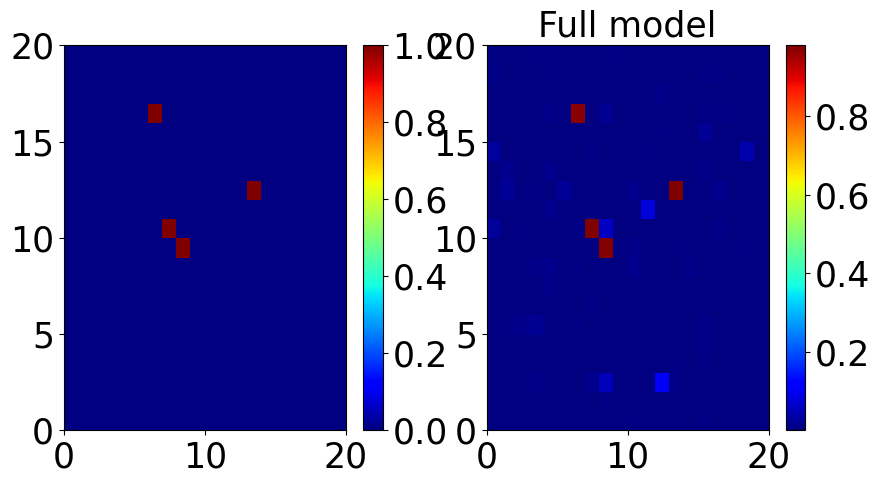

time for labeled: 178.4932985305786


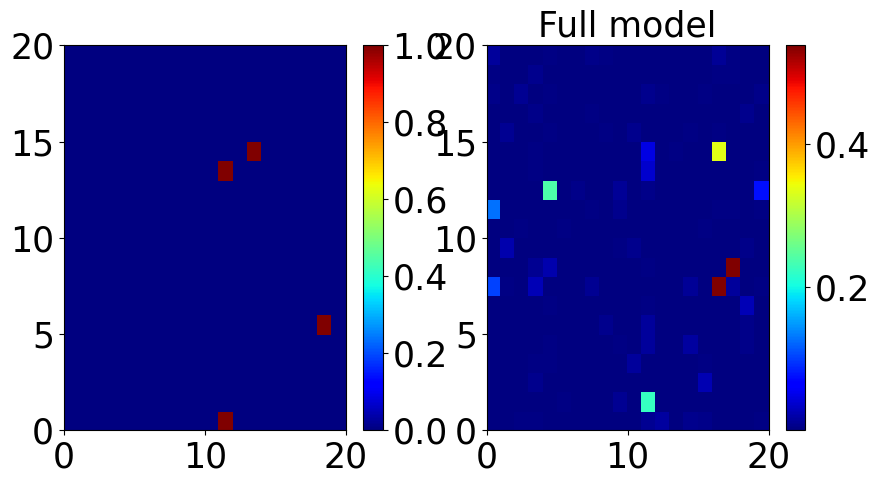

In [5]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=1000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128
layers=[64]*11
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=0)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled only
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled no batching
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=1e-15
layers=[5000,5000,5000,3000,3000,1400,800]
#layers.append(256)
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
b_train=training_data.b.to(device)
rho_train=training_data.rho.to(device)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    if True:
        b=b_train
        rho=rho_train
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        if KM_in:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            Mhat_imag=-Mhat_imag
            b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
            
        # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
            In_put=torch.cat((b, km_b), dim=-1)

            rho_hat=encoder(In_put)
        else:
            rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        if CE:
            rho_hat_hat=encoder(b_hat)

            CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
            CEloss.backward(retain_graph=True)
            CEloss=CEloss.item()

        
        if GELMA>0 and epoch>100:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg=inner_loss_term.item()/GELMA
            optimizer_GELMA.step()
            
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    #if epoch%10000==0:
    #   H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training variational autoencoder (KL replcaed with BCE)
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
layers=[500,500,500,300,300,300,400,800]
G_0=False
Epochs=10000
index_list=[]
KL_weight=1
L1_weight=1e-3

Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=512
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.variational_enc(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, [layers[len(layers)-i-1] for i in range(len(layers))],training_data.b[0].shape[0]/2 , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
L1_loss_fn=nn.L1Loss()
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)

lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    encoder.train()
    decoder.train()
    KL_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)

        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        rho_hat_mean, rho_hat_logvar=encoder(b)
        rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
        KLloss=H.KL_divergence(rho_hat_mean, rho_hat_logvar)*KL_weight
        KLloss.backward(retain_graph=True)
        #rho_hat=sigmoid(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()/len(trainloader)
        KL_lossavg+=KLloss.item()/len(trainloader)/KL_weight
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat_mean, rho_hat_logvar=encoder(b_val)
    rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
    #rho_hat=softmax(rho_hat)
    #rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        #Complex_eye=Complex_eye+
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, KL_LOSS: {KL_lossavg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original},  num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training unlabeled only. Encoder decoder alternation
starttime=time.time()
target='raw'
unlabeled_data=10000
L1_weight=0.005
GELMA=0.0
G_0=False
Epochs=100000
layers=[128]*14
GELMA_layers=[128]*5
GELMA_layers.append(500)
layers.append(500)



Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=128

#training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
b=training_data.b.to(device)
rho=training_data.rho.to(device)
rh_t, _=torch.split(rho, 400, dim=-1)


#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.Adam(decoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)

if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()


for epoch in range(Epochs):
    encoder.train()
    decoder.train()
    train_lossavg=0
    train_lossavg=0
    train_lossavg_decoder=0
    inner_loss_term_avg=0
    L1_loss_avg=0
    for param in encoder.parameters():
        param.requires_grad = True
    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()


        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss_avg+=L1_loss.item()/L1_weight/15
            #if L1_loss>5e-15:
                #L1_weight=L1_weight*0.999
        else:
            L1_loss=-1

        if GELMA>0:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg+=inner_loss_term.item()/GELMA/15
            optimizer_GELMA.step()
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


    
        optimizer.step()
        train_lossavg+=L2_loss.item()/15
    for param in encoder.parameters():
        param.requires_grad = False


    for i in range(15):
        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        font_size = 50
        rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)


        
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()



        optimizer_decod.step()
        train_lossavg_decoder+=L2_loss.item()/15
    
    
    val_lossavg=0
    if epoch%1000==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%1000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%100==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            index_of_max=np.argmax(torch_inners[:,i])
            torch_inners[:,index_of_max]=0*torch_inners[index_of_max,:]
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        
        
        
        print(f'epoch: {epoch}, Encoder train loss: {train_lossavg}, Decoder train loss: {train_lossavg_decoder} L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}')
        
    if Track_run:
        wandb.log(wand_dict)


if Track_run:
    wandb.finish()


In [ ]:
#cc data training
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

labeled_data=400
layer_loss_list=[]
Epochs=3000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    bce_loss.backward() 
    train_lossavg+=bce_loss.item()
    accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()
    accuracy_val=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}, train accuracy: {accuracy_train}, val accuracy: {accuracy_val}')


torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [ ]:
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
#data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_lowcow.pt'
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat_orderer))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,training_data[0][0].shape[0], bias=False)
#locat='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_long_bigdata/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_30-May-2024 (23:10:16)decoder.pt' #.61 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (23:10:30)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (21:26:12)decoder.pt' #.41 G_0 init
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (23:29:19)decoder.pt' #.92 random init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init


decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#function doing above
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(1):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Permutes the columns with inerse perm matrix.
Perm=orderer(cc_medium)
softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
hope=torch.tensor(np.linalg.inv(Perm.cpu().detach().numpy())).round()
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Compares the behavior of different decoder networks trained with different random realizations and different
#SGD randomness. 
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat1='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
locat2='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (10:33:30)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (07:51:38)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (02:50:48)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
for j in range(5):
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    larger_than=0
    sum_max_noreplace_original=0
    for i in range(400):
        if max(torch_inners[i,:])>.90:
            larger_than+=1
            total_list[j].append(i)
        sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
    print(larger_than)    


In [ ]:
####Tests orderer on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
print(training_data.b.shape)
data_path_G0_list=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

#original_G= np.array(mat73.loadmat(data_path_G0_list+'/rtt_array.mat')['RM_realization_list'])
print(original_G.shape)
training_data.b=original_G[58].T
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'

orderer.load_state_dict(torch.load(Locat_orderer))
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.train()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):

    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')


In [ ]:
####Tests if just looking at  proximoity of random media, and homo media data.
labeled_data=1000
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
test_cc=training_data[0][0]
target=training_data[0][1]
dummies=[]
print(medium.shape)

In [ ]:
####Tests ordered on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
labeled_data=40
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)

orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
orderer.load_state_dict(torch.load(Locat_orderer))
data_path=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

training_data=H.data_rho_CC_IID(data_path+'/train',labeled_data/80000)
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.eval()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):
    
    b=b.to(device)  
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    curr_acc=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if curr_acc<1.0:
        print(curr_acc)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)
    

print(f'accuracy: {accuracy}, loss: {lossavg}')

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()

    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()

    b=sensing@rho.T
    img=np.linalg.pinv(sensing_hat)@b
        
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    #cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat',SAME_bar=pcol_Used)
img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho',SAME_bar=pcol_Used)

In [ ]:
#Raw data training unlabeled conv layers
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')

unlabeled_data=5000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[32]*11
CE=False
KM_in=False

CONV=True

#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2

if CONV:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='conv',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
else:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
    
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            #if CONV:
            ##    rho_hat=rho_hat.squeeze()
            #    rho_hat=softmax(rho_hat)
            #    rho_hat=rho_hat*4
            #else:
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
  #  if epoch%10000==0:
      # H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
21376002
Data shapes: 725.0 0.5


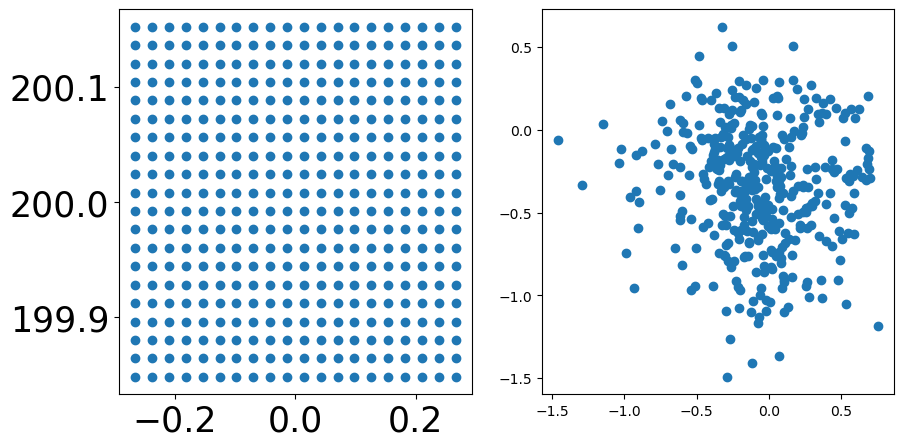

epoch: 0, train loss: 20067.8828125, val loss: 19937.111328125
epoch: 1, train loss: 19937.884765625, val loss: 19804.55859375
epoch: 2, train loss: 19805.12109375, val loss: 19663.994140625
epoch: 3, train loss: 19664.05078125, val loss: 19506.064453125
epoch: 4, train loss: 19505.625, val loss: 19318.70703125
epoch: 5, train loss: 19317.642578125, val loss: 19114.109375
epoch: 6, train loss: 19112.615234375, val loss: 18918.73046875
epoch: 7, train loss: 18917.77734375, val loss: 18739.9140625
epoch: 8, train loss: 18737.05859375, val loss: 18577.8125
epoch: 9, train loss: 18571.916015625, val loss: 18433.521484375
epoch: 10, train loss: 18428.09375, val loss: 18303.302734375
epoch: 11, train loss: 18285.576171875, val loss: 18167.09375
epoch: 12, train loss: 18165.81640625, val loss: 18033.146484375
epoch: 13, train loss: 18027.0234375, val loss: 17893.88671875
epoch: 14, train loss: 17885.7265625, val loss: 17755.58984375
epoch: 15, train loss: 17745.5703125, val loss: 17620.974609

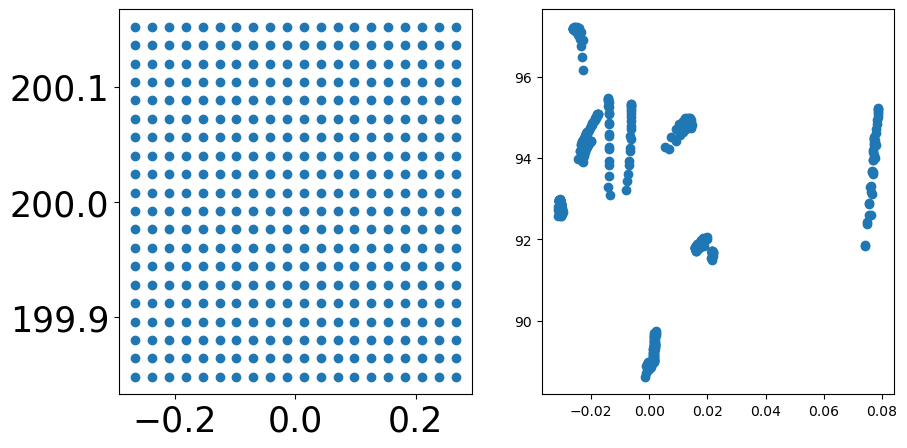

epoch: 100, train loss: 5754.16162109375, val loss: 5677.966796875
epoch: 101, train loss: 5643.8359375, val loss: 5565.6259765625
epoch: 102, train loss: 5534.794921875, val loss: 5453.3271484375
epoch: 103, train loss: 5427.0888671875, val loss: 5343.109375
epoch: 104, train loss: 5320.5400390625, val loss: 5235.89794921875
epoch: 105, train loss: 5215.02587890625, val loss: 5131.7724609375
epoch: 106, train loss: 5110.6962890625, val loss: 5030.11279296875
epoch: 107, train loss: 5007.6982421875, val loss: 4929.72314453125
epoch: 108, train loss: 4905.9228515625, val loss: 4829.7451171875
epoch: 109, train loss: 4805.2509765625, val loss: 4730.38037109375
epoch: 110, train loss: 4705.78076171875, val loss: 4632.30810546875
epoch: 111, train loss: 4607.59765625, val loss: 4535.7373046875
epoch: 112, train loss: 4510.62451171875, val loss: 4440.46533203125
epoch: 113, train loss: 4414.818359375, val loss: 4346.2880859375
epoch: 114, train loss: 4320.248046875, val loss: 4253.033203125

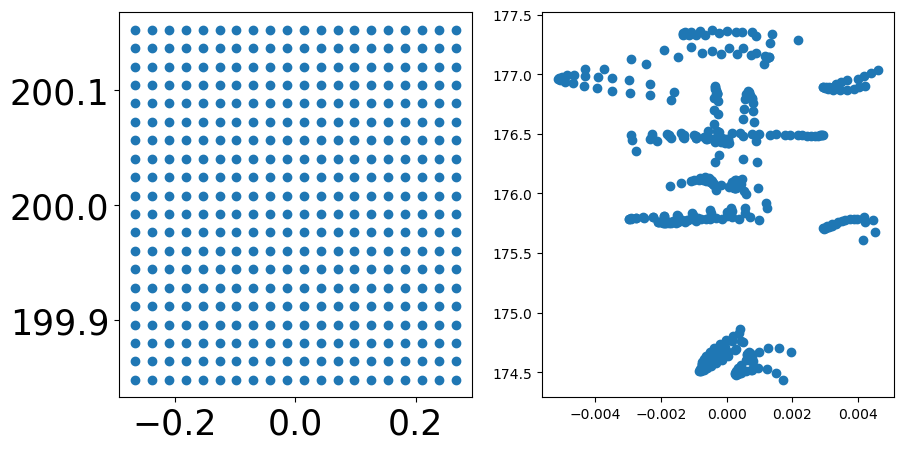

epoch: 200, train loss: 287.3804931640625, val loss: 298.11767578125
epoch: 201, train loss: 275.3324279785156, val loss: 286.4290771484375
epoch: 202, train loss: 263.71453857421875, val loss: 275.1459655761719
epoch: 203, train loss: 252.5154266357422, val loss: 264.2646789550781
epoch: 204, train loss: 241.7231903076172, val loss: 253.78878784179688
epoch: 205, train loss: 231.32632446289062, val loss: 243.71023559570312
epoch: 206, train loss: 221.3134765625, val loss: 234.00128173828125
epoch: 207, train loss: 211.67364501953125, val loss: 224.63479614257812
epoch: 208, train loss: 202.39613342285156, val loss: 215.6063232421875
epoch: 209, train loss: 193.47000122070312, val loss: 206.9285430908203
epoch: 210, train loss: 184.884521484375, val loss: 198.60264587402344
epoch: 211, train loss: 176.62973022460938, val loss: 190.6062469482422
epoch: 212, train loss: 168.69515991210938, val loss: 182.91238403320312
epoch: 213, train loss: 161.07081604003906, val loss: 175.510070800781

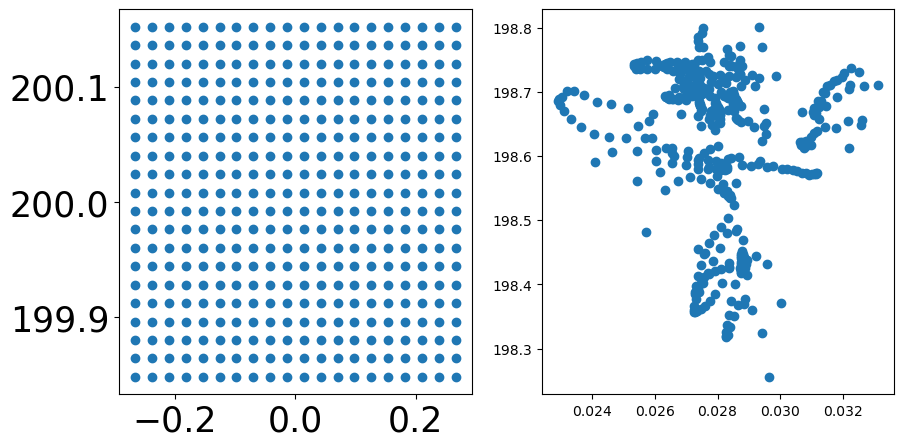

epoch: 300, train loss: 0.972081184387207, val loss: 19.158849716186523
epoch: 301, train loss: 0.9065926671028137, val loss: 19.08439826965332
epoch: 302, train loss: 0.8458378314971924, val loss: 19.010772705078125
epoch: 303, train loss: 0.7857723832130432, val loss: 18.944477081298828
epoch: 304, train loss: 0.7326778769493103, val loss: 18.88162612915039
epoch: 305, train loss: 0.6827108860015869, val loss: 18.820148468017578
epoch: 306, train loss: 0.634024977684021, val loss: 18.764596939086914
epoch: 307, train loss: 0.5910070538520813, val loss: 18.7115535736084
epoch: 308, train loss: 0.5500994920730591, val loss: 18.660404205322266
epoch: 309, train loss: 0.5107831358909607, val loss: 18.61412239074707
epoch: 310, train loss: 0.4759477972984314, val loss: 18.569564819335938
epoch: 311, train loss: 0.44258955121040344, val loss: 18.526762008666992
epoch: 312, train loss: 0.4109334349632263, val loss: 18.487743377685547
epoch: 313, train loss: 0.382756769657135, val loss: 18.4

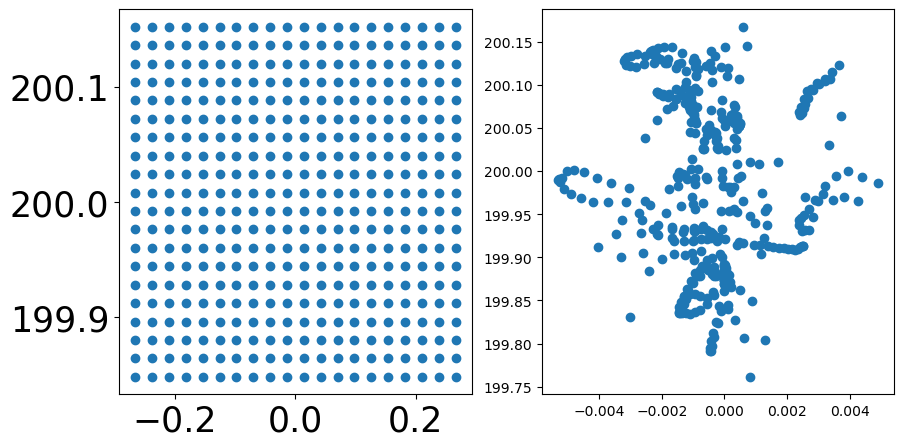

epoch: 400, train loss: 0.013490354642271996, val loss: 17.643278121948242
epoch: 401, train loss: 0.013475121930241585, val loss: 17.64002227783203
epoch: 402, train loss: 0.0134613998234272, val loss: 17.636751174926758
epoch: 403, train loss: 0.013448989018797874, val loss: 17.63359260559082
epoch: 404, train loss: 0.013437552377581596, val loss: 17.630416870117188
epoch: 405, train loss: 0.013427143916487694, val loss: 17.62732696533203
epoch: 406, train loss: 0.013417708687484264, val loss: 17.624187469482422
epoch: 407, train loss: 0.01340898685157299, val loss: 17.620969772338867
epoch: 408, train loss: 0.01340104453265667, val loss: 17.617809295654297
epoch: 409, train loss: 0.013393830507993698, val loss: 17.61475372314453
epoch: 410, train loss: 0.013387183658778667, val loss: 17.611677169799805
epoch: 411, train loss: 0.013381035067141056, val loss: 17.60856819152832
epoch: 412, train loss: 0.013375424779951572, val loss: 17.60564613342285
epoch: 413, train loss: 0.013370232

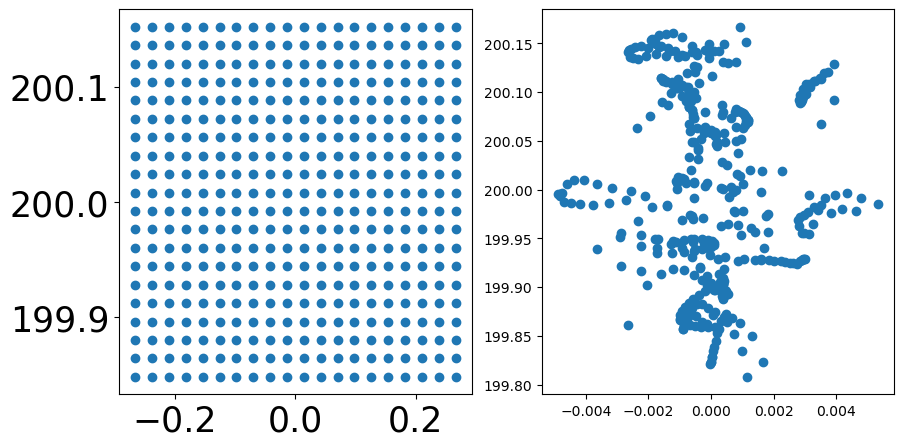

epoch: 500, train loss: 0.013232633471488953, val loss: 17.41507339477539
epoch: 501, train loss: 0.013231717981398106, val loss: 17.413646697998047
epoch: 502, train loss: 0.013230801559984684, val loss: 17.412206649780273
epoch: 503, train loss: 0.013229877687990665, val loss: 17.41077423095703
epoch: 504, train loss: 0.013228959403932095, val loss: 17.409345626831055
epoch: 505, train loss: 0.013228058815002441, val loss: 17.407814025878906
epoch: 506, train loss: 0.013227103278040886, val loss: 17.40633773803711
epoch: 507, train loss: 0.013226225040853024, val loss: 17.404937744140625
epoch: 508, train loss: 0.013225292786955833, val loss: 17.403451919555664
epoch: 509, train loss: 0.0132244061678648, val loss: 17.402042388916016
epoch: 510, train loss: 0.013223545625805855, val loss: 17.40066146850586
epoch: 511, train loss: 0.01322262641042471, val loss: 17.399200439453125
epoch: 512, train loss: 0.013221750035881996, val loss: 17.39769172668457
epoch: 513, train loss: 0.0132209

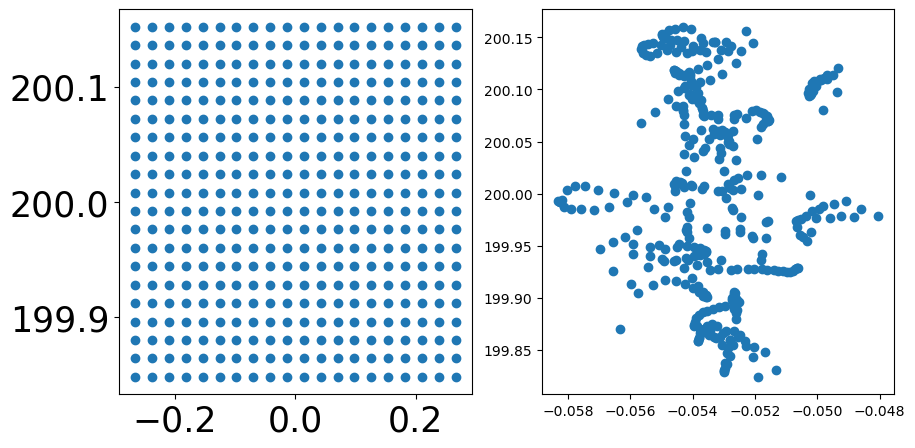

epoch: 600, train loss: 0.014582738280296326, val loss: 17.297163009643555
epoch: 601, train loss: 0.0138162262737751, val loss: 17.295499801635742
epoch: 602, train loss: 0.01319226436316967, val loss: 17.295373916625977
epoch: 603, train loss: 0.014004077762365341, val loss: 17.294145584106445
epoch: 604, train loss: 0.013929571956396103, val loss: 17.29246711730957
epoch: 605, train loss: 0.013186628930270672, val loss: 17.291894912719727
epoch: 606, train loss: 0.013538517989218235, val loss: 17.29118537902832
epoch: 607, train loss: 0.013851772993803024, val loss: 17.28972053527832
epoch: 608, train loss: 0.013307399116456509, val loss: 17.2886962890625
epoch: 609, train loss: 0.013260969892144203, val loss: 17.288105010986328
epoch: 610, train loss: 0.013654309324920177, val loss: 17.28699493408203
epoch: 611, train loss: 0.013419889844954014, val loss: 17.285673141479492
epoch: 612, train loss: 0.013162175193428993, val loss: 17.284927368164062
epoch: 613, train loss: 0.01343124

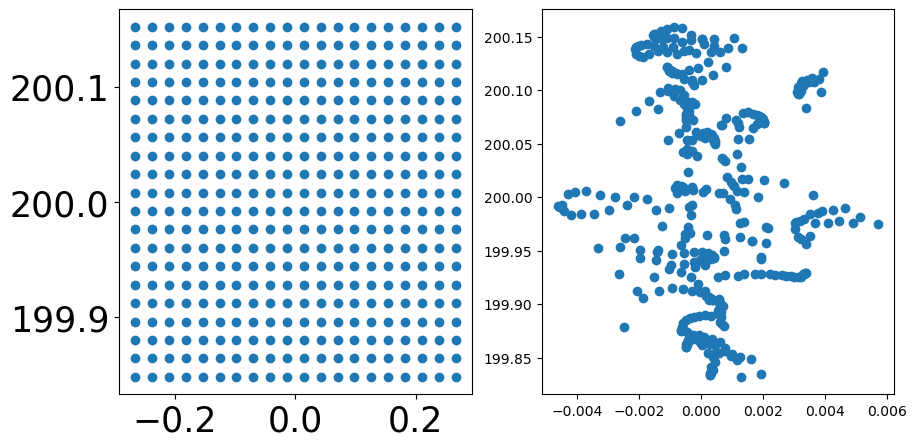

epoch: 700, train loss: 0.013125328347086906, val loss: 17.20964813232422
epoch: 701, train loss: 0.01312499213963747, val loss: 17.208948135375977
epoch: 702, train loss: 0.013124608434736729, val loss: 17.208206176757812
epoch: 703, train loss: 0.01312429178506136, val loss: 17.20747947692871
epoch: 704, train loss: 0.013123993761837482, val loss: 17.20686149597168
epoch: 705, train loss: 0.01312367431819439, val loss: 17.206073760986328
epoch: 706, train loss: 0.013123316690325737, val loss: 17.205406188964844
epoch: 707, train loss: 0.013122981414198875, val loss: 17.204687118530273
epoch: 708, train loss: 0.01312266755849123, val loss: 17.204010009765625
epoch: 709, train loss: 0.01312235090881586, val loss: 17.20334243774414
epoch: 710, train loss: 0.013122005388140678, val loss: 17.202510833740234
epoch: 711, train loss: 0.013121677562594414, val loss: 17.20186996459961
epoch: 712, train loss: 0.013121350668370724, val loss: 17.201215744018555
epoch: 713, train loss: 0.013121056

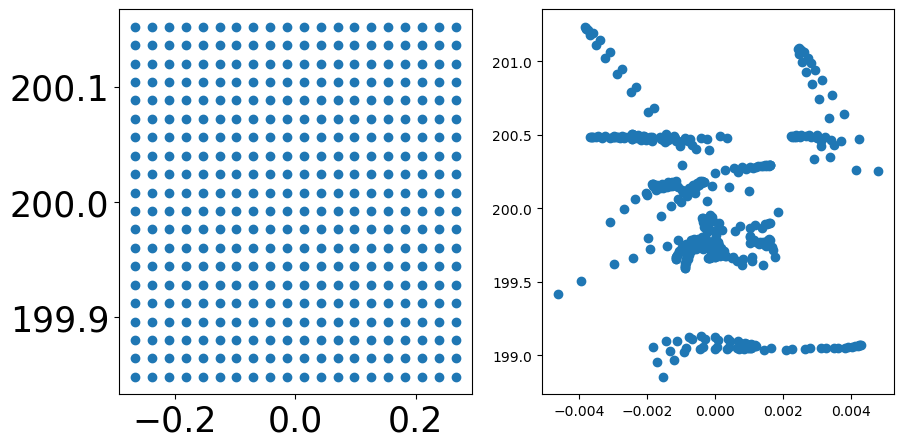

epoch: 800, train loss: 0.13255710899829865, val loss: 21.365291595458984
epoch: 801, train loss: 0.42048168182373047, val loss: 21.49833869934082
epoch: 802, train loss: 0.6303130388259888, val loss: 20.13864517211914
epoch: 803, train loss: 0.11496461927890778, val loss: 20.09264373779297
epoch: 804, train loss: 0.2556714117527008, val loss: 20.39491081237793
epoch: 805, train loss: 0.451118141412735, val loss: 20.039005279541016
epoch: 806, train loss: 0.1121472418308258, val loss: 18.98171615600586
epoch: 807, train loss: 0.19845432043075562, val loss: 19.58383560180664
epoch: 808, train loss: 0.2972126305103302, val loss: 19.42342758178711
epoch: 809, train loss: 0.08212271332740784, val loss: 17.982364654541016
epoch: 810, train loss: 0.18345464766025543, val loss: 18.92378044128418
epoch: 811, train loss: 0.19845595955848694, val loss: 18.603261947631836
epoch: 812, train loss: 0.04767949879169464, val loss: 17.195486068725586
epoch: 813, train loss: 0.16265542805194855, val los

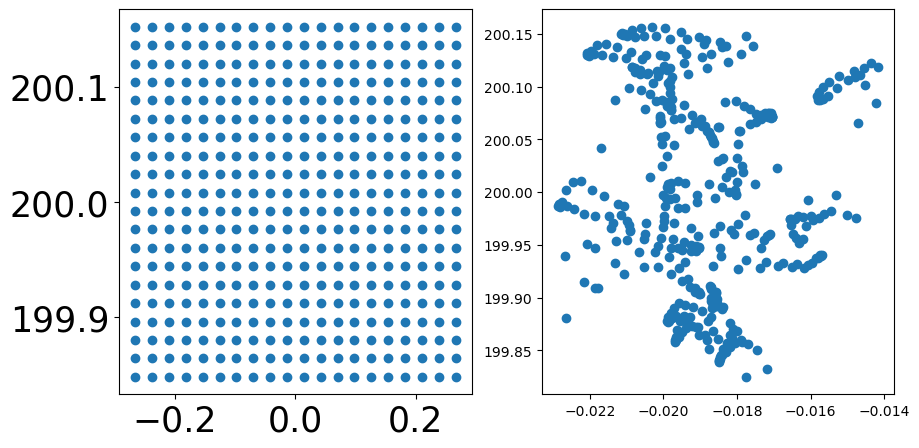

epoch: 900, train loss: 0.013322477228939533, val loss: 16.43179702758789
epoch: 901, train loss: 0.01581496186554432, val loss: 16.432743072509766
epoch: 902, train loss: 0.017462212592363358, val loss: 16.43678855895996
epoch: 903, train loss: 0.01580599509179592, val loss: 16.419267654418945
epoch: 904, train loss: 0.01344233937561512, val loss: 16.41940689086914
epoch: 905, train loss: 0.013579347170889378, val loss: 16.421855926513672
epoch: 906, train loss: 0.015300075523555279, val loss: 16.41361427307129
epoch: 907, train loss: 0.015597042627632618, val loss: 16.409025192260742
epoch: 908, train loss: 0.014079769141972065, val loss: 16.408369064331055
epoch: 909, train loss: 0.01313157007098198, val loss: 16.402799606323242
epoch: 910, train loss: 0.013884353451430798, val loss: 16.39853286743164
epoch: 911, train loss: 0.014746739529073238, val loss: 16.3997745513916
epoch: 912, train loss: 0.014275764115154743, val loss: 16.391481399536133
epoch: 913, train loss: 0.0133000081

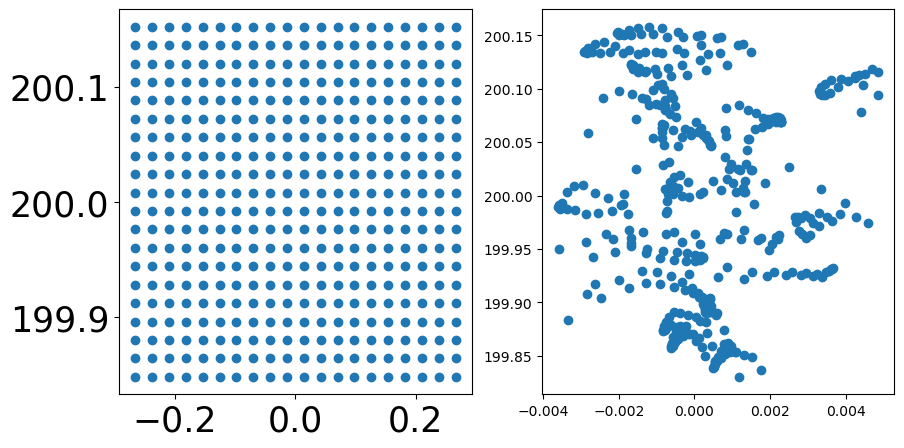

epoch: 1000, train loss: 0.01308920606970787, val loss: 16.260379791259766
epoch: 1001, train loss: 0.013088898733258247, val loss: 16.259382247924805
epoch: 1002, train loss: 0.013088654726743698, val loss: 16.258365631103516
epoch: 1003, train loss: 0.013088397681713104, val loss: 16.257448196411133
epoch: 1004, train loss: 0.013088095933198929, val loss: 16.25628089904785
epoch: 1005, train loss: 0.013087750412523746, val loss: 16.25540542602539
epoch: 1006, train loss: 0.013087396509945393, val loss: 16.25436782836914
epoch: 1007, train loss: 0.0130870770663023, val loss: 16.253244400024414
epoch: 1008, train loss: 0.013086792081594467, val loss: 16.252519607543945
epoch: 1009, train loss: 0.013086538761854172, val loss: 16.251319885253906
epoch: 1010, train loss: 0.013086293824017048, val loss: 16.25040054321289
epoch: 1011, train loss: 0.013085989281535149, val loss: 16.249448776245117
epoch: 1012, train loss: 0.013085655868053436, val loss: 16.248430252075195
epoch: 1013, train 

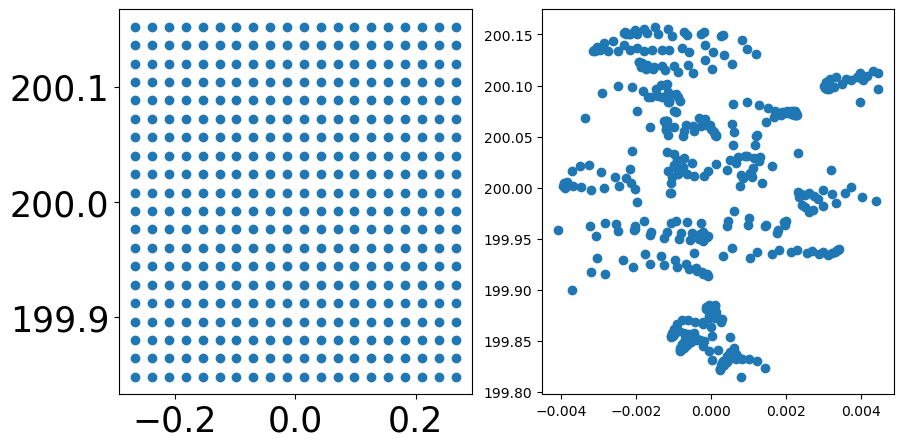

epoch: 1100, train loss: 0.013120689429342747, val loss: 16.194440841674805
epoch: 1101, train loss: 0.013171915896236897, val loss: 16.15635108947754
epoch: 1102, train loss: 0.013272668235003948, val loss: 16.208646774291992
epoch: 1103, train loss: 0.013472233898937702, val loss: 16.13390350341797
epoch: 1104, train loss: 0.013870236463844776, val loss: 16.23906707763672
epoch: 1105, train loss: 0.014669899828732014, val loss: 16.091093063354492
epoch: 1106, train loss: 0.016288086771965027, val loss: 16.30534553527832
epoch: 1107, train loss: 0.01958566904067993, val loss: 16.009544372558594
epoch: 1108, train loss: 0.026352237910032272, val loss: 16.454784393310547
epoch: 1109, train loss: 0.04032119736075401, val loss: 15.863131523132324
epoch: 1110, train loss: 0.06931094825267792, val loss: 16.815509796142578
epoch: 1111, train loss: 0.12960723042488098, val loss: 15.656913757324219
epoch: 1112, train loss: 0.25483444333076477, val loss: 17.77442169189453
epoch: 1113, train los

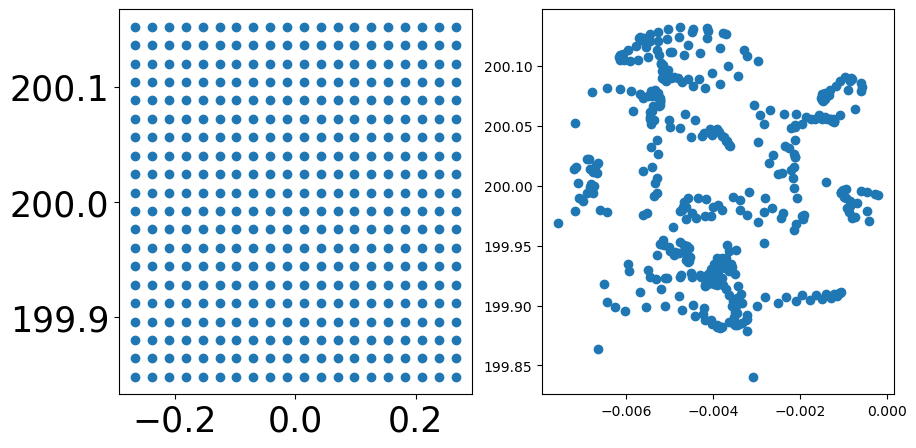

epoch: 1200, train loss: 0.01349368505179882, val loss: 12.91823673248291
epoch: 1201, train loss: 0.013369868509471416, val loss: 12.789973258972168
epoch: 1202, train loss: 0.013304724358022213, val loss: 12.844489097595215
epoch: 1203, train loss: 0.013353663496673107, val loss: 12.896393775939941
epoch: 1204, train loss: 0.01319789607077837, val loss: 12.799819946289062
epoch: 1205, train loss: 0.013269382528960705, val loss: 12.84850025177002
epoch: 1206, train loss: 0.013331286609172821, val loss: 12.866273880004883
epoch: 1207, train loss: 0.013190362602472305, val loss: 12.827933311462402
epoch: 1208, train loss: 0.01319564413279295, val loss: 12.829272270202637
epoch: 1209, train loss: 0.013208221644163132, val loss: 12.852229118347168
epoch: 1210, train loss: 0.013178243301808834, val loss: 12.84543514251709
epoch: 1211, train loss: 0.013211105018854141, val loss: 12.804632186889648
epoch: 1212, train loss: 0.013168249279260635, val loss: 12.85326862335205
epoch: 1213, train 

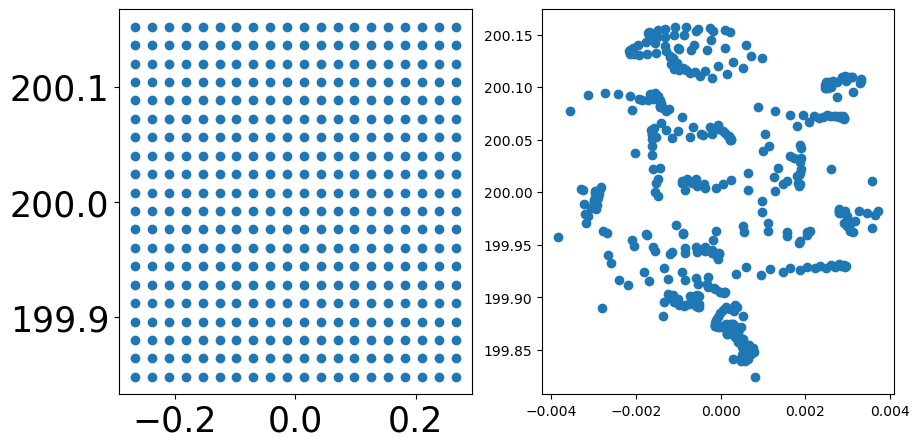

epoch: 1300, train loss: 0.013054483570158482, val loss: 12.759102821350098
epoch: 1301, train loss: 0.01305427961051464, val loss: 12.758733749389648
epoch: 1302, train loss: 0.013054079376161098, val loss: 12.75754165649414
epoch: 1303, train loss: 0.013053903356194496, val loss: 12.757686614990234
epoch: 1304, train loss: 0.013053683564066887, val loss: 12.75748062133789
epoch: 1305, train loss: 0.013053502887487411, val loss: 12.756051063537598
epoch: 1306, train loss: 0.013053316622972488, val loss: 12.756670951843262
epoch: 1307, train loss: 0.013053130358457565, val loss: 12.755899429321289
epoch: 1308, train loss: 0.013052923604846, val loss: 12.754956245422363
epoch: 1309, train loss: 0.01305272988975048, val loss: 12.755372047424316
epoch: 1310, train loss: 0.013052542693912983, val loss: 12.754408836364746
epoch: 1311, train loss: 0.01305235456675291, val loss: 12.753867149353027
epoch: 1312, train loss: 0.013052165508270264, val loss: 12.75384521484375
epoch: 1313, train lo

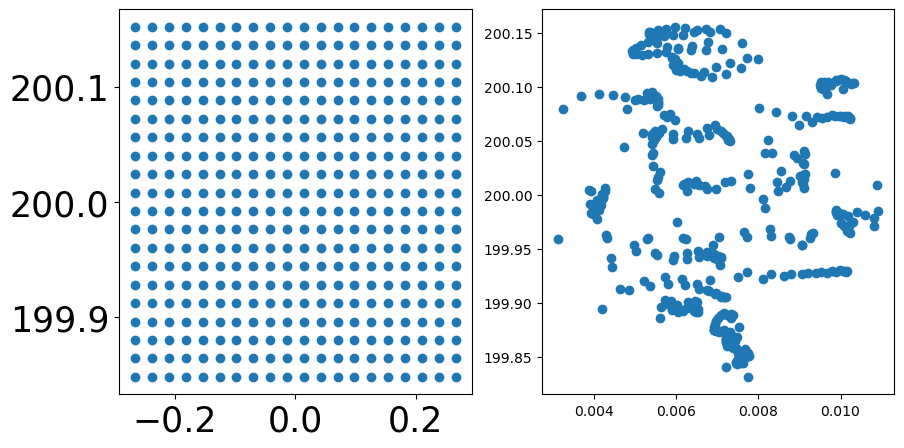

epoch: 1400, train loss: 0.013065220788121223, val loss: 12.733034133911133
epoch: 1401, train loss: 0.013298890553414822, val loss: 12.727778434753418
epoch: 1402, train loss: 0.013422617688775063, val loss: 12.733996391296387
epoch: 1403, train loss: 0.013259956613183022, val loss: 12.724915504455566
epoch: 1404, train loss: 0.013063452206552029, val loss: 12.736234664916992
epoch: 1405, train loss: 0.013087098486721516, val loss: 12.720964431762695
epoch: 1406, train loss: 0.01324114203453064, val loss: 12.741020202636719
epoch: 1407, train loss: 0.013282407075166702, val loss: 12.713749885559082
epoch: 1408, train loss: 0.013174917548894882, val loss: 12.749666213989258
epoch: 1409, train loss: 0.013103150762617588, val loss: 12.700807571411133
epoch: 1410, train loss: 0.013192281126976013, val loss: 12.76663589477539
epoch: 1411, train loss: 0.013372132554650307, val loss: 12.677396774291992
epoch: 1412, train loss: 0.013545130379498005, val loss: 12.798859596252441
epoch: 1413, t

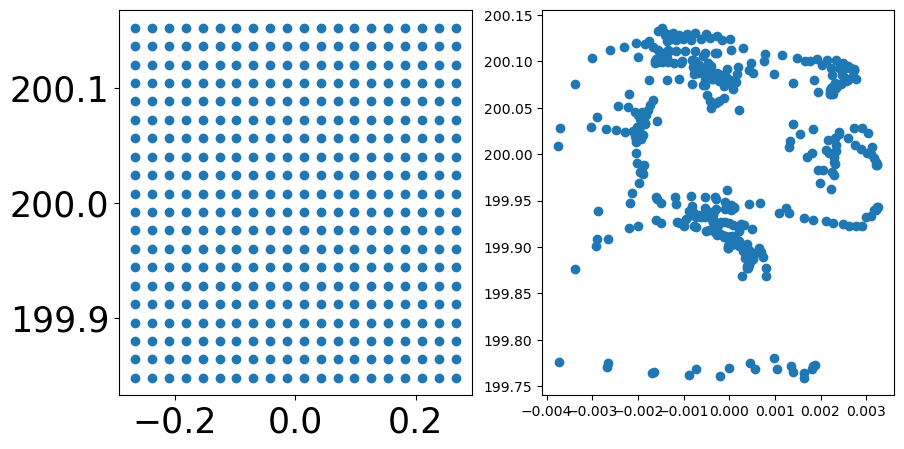

epoch: 1500, train loss: 0.014473151415586472, val loss: 7.595053672790527
epoch: 1501, train loss: 0.013598778285086155, val loss: 7.602822303771973
epoch: 1502, train loss: 0.013525952585041523, val loss: 7.716109275817871
epoch: 1503, train loss: 0.014122654683887959, val loss: 7.590767860412598
epoch: 1504, train loss: 0.013390939682722092, val loss: 7.612764835357666
epoch: 1505, train loss: 0.013396973721683025, val loss: 7.702479839324951
epoch: 1506, train loss: 0.013909630477428436, val loss: 7.586301326751709
epoch: 1507, train loss: 0.01330826710909605, val loss: 7.622896671295166
epoch: 1508, train loss: 0.013266585767269135, val loss: 7.683999061584473
epoch: 1509, train loss: 0.013661336153745651, val loss: 7.592841625213623
epoch: 1510, train loss: 0.013255281373858452, val loss: 7.632272720336914
epoch: 1511, train loss: 0.013238436542451382, val loss: 7.671788215637207
epoch: 1512, train loss: 0.013507598079741001, val loss: 7.607213497161865
epoch: 1513, train loss: 0

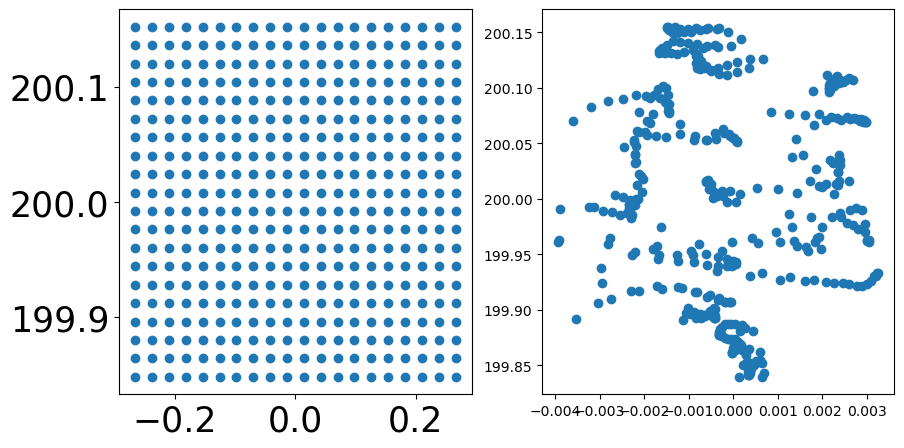

epoch: 1600, train loss: 0.013041870668530464, val loss: 7.695659637451172
epoch: 1601, train loss: 0.013041704893112183, val loss: 7.696945667266846
epoch: 1602, train loss: 0.013041513971984386, val loss: 7.6969170570373535
epoch: 1603, train loss: 0.013041350990533829, val loss: 7.697102069854736
epoch: 1604, train loss: 0.013041178695857525, val loss: 7.698281764984131
epoch: 1605, train loss: 0.013041011989116669, val loss: 7.698018550872803
epoch: 1606, train loss: 0.013040842488408089, val loss: 7.698574066162109
epoch: 1607, train loss: 0.013040678575634956, val loss: 7.699398040771484
epoch: 1608, train loss: 0.013040509074926376, val loss: 7.699191093444824
epoch: 1609, train loss: 0.013040339574217796, val loss: 7.699958324432373
epoch: 1610, train loss: 0.013040181249380112, val loss: 7.700425624847412
epoch: 1611, train loss: 0.013040036894381046, val loss: 7.700483798980713
epoch: 1612, train loss: 0.013039875775575638, val loss: 7.701159954071045
epoch: 1613, train loss:

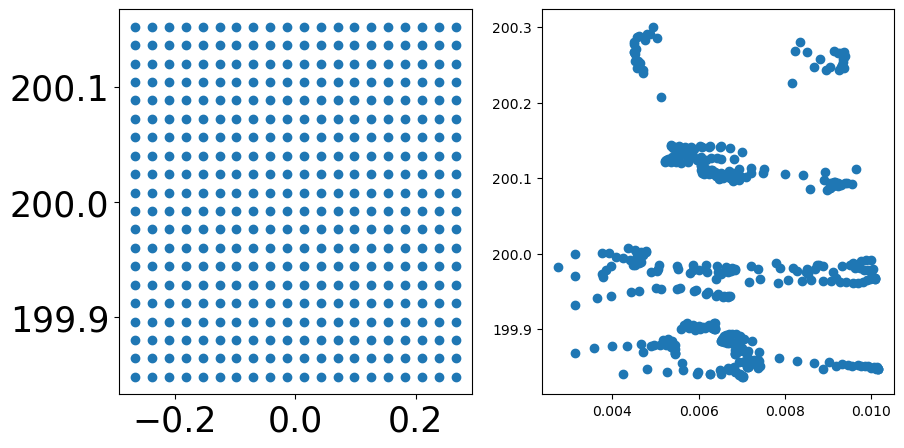

epoch: 1700, train loss: 0.019530151039361954, val loss: 7.787650108337402
epoch: 1701, train loss: 0.025198744609951973, val loss: 7.684135437011719
epoch: 1702, train loss: 0.036004818975925446, val loss: 7.862261772155762
epoch: 1703, train loss: 0.05664285644888878, val loss: 7.685628414154053
epoch: 1704, train loss: 0.09619942307472229, val loss: 8.060840606689453
epoch: 1705, train loss: 0.17158541083335876, val loss: 7.794521331787109
epoch: 1706, train loss: 0.31465011835098267, val loss: 8.62412166595459
epoch: 1707, train loss: 0.5777544975280762, val loss: 8.331363677978516
epoch: 1708, train loss: 1.041479229927063, val loss: 10.053569793701172
epoch: 1709, train loss: 1.762370228767395, val loss: 9.72793960571289
epoch: 1710, train loss: 2.674107074737549, val loss: 11.681994438171387
epoch: 1711, train loss: 3.26261305809021, val loss: 9.983152389526367
epoch: 1712, train loss: 2.8680007457733154, val loss: 9.160314559936523
epoch: 1713, train loss: 1.3684072494506836, v

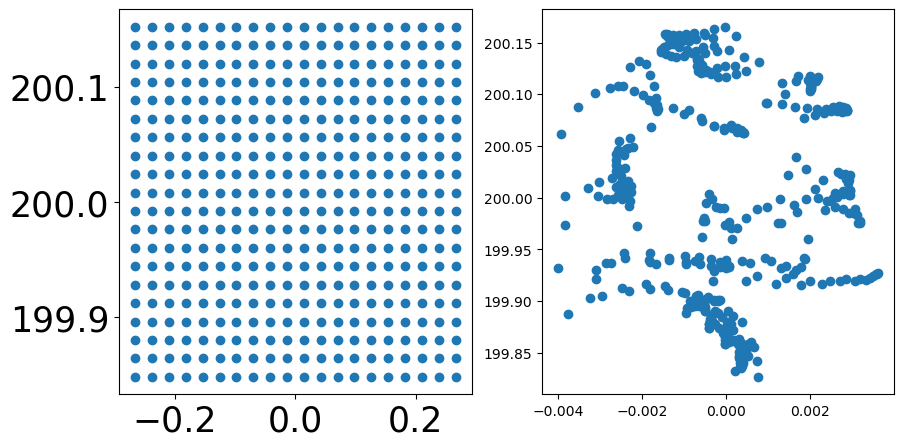

epoch: 1800, train loss: 0.013112830929458141, val loss: 7.958497524261475
epoch: 1801, train loss: 0.01313731912523508, val loss: 7.965218544006348
epoch: 1802, train loss: 0.013130840845406055, val loss: 7.971377849578857
epoch: 1803, train loss: 0.013082921504974365, val loss: 7.953110218048096
epoch: 1804, train loss: 0.013105501420795918, val loss: 7.968550682067871
epoch: 1805, train loss: 0.013120567426085472, val loss: 7.962043285369873
epoch: 1806, train loss: 0.013075347058475018, val loss: 7.952160358428955
epoch: 1807, train loss: 0.01307910867035389, val loss: 7.972400188446045
epoch: 1808, train loss: 0.013108586892485619, val loss: 7.949460983276367
epoch: 1809, train loss: 0.013080772012472153, val loss: 7.966183185577393
epoch: 1810, train loss: 0.013065882958471775, val loss: 7.959085464477539
epoch: 1811, train loss: 0.013090824708342552, val loss: 7.958146572113037
epoch: 1812, train loss: 0.013082022778689861, val loss: 7.959307670593262
epoch: 1813, train loss: 0.

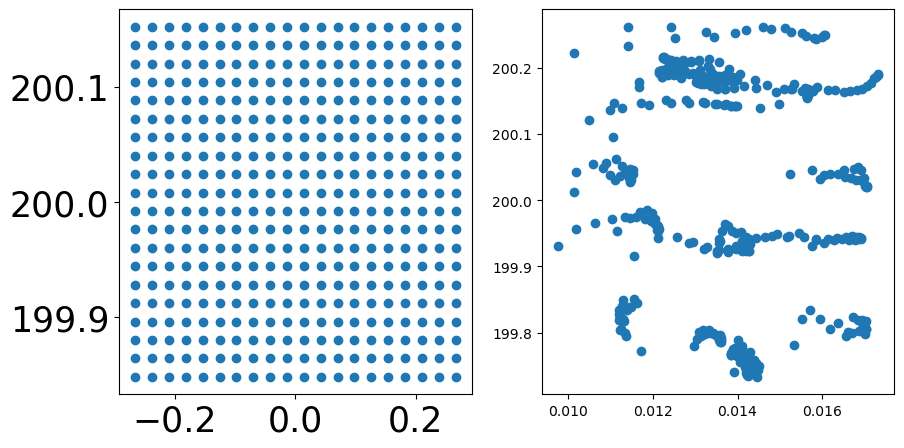

epoch: 1900, train loss: 0.024668635800480843, val loss: 9.428767204284668
epoch: 1901, train loss: 0.017552709206938744, val loss: 9.280607223510742
epoch: 1902, train loss: 0.014724086970090866, val loss: 9.39223861694336
epoch: 1903, train loss: 0.018300047144293785, val loss: 9.347941398620605
epoch: 1904, train loss: 0.020325660705566406, val loss: 9.288372039794922
epoch: 1905, train loss: 0.017772866412997246, val loss: 9.410527229309082
epoch: 1906, train loss: 0.01592414639890194, val loss: 9.240692138671875
epoch: 1907, train loss: 0.017691053450107574, val loss: 9.371254920959473
epoch: 1908, train loss: 0.01951592229306698, val loss: 9.301504135131836
epoch: 1909, train loss: 0.018909763544797897, val loss: 9.254738807678223
epoch: 1910, train loss: 0.01861935295164585, val loss: 9.369996070861816
epoch: 1911, train loss: 0.0211036279797554, val loss: 9.20772933959961
epoch: 1912, train loss: 0.023996500298380852, val loss: 9.335257530212402
epoch: 1913, train loss: 0.02396

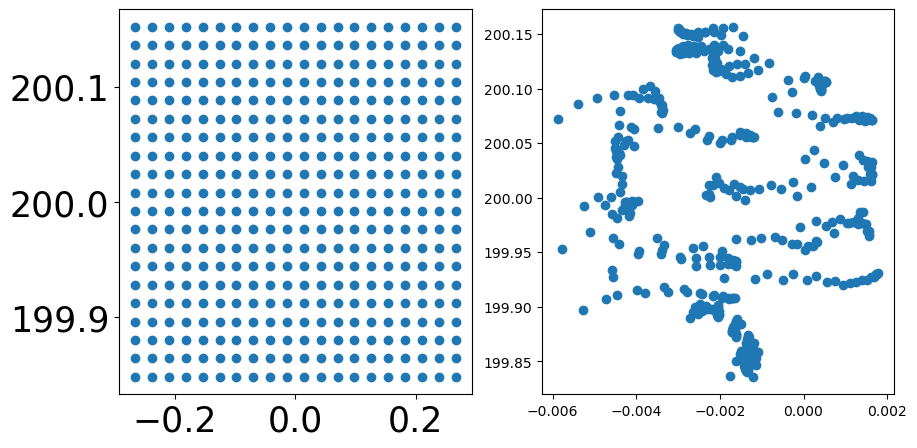

epoch: 2000, train loss: 0.013025660067796707, val loss: 9.069198608398438
epoch: 2001, train loss: 0.013025023974478245, val loss: 9.067927360534668
epoch: 2002, train loss: 0.013024347834289074, val loss: 9.06757926940918
epoch: 2003, train loss: 0.013023894280195236, val loss: 9.06580924987793
epoch: 2004, train loss: 0.013023726642131805, val loss: 9.06567096710205
epoch: 2005, train loss: 0.013023704290390015, val loss: 9.063965797424316
epoch: 2006, train loss: 0.013023699633777142, val loss: 9.06361198425293
epoch: 2007, train loss: 0.013023671694099903, val loss: 9.062259674072266
epoch: 2008, train loss: 0.013023653998970985, val loss: 9.061665534973145
epoch: 2009, train loss: 0.013023650273680687, val loss: 9.060574531555176
epoch: 2010, train loss: 0.013023629784584045, val loss: 9.059792518615723
epoch: 2011, train loss: 0.013023531064391136, val loss: 9.058839797973633
epoch: 2012, train loss: 0.013023330830037594, val loss: 9.057880401611328
epoch: 2013, train loss: 0.01

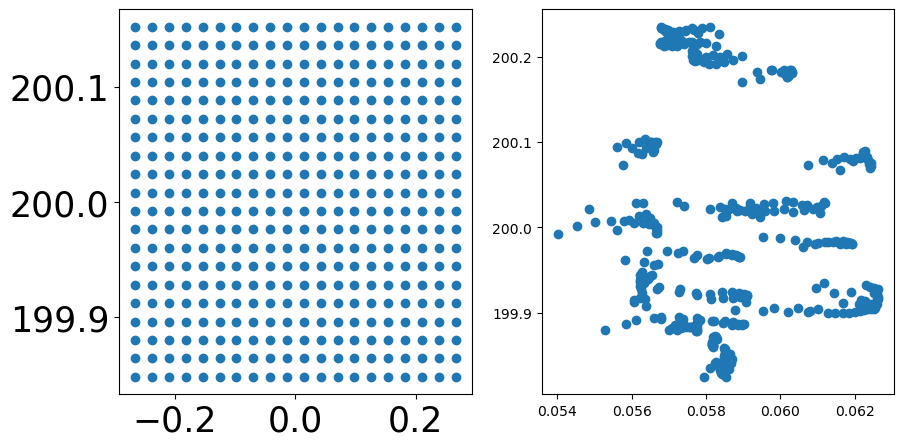

epoch: 2100, train loss: 0.017176078632473946, val loss: 9.121562004089355
epoch: 2101, train loss: 0.01759459637105465, val loss: 8.863463401794434
epoch: 2102, train loss: 0.020304035395383835, val loss: 9.212257385253906
epoch: 2103, train loss: 0.026375336572527885, val loss: 8.76719856262207
epoch: 2104, train loss: 0.036658547818660736, val loss: 9.386384010314941
epoch: 2105, train loss: 0.053573377430438995, val loss: 8.611433982849121
epoch: 2106, train loss: 0.08311823010444641, val loss: 9.733509063720703
epoch: 2107, train loss: 0.1365802139043808, val loss: 8.396679878234863
epoch: 2108, train loss: 0.23311159014701843, val loss: 10.469046592712402
epoch: 2109, train loss: 0.40394148230552673, val loss: 8.222731590270996
epoch: 2110, train loss: 0.6989834904670715, val loss: 12.041728019714355
epoch: 2111, train loss: 1.185532569885254, val loss: 8.412450790405273
epoch: 2112, train loss: 1.9228850603103638, val loss: 14.703718185424805
epoch: 2113, train loss: 2.859008073

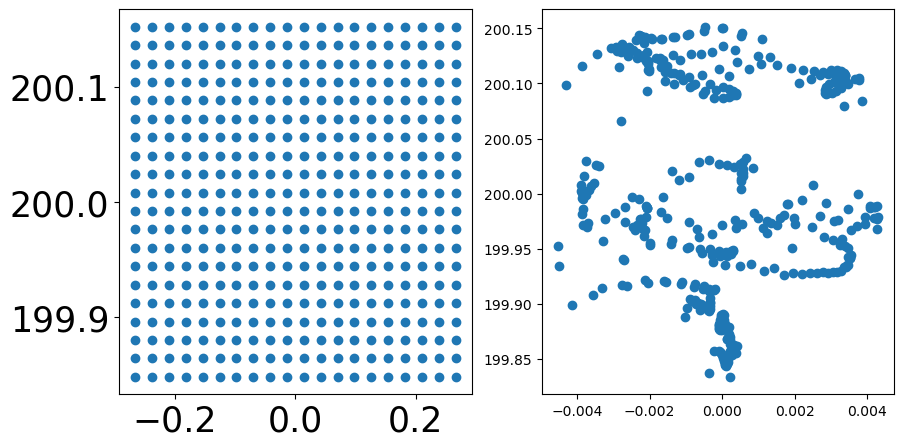

epoch: 2200, train loss: 0.013260465115308762, val loss: 5.051823616027832
epoch: 2201, train loss: 0.013155197724699974, val loss: 5.053301811218262
epoch: 2202, train loss: 0.0130747240036726, val loss: 5.053089618682861
epoch: 2203, train loss: 0.013172735460102558, val loss: 5.054304122924805
epoch: 2204, train loss: 0.013173510320484638, val loss: 5.055102348327637
epoch: 2205, train loss: 0.01307192537933588, val loss: 5.053998947143555
epoch: 2206, train loss: 0.01309917215257883, val loss: 5.056972026824951
epoch: 2207, train loss: 0.01315387338399887, val loss: 5.053729057312012
epoch: 2208, train loss: 0.013093335554003716, val loss: 5.058888912200928
epoch: 2209, train loss: 0.01306462287902832, val loss: 5.0546674728393555
epoch: 2210, train loss: 0.013112354092299938, val loss: 5.057898044586182
epoch: 2211, train loss: 0.01309602428227663, val loss: 5.0585408210754395
epoch: 2212, train loss: 0.01305034477263689, val loss: 5.054888725280762
epoch: 2213, train loss: 0.0130

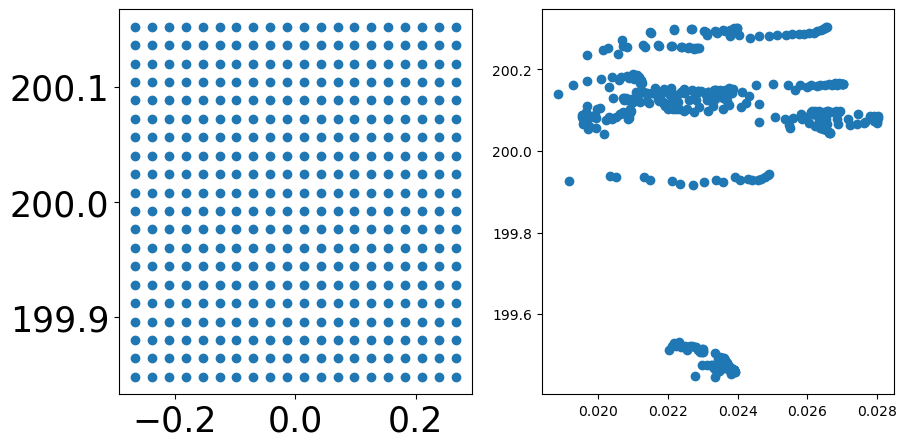

epoch: 2300, train loss: 0.03923491761088371, val loss: 6.070596694946289
epoch: 2301, train loss: 0.023807624354958534, val loss: 5.967325210571289
epoch: 2302, train loss: 0.017154544591903687, val loss: 6.193887710571289
epoch: 2303, train loss: 0.028723619878292084, val loss: 5.979266166687012
epoch: 2304, train loss: 0.032275572419166565, val loss: 6.066775798797607
epoch: 2305, train loss: 0.021938493475317955, val loss: 6.136862754821777
epoch: 2306, train loss: 0.020300621166825294, val loss: 5.937575340270996
epoch: 2307, train loss: 0.03124191425740719, val loss: 6.183814525604248
epoch: 2308, train loss: 0.03554055467247963, val loss: 6.01454496383667
epoch: 2309, train loss: 0.02987859584391117, val loss: 6.014592170715332
epoch: 2310, train loss: 0.028412427753210068, val loss: 6.162519454956055
epoch: 2311, train loss: 0.03119129128754139, val loss: 5.930743217468262
epoch: 2312, train loss: 0.026141829788684845, val loss: 6.115088939666748
epoch: 2313, train loss: 0.0159

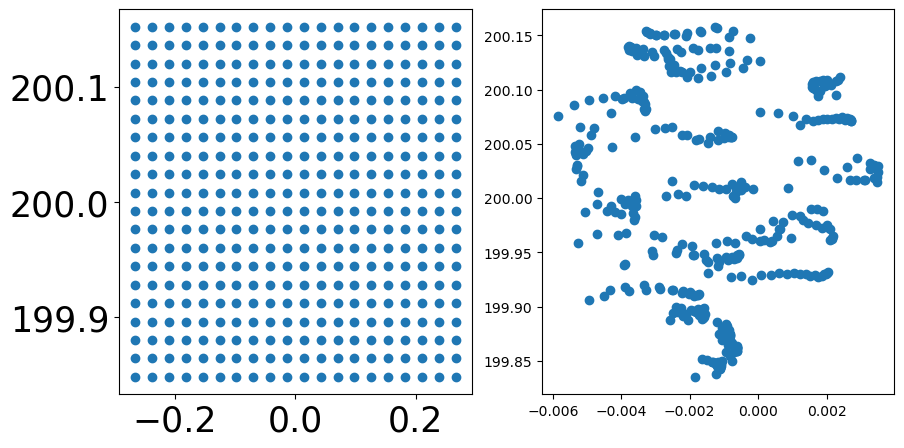

epoch: 2400, train loss: 0.013017775490880013, val loss: 6.004129886627197
epoch: 2401, train loss: 0.013016907498240471, val loss: 6.003785133361816
epoch: 2402, train loss: 0.01301615685224533, val loss: 6.004086971282959
epoch: 2403, train loss: 0.01301619503647089, val loss: 6.004202842712402
epoch: 2404, train loss: 0.013016731478273869, val loss: 6.003724098205566
epoch: 2405, train loss: 0.013016956858336926, val loss: 6.00481653213501
epoch: 2406, train loss: 0.013016571290791035, val loss: 6.003520488739014
epoch: 2407, train loss: 0.01301603764295578, val loss: 6.00505256652832
epoch: 2408, train loss: 0.013015744276344776, val loss: 6.00383996963501
epoch: 2409, train loss: 0.013015718199312687, val loss: 6.004693508148193
epoch: 2410, train loss: 0.013015677221119404, val loss: 6.004515171051025
epoch: 2411, train loss: 0.013015608303248882, val loss: 6.004281044006348
epoch: 2412, train loss: 0.013015594333410263, val loss: 6.004971027374268
epoch: 2413, train loss: 0.0130

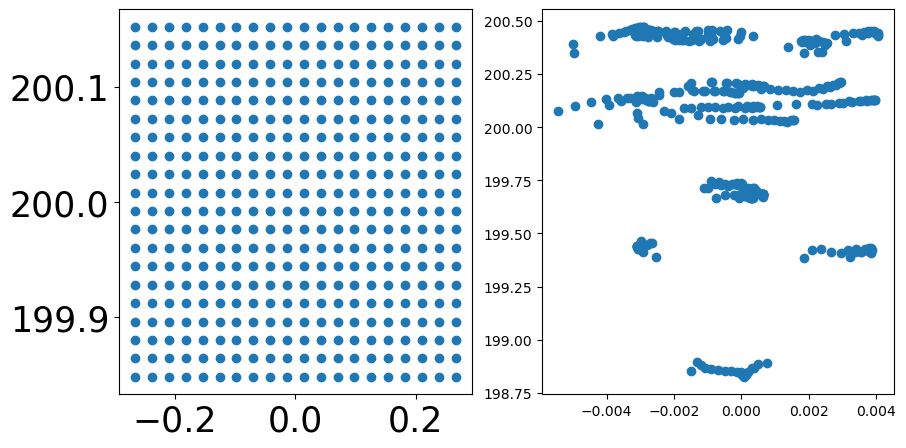

epoch: 2500, train loss: 0.09199607372283936, val loss: 7.139413833618164
epoch: 2501, train loss: 0.04212811216711998, val loss: 7.585667133331299
epoch: 2502, train loss: 0.042751334607601166, val loss: 7.32380485534668
epoch: 2503, train loss: 0.07634437084197998, val loss: 7.280025482177734
epoch: 2504, train loss: 0.05231661722064018, val loss: 7.433437347412109
epoch: 2505, train loss: 0.02718419022858143, val loss: 7.207019329071045
epoch: 2506, train loss: 0.042955432087183, val loss: 7.313819408416748
epoch: 2507, train loss: 0.04358432814478874, val loss: 7.272800922393799
epoch: 2508, train loss: 0.0330331027507782, val loss: 7.186718463897705
epoch: 2509, train loss: 0.034711483865976334, val loss: 7.221169948577881
epoch: 2510, train loss: 0.029560014605522156, val loss: 7.139731407165527
epoch: 2511, train loss: 0.02853322960436344, val loss: 7.147696495056152
epoch: 2512, train loss: 0.034419357776641846, val loss: 7.094557285308838
epoch: 2513, train loss: 0.02354788966

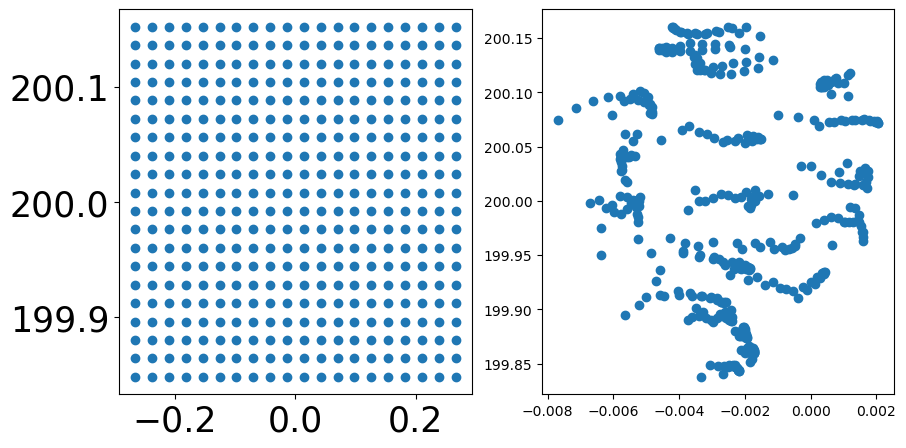

epoch: 2600, train loss: 0.013024721294641495, val loss: 6.935935020446777
epoch: 2601, train loss: 0.013025681488215923, val loss: 6.935842514038086
epoch: 2602, train loss: 0.013047882355749607, val loss: 6.935328006744385
epoch: 2603, train loss: 0.013065810315310955, val loss: 6.935098648071289
epoch: 2604, train loss: 0.013062853366136551, val loss: 6.934756755828857
epoch: 2605, train loss: 0.013046283274888992, val loss: 6.933975696563721
epoch: 2606, train loss: 0.013033724389970303, val loss: 6.934422492980957
epoch: 2607, train loss: 0.013035775162279606, val loss: 6.932825565338135
epoch: 2608, train loss: 0.013050994835793972, val loss: 6.93397331237793
epoch: 2609, train loss: 0.013069593347609043, val loss: 6.932178020477295
epoch: 2610, train loss: 0.013083050027489662, val loss: 6.933133602142334
epoch: 2611, train loss: 0.013093187473714352, val loss: 6.931580543518066
epoch: 2612, train loss: 0.013110251165926456, val loss: 6.932531356811523
epoch: 2613, train loss: 0

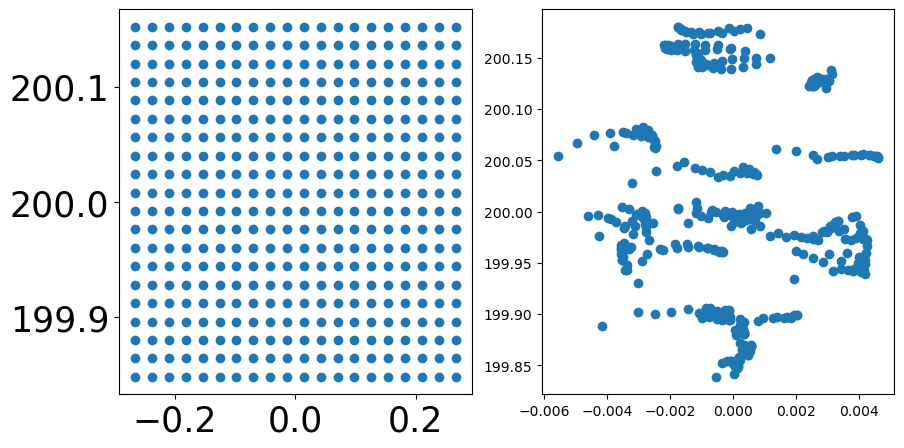

epoch: 2700, train loss: 0.013695046305656433, val loss: 7.0709123611450195
epoch: 2701, train loss: 0.013347486965358257, val loss: 7.109223365783691
epoch: 2702, train loss: 0.01338160689920187, val loss: 7.133554458618164
epoch: 2703, train loss: 0.013516170904040337, val loss: 7.058051586151123
epoch: 2704, train loss: 0.013488087803125381, val loss: 7.151341915130615
epoch: 2705, train loss: 0.013384930789470673, val loss: 7.072157859802246
epoch: 2706, train loss: 0.01332873571664095, val loss: 7.111255168914795
epoch: 2707, train loss: 0.013284146785736084, val loss: 7.11911678314209
epoch: 2708, train loss: 0.013233133591711521, val loss: 7.070055961608887
epoch: 2709, train loss: 0.013239502906799316, val loss: 7.13685417175293
epoch: 2710, train loss: 0.013284317217767239, val loss: 7.0735764503479
epoch: 2711, train loss: 0.013255879282951355, val loss: 7.11112117767334
epoch: 2712, train loss: 0.01314905658364296, val loss: 7.106204032897949
epoch: 2713, train loss: 0.01309

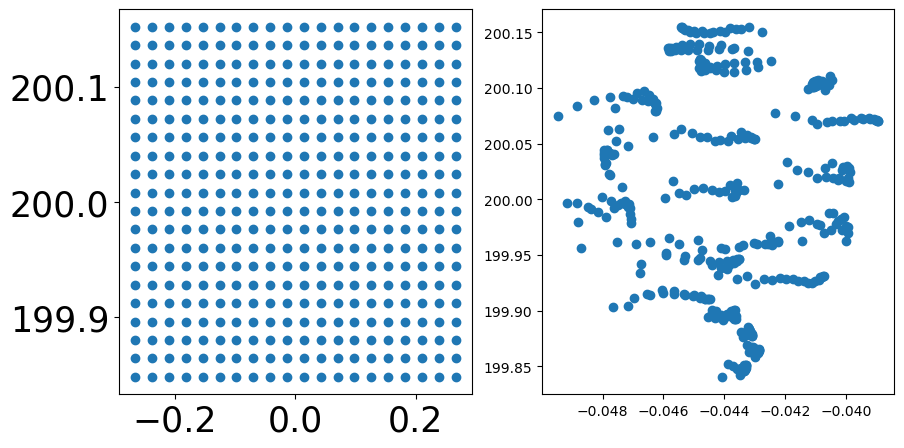

epoch: 2800, train loss: 0.013966846279799938, val loss: 7.038461685180664
epoch: 2801, train loss: 0.013925152830779552, val loss: 7.038074970245361
epoch: 2802, train loss: 0.01342602726072073, val loss: 7.036639213562012
epoch: 2803, train loss: 0.013035431504249573, val loss: 7.0362229347229
epoch: 2804, train loss: 0.013102324679493904, val loss: 7.036159992218018
epoch: 2805, train loss: 0.01342848502099514, val loss: 7.035213470458984
epoch: 2806, train loss: 0.013584096916019917, val loss: 7.035037040710449
epoch: 2807, train loss: 0.013404293917119503, val loss: 7.033518314361572
epoch: 2808, train loss: 0.013111700303852558, val loss: 7.033292293548584
epoch: 2809, train loss: 0.013008098118007183, val loss: 7.032505989074707
epoch: 2810, train loss: 0.013141995295882225, val loss: 7.032140731811523
epoch: 2811, train loss: 0.013307444751262665, val loss: 7.031631946563721
epoch: 2812, train loss: 0.013307609595358372, val loss: 7.030710220336914
epoch: 2813, train loss: 0.01

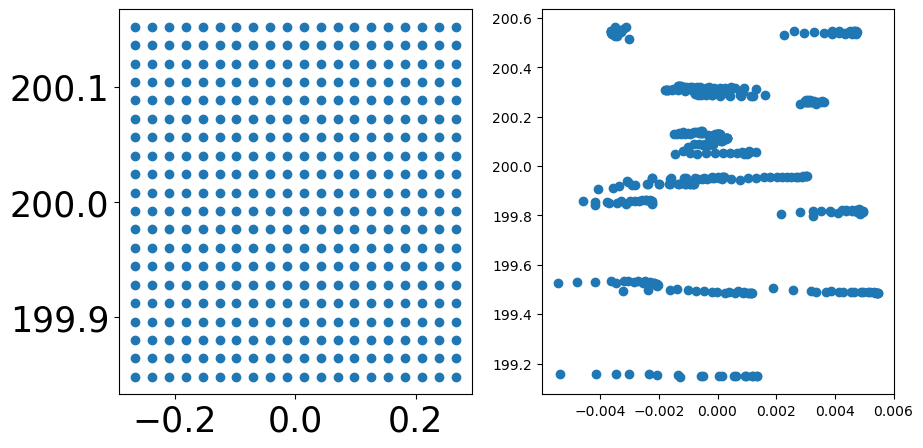

epoch: 2900, train loss: 0.07657620310783386, val loss: 6.470063209533691
epoch: 2901, train loss: 0.1228988841176033, val loss: 7.9665045738220215
epoch: 2902, train loss: 0.2048088014125824, val loss: 6.22869348526001
epoch: 2903, train loss: 0.34105581045150757, val loss: 8.874615669250488
epoch: 2904, train loss: 0.5753241777420044, val loss: 6.082790374755859
epoch: 2905, train loss: 0.9240882396697998, val loss: 10.434572219848633
epoch: 2906, train loss: 1.4486833810806274, val loss: 6.270547866821289
epoch: 2907, train loss: 1.9755282402038574, val loss: 11.547107696533203
epoch: 2908, train loss: 2.409928321838379, val loss: 6.233315467834473
epoch: 2909, train loss: 2.1664063930511475, val loss: 8.827094078063965
epoch: 2910, train loss: 1.3974496126174927, val loss: 5.770889759063721
epoch: 2911, train loss: 0.5223830342292786, val loss: 5.154012203216553
epoch: 2912, train loss: 0.3079773187637329, val loss: 7.441395282745361
epoch: 2913, train loss: 0.7123326063156128, val

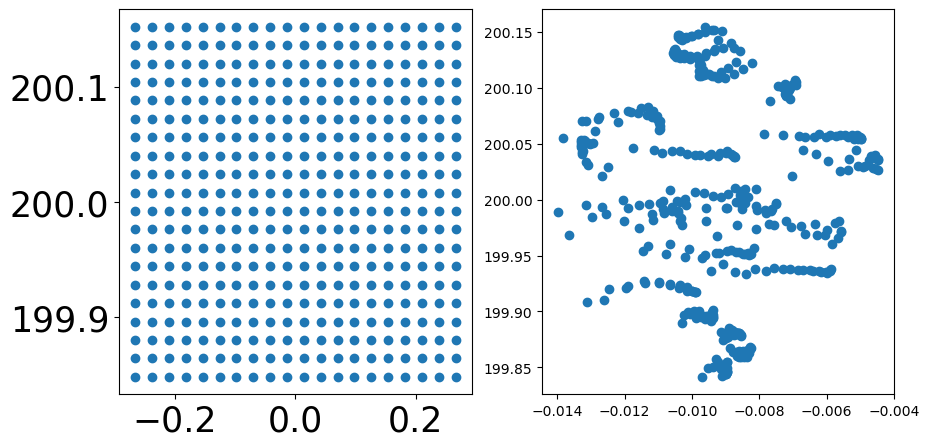

epoch: 3000, train loss: 0.013108085840940475, val loss: 4.060479164123535
epoch: 3001, train loss: 0.01312057301402092, val loss: 4.074323654174805
epoch: 3002, train loss: 0.013146476820111275, val loss: 4.059253215789795
epoch: 3003, train loss: 0.013182499445974827, val loss: 4.066077709197998
epoch: 3004, train loss: 0.013262072578072548, val loss: 4.0730085372924805
epoch: 3005, train loss: 0.013399721123278141, val loss: 4.0586466789245605
epoch: 3006, train loss: 0.013587594032287598, val loss: 4.071478843688965
epoch: 3007, train loss: 0.01389196328818798, val loss: 4.068122386932373
epoch: 3008, train loss: 0.014401745051145554, val loss: 4.065542697906494
epoch: 3009, train loss: 0.01516180019825697, val loss: 4.071514129638672
epoch: 3010, train loss: 0.0162732545286417, val loss: 4.073226451873779
epoch: 3011, train loss: 0.017890524119138718, val loss: 4.0704193115234375
epoch: 3012, train loss: 0.020023737102746964, val loss: 4.078287124633789
epoch: 3013, train loss: 0.

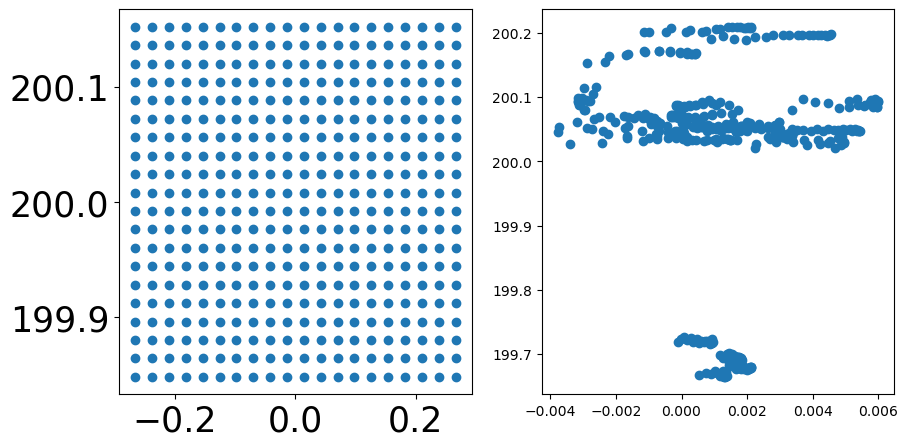

epoch: 3100, train loss: 0.022470740601420403, val loss: 4.038726806640625
epoch: 3101, train loss: 0.029523789882659912, val loss: 4.187201499938965
epoch: 3102, train loss: 0.04192458465695381, val loss: 4.032543659210205
epoch: 3103, train loss: 0.06393741816282272, val loss: 4.311326026916504
epoch: 3104, train loss: 0.10261768102645874, val loss: 4.070976257324219
epoch: 3105, train loss: 0.17107611894607544, val loss: 4.610391139984131
epoch: 3106, train loss: 0.28839412331581116, val loss: 4.280886650085449
epoch: 3107, train loss: 0.48793378472328186, val loss: 5.30207633972168
epoch: 3108, train loss: 0.7969285249710083, val loss: 4.910176753997803
epoch: 3109, train loss: 1.242899775505066, val loss: 6.420332908630371
epoch: 3110, train loss: 1.7170058488845825, val loss: 5.723408222198486
epoch: 3111, train loss: 2.0281949043273926, val loss: 6.426973819732666
epoch: 3112, train loss: 1.796580195426941, val loss: 5.327669143676758
epoch: 3113, train loss: 1.1053314208984375,

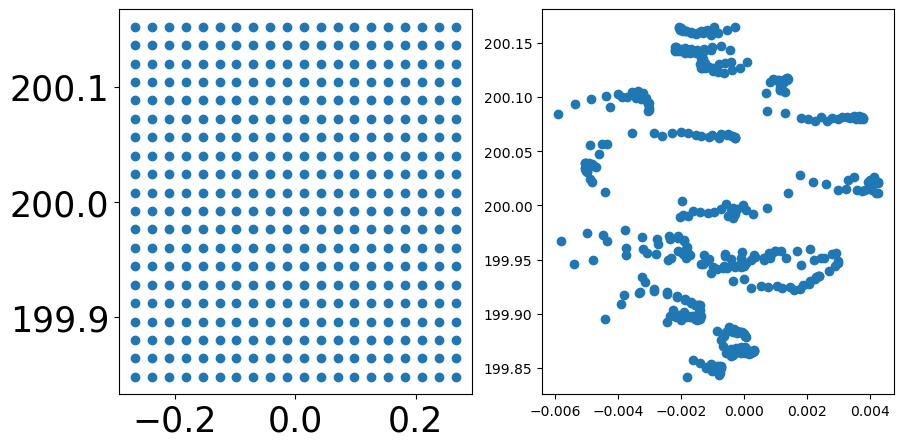

epoch: 3200, train loss: 0.01305760070681572, val loss: 5.057135581970215
epoch: 3201, train loss: 0.013086545281112194, val loss: 5.095576763153076
epoch: 3202, train loss: 0.013097335584461689, val loss: 5.065911293029785
epoch: 3203, train loss: 0.013034369796514511, val loss: 5.070679664611816
epoch: 3204, train loss: 0.013026882894337177, val loss: 5.087745189666748
epoch: 3205, train loss: 0.013060502707958221, val loss: 5.062501907348633
epoch: 3206, train loss: 0.013038367964327335, val loss: 5.077977180480957
epoch: 3207, train loss: 0.01301668118685484, val loss: 5.0778045654296875
epoch: 3208, train loss: 0.013047492131590843, val loss: 5.067881107330322
epoch: 3209, train loss: 0.013059641234576702, val loss: 5.073675155639648
epoch: 3210, train loss: 0.013038862496614456, val loss: 5.0794501304626465
epoch: 3211, train loss: 0.013046805746853352, val loss: 5.061605930328369
epoch: 3212, train loss: 0.013070291839540005, val loss: 5.0808587074279785
epoch: 3213, train loss:

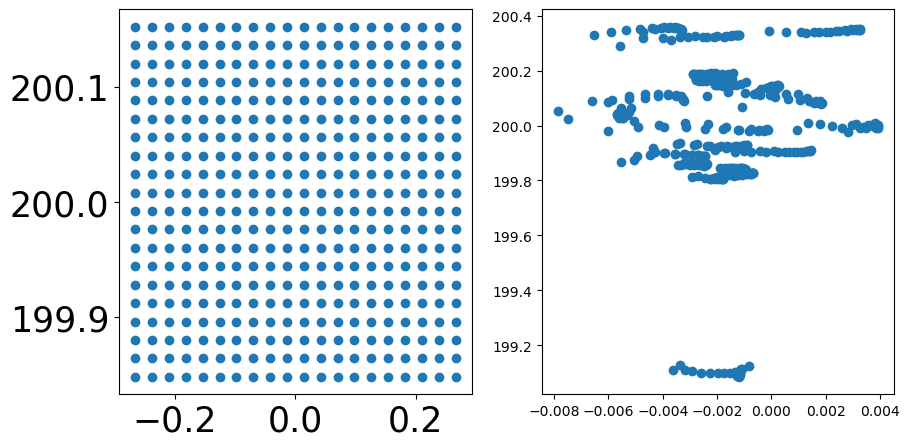

epoch: 3300, train loss: 0.039841294288635254, val loss: 4.6197190284729
epoch: 3301, train loss: 0.018883833661675453, val loss: 4.730585098266602
epoch: 3302, train loss: 0.02131824381649494, val loss: 4.650969505310059
epoch: 3303, train loss: 0.03392256051301956, val loss: 4.616877555847168
epoch: 3304, train loss: 0.03586815297603607, val loss: 4.753833293914795
epoch: 3305, train loss: 0.02914322353899479, val loss: 4.474642753601074
epoch: 3306, train loss: 0.02388353832066059, val loss: 4.752901554107666
epoch: 3307, train loss: 0.021941203624010086, val loss: 4.55563497543335
epoch: 3308, train loss: 0.020150018855929375, val loss: 4.560369968414307
epoch: 3309, train loss: 0.02030964381992817, val loss: 4.729522705078125
epoch: 3310, train loss: 0.023411445319652557, val loss: 4.439268589019775
epoch: 3311, train loss: 0.02397681586444378, val loss: 4.721028804779053
epoch: 3312, train loss: 0.01930048130452633, val loss: 4.545003414154053
epoch: 3313, train loss: 0.015339023

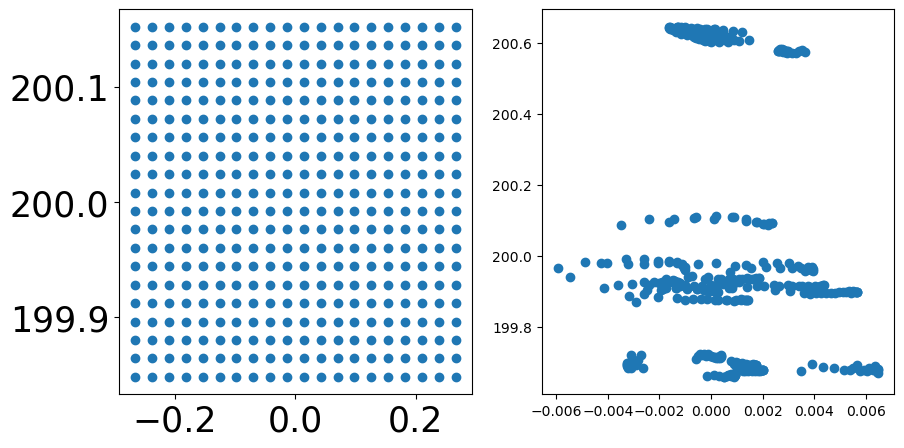

epoch: 3400, train loss: 0.04874299839138985, val loss: 5.007823944091797
epoch: 3401, train loss: 0.05561438575387001, val loss: 4.771722793579102
epoch: 3402, train loss: 0.03468076512217522, val loss: 4.9825239181518555
epoch: 3403, train loss: 0.017617415636777878, val loss: 4.818329811096191
epoch: 3404, train loss: 0.024234041571617126, val loss: 4.917168617248535
epoch: 3405, train loss: 0.037951625883579254, val loss: 4.9074201583862305
epoch: 3406, train loss: 0.03583962842822075, val loss: 4.836470127105713
epoch: 3407, train loss: 0.021384811028838158, val loss: 4.9117536544799805
epoch: 3408, train loss: 0.014651848934590816, val loss: 4.848991394042969
epoch: 3409, train loss: 0.021535396575927734, val loss: 4.903913497924805
epoch: 3410, train loss: 0.028632795438170433, val loss: 4.877856731414795
epoch: 3411, train loss: 0.025391187518835068, val loss: 4.877909183502197
epoch: 3412, train loss: 0.017517829313874245, val loss: 4.859259128570557
epoch: 3413, train loss: 0

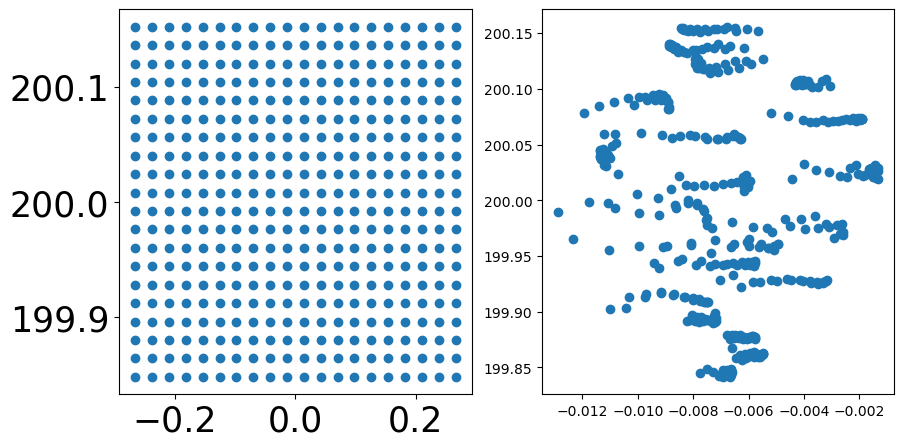

epoch: 3500, train loss: 0.013020274229347706, val loss: 4.857069492340088
epoch: 3501, train loss: 0.013003392145037651, val loss: 4.854547500610352
epoch: 3502, train loss: 0.012999381870031357, val loss: 4.857559680938721
epoch: 3503, train loss: 0.013007213361561298, val loss: 4.852957725524902
epoch: 3504, train loss: 0.013019237667322159, val loss: 4.858450889587402
epoch: 3505, train loss: 0.013027009554207325, val loss: 4.851229667663574
epoch: 3506, train loss: 0.013026449829339981, val loss: 4.859114170074463
epoch: 3507, train loss: 0.013019421137869358, val loss: 4.849802494049072
epoch: 3508, train loss: 0.01301165297627449, val loss: 4.859508991241455
epoch: 3509, train loss: 0.01300874724984169, val loss: 4.848419189453125
epoch: 3510, train loss: 0.013013130985200405, val loss: 4.860263347625732
epoch: 3511, train loss: 0.013023559004068375, val loss: 4.846405982971191
epoch: 3512, train loss: 0.013036848977208138, val loss: 4.862076282501221
epoch: 3513, train loss: 0.

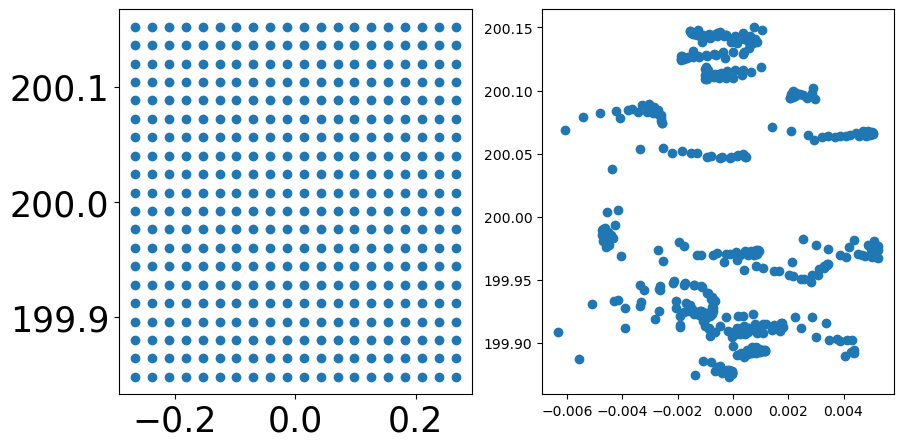

epoch: 3600, train loss: 0.01402912475168705, val loss: 4.405998706817627
epoch: 3601, train loss: 0.0142385708168149, val loss: 4.4801249504089355
epoch: 3602, train loss: 0.013569187372922897, val loss: 4.422140121459961
epoch: 3603, train loss: 0.013135707005858421, val loss: 4.434028625488281
epoch: 3604, train loss: 0.013432183302938938, val loss: 4.464010715484619
epoch: 3605, train loss: 0.013760091736912727, val loss: 4.404662609100342
epoch: 3606, train loss: 0.013570666313171387, val loss: 4.460385799407959
epoch: 3607, train loss: 0.013210868462920189, val loss: 4.426902770996094
epoch: 3608, train loss: 0.01317652314901352, val loss: 4.420133590698242
epoch: 3609, train loss: 0.013371695764362812, val loss: 4.459560871124268
epoch: 3610, train loss: 0.013419579714536667, val loss: 4.404088497161865
epoch: 3611, train loss: 0.013259492814540863, val loss: 4.450014114379883
epoch: 3612, train loss: 0.013123823329806328, val loss: 4.430351734161377
epoch: 3613, train loss: 0.0

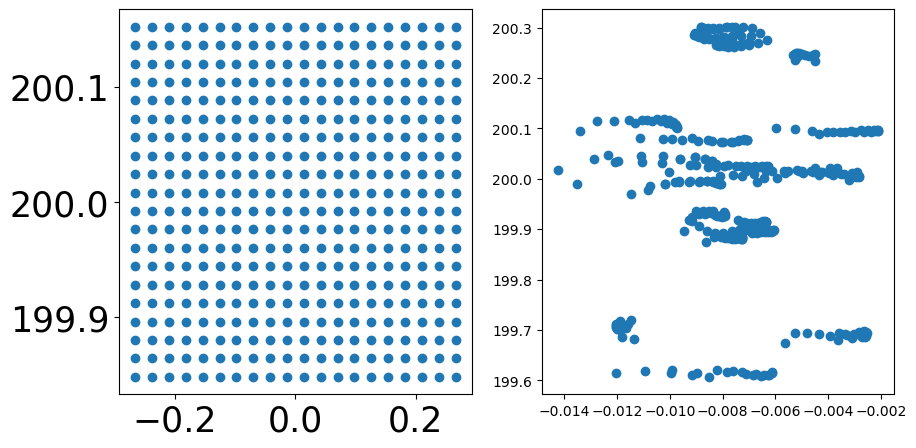

epoch: 3700, train loss: 0.024738183245062828, val loss: 4.364170551300049
epoch: 3701, train loss: 0.02376035787165165, val loss: 4.414568901062012
epoch: 3702, train loss: 0.02380300499498844, val loss: 4.521044731140137
epoch: 3703, train loss: 0.022033486515283585, val loss: 4.29815673828125
epoch: 3704, train loss: 0.018933190032839775, val loss: 4.528584957122803
epoch: 3705, train loss: 0.01726960949599743, val loss: 4.376699924468994
epoch: 3706, train loss: 0.017929784953594208, val loss: 4.389439582824707
epoch: 3707, train loss: 0.01918489672243595, val loss: 4.5233049392700195
epoch: 3708, train loss: 0.019158920273184776, val loss: 4.3038010597229
epoch: 3709, train loss: 0.01782749779522419, val loss: 4.51473331451416
epoch: 3710, train loss: 0.016465213149785995, val loss: 4.382250785827637
epoch: 3711, train loss: 0.016020692884922028, val loss: 4.3839111328125
epoch: 3712, train loss: 0.01636076346039772, val loss: 4.504175186157227
epoch: 3713, train loss: 0.016598103

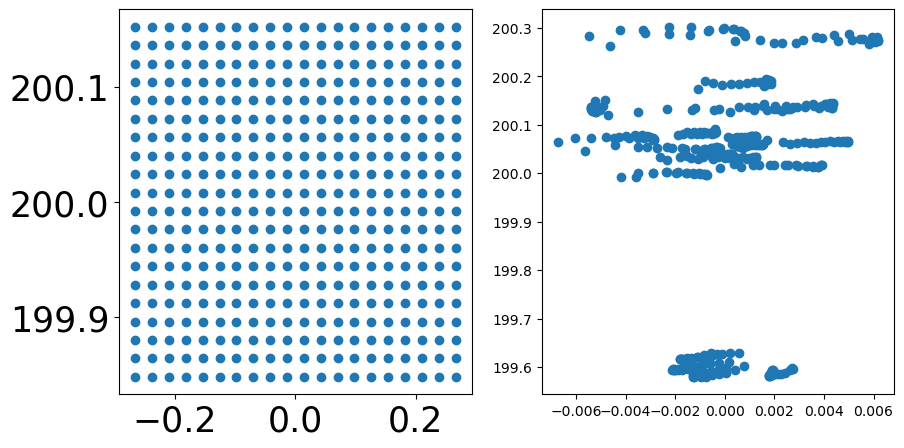

epoch: 3800, train loss: 0.051826562732458115, val loss: 4.4911651611328125
epoch: 3801, train loss: 0.0733182355761528, val loss: 4.457184791564941
epoch: 3802, train loss: 0.10708640515804291, val loss: 4.595075607299805
epoch: 3803, train loss: 0.15848331153392792, val loss: 4.566802501678467
epoch: 3804, train loss: 0.23703895509243011, val loss: 4.817056655883789
epoch: 3805, train loss: 0.348779559135437, val loss: 4.801429748535156
epoch: 3806, train loss: 0.503751277923584, val loss: 5.203330039978027
epoch: 3807, train loss: 0.6836839914321899, val loss: 5.113179683685303
epoch: 3808, train loss: 0.8637374043464661, val loss: 5.538112640380859
epoch: 3809, train loss: 0.944803774356842, val loss: 5.051717758178711
epoch: 3810, train loss: 0.8652278184890747, val loss: 5.247702598571777
epoch: 3811, train loss: 0.5901973247528076, val loss: 4.3973212242126465
epoch: 3812, train loss: 0.26039570569992065, val loss: 4.708375453948975
epoch: 3813, train loss: 0.06761912256479263, 

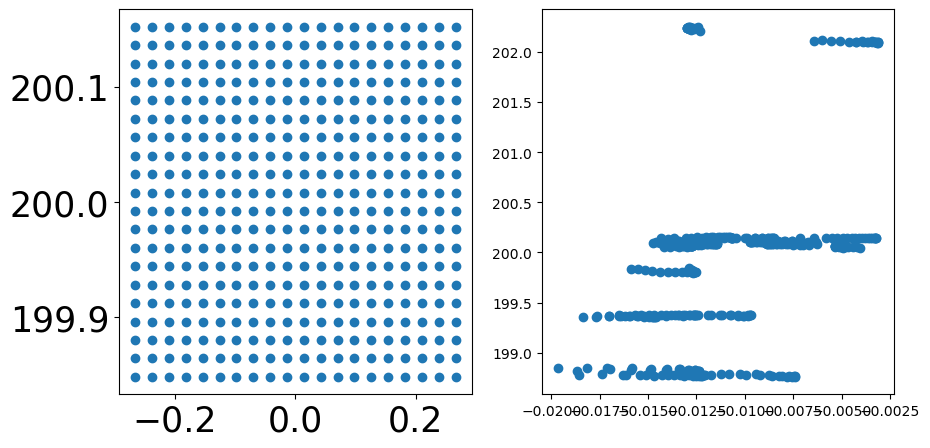

epoch: 3900, train loss: 0.3764708638191223, val loss: 4.558141231536865
epoch: 3901, train loss: 0.36281681060791016, val loss: 4.915155410766602
epoch: 3902, train loss: 0.30111250281333923, val loss: 4.428519248962402
epoch: 3903, train loss: 0.21753652393817902, val loss: 4.704315662384033
epoch: 3904, train loss: 0.13805817067623138, val loss: 4.396267890930176
epoch: 3905, train loss: 0.08930805325508118, val loss: 4.500295162200928
epoch: 3906, train loss: 0.0800778716802597, val loss: 4.596136093139648
epoch: 3907, train loss: 0.09708214551210403, val loss: 4.334453105926514
epoch: 3908, train loss: 0.11891036480665207, val loss: 4.861988544464111
epoch: 3909, train loss: 0.12728455662727356, val loss: 4.1508965492248535
epoch: 3910, train loss: 0.12063989043235779, val loss: 4.98684024810791
epoch: 3911, train loss: 0.1064341813325882, val loss: 4.047852516174316
epoch: 3912, train loss: 0.09198640286922455, val loss: 4.9066901206970215
epoch: 3913, train loss: 0.0803419277071

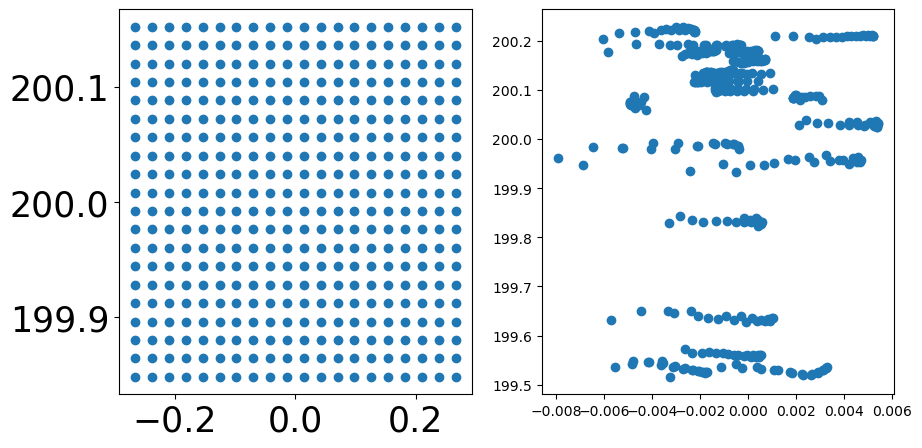

epoch: 4000, train loss: 0.037604283541440964, val loss: 4.681577205657959
epoch: 4001, train loss: 0.041298653930425644, val loss: 4.73317289352417
epoch: 4002, train loss: 0.036852169781923294, val loss: 4.622842788696289
epoch: 4003, train loss: 0.02760354056954384, val loss: 4.778392791748047
epoch: 4004, train loss: 0.01943117193877697, val loss: 4.600882053375244
epoch: 4005, train loss: 0.016133885830640793, val loss: 4.769725799560547
epoch: 4006, train loss: 0.017783334478735924, val loss: 4.660824298858643
epoch: 4007, train loss: 0.021478228271007538, val loss: 4.700191020965576
epoch: 4008, train loss: 0.02392747811973095, val loss: 4.757438659667969
epoch: 4009, train loss: 0.023632533848285675, val loss: 4.615504264831543
epoch: 4010, train loss: 0.02117651142179966, val loss: 4.821467876434326
epoch: 4011, train loss: 0.018379976972937584, val loss: 4.582068920135498
epoch: 4012, train loss: 0.016627252101898193, val loss: 4.814216613769531
epoch: 4013, train loss: 0.016

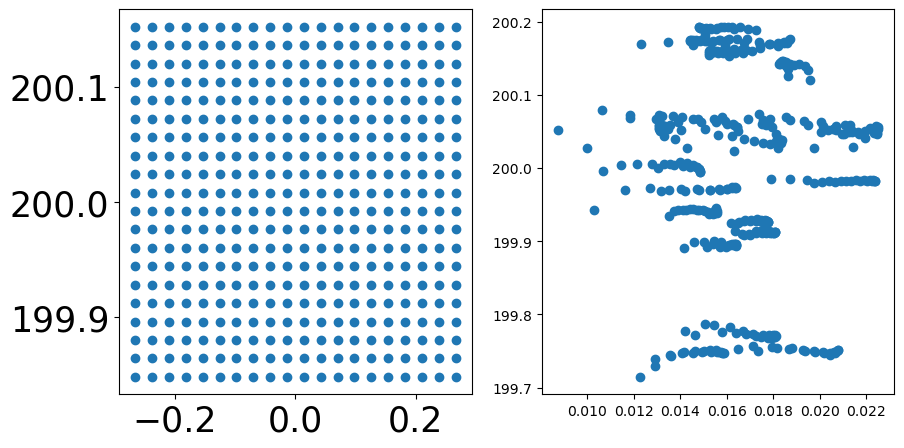

epoch: 4100, train loss: 0.01771453022956848, val loss: 4.017329692840576
epoch: 4101, train loss: 0.020409289747476578, val loss: 3.9171862602233887
epoch: 4102, train loss: 0.026853498071432114, val loss: 3.899634599685669
epoch: 4103, train loss: 0.027602192014455795, val loss: 3.9963433742523193
epoch: 4104, train loss: 0.0231173075735569, val loss: 3.8155388832092285
epoch: 4105, train loss: 0.020202379673719406, val loss: 4.033339977264404
epoch: 4106, train loss: 0.020954638719558716, val loss: 3.8241043090820312
epoch: 4107, train loss: 0.0214416291564703, val loss: 3.9623401165008545
epoch: 4108, train loss: 0.019692957401275635, val loss: 3.8965373039245605
epoch: 4109, train loss: 0.01818043924868107, val loss: 3.8939974308013916
epoch: 4110, train loss: 0.01908869296312332, val loss: 3.9622068405151367
epoch: 4111, train loss: 0.0203100573271513, val loss: 3.8765857219696045
epoch: 4112, train loss: 0.018998047336935997, val loss: 3.9238905906677246
epoch: 4113, train loss:

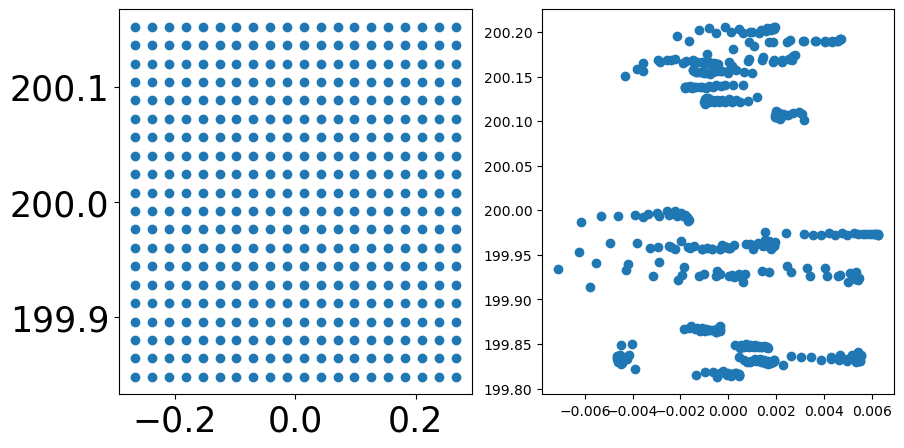

epoch: 4200, train loss: 0.0219876766204834, val loss: 3.904083728790283
epoch: 4201, train loss: 0.02468862570822239, val loss: 4.0574259757995605
epoch: 4202, train loss: 0.02837732806801796, val loss: 3.8888137340545654
epoch: 4203, train loss: 0.03347759693861008, val loss: 4.107728004455566
epoch: 4204, train loss: 0.04038475826382637, val loss: 3.871913433074951
epoch: 4205, train loss: 0.049964454025030136, val loss: 4.184897422790527
epoch: 4206, train loss: 0.06286673992872238, val loss: 3.8593239784240723
epoch: 4207, train loss: 0.08074765652418137, val loss: 4.302073001861572
epoch: 4208, train loss: 0.10431154072284698, val loss: 3.860764265060425
epoch: 4209, train loss: 0.13624748587608337, val loss: 4.475677013397217
epoch: 4210, train loss: 0.17586033046245575, val loss: 3.896317720413208
epoch: 4211, train loss: 0.22600707411766052, val loss: 4.706778049468994
epoch: 4212, train loss: 0.2796107232570648, val loss: 3.9771270751953125
epoch: 4213, train loss: 0.33601263

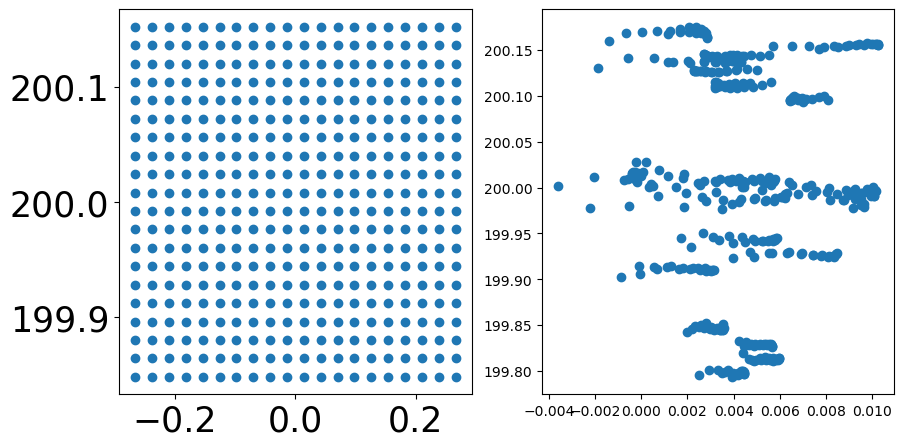

epoch: 4300, train loss: 0.013808030635118484, val loss: 4.752217769622803
epoch: 4301, train loss: 0.013912376947700977, val loss: 4.714285373687744
epoch: 4302, train loss: 0.013871638104319572, val loss: 4.745505332946777
epoch: 4303, train loss: 0.013717584311962128, val loss: 4.715977668762207
epoch: 4304, train loss: 0.013544551096856594, val loss: 4.7377448081970215
epoch: 4305, train loss: 0.013433415442705154, val loss: 4.7182230949401855
epoch: 4306, train loss: 0.013398272916674614, val loss: 4.730495452880859
epoch: 4307, train loss: 0.013393523171544075, val loss: 4.720327854156494
epoch: 4308, train loss: 0.013362783938646317, val loss: 4.724677562713623
epoch: 4309, train loss: 0.01328295562416315, val loss: 4.721467971801758
epoch: 4310, train loss: 0.013175404630601406, val loss: 4.720151424407959
epoch: 4311, train loss: 0.013082885183393955, val loss: 4.722266674041748
epoch: 4312, train loss: 0.013035974465310574, val loss: 4.717609882354736
epoch: 4313, train loss:

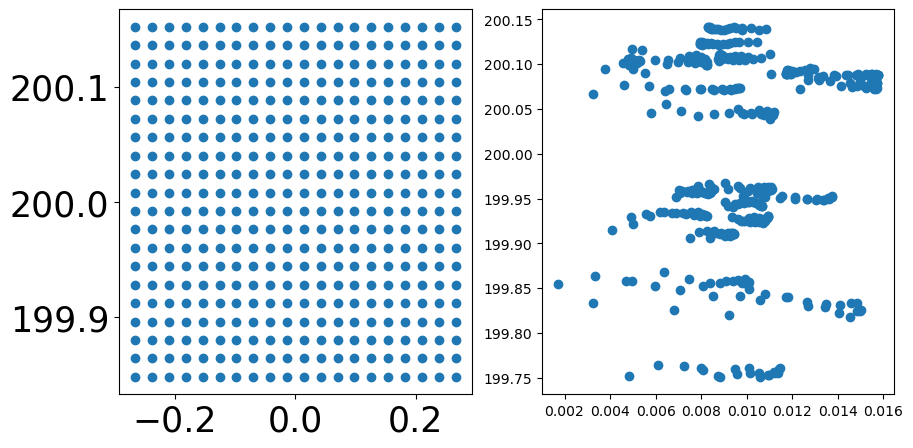

epoch: 4400, train loss: 0.01569926179945469, val loss: 3.9014575481414795
epoch: 4401, train loss: 0.01696457341313362, val loss: 4.047300815582275
epoch: 4402, train loss: 0.016800347715616226, val loss: 3.9158599376678467
epoch: 4403, train loss: 0.015254189260303974, val loss: 3.9963879585266113
epoch: 4404, train loss: 0.01397829968482256, val loss: 3.9631197452545166
epoch: 4405, train loss: 0.01401140633970499, val loss: 3.941099166870117
epoch: 4406, train loss: 0.014764964580535889, val loss: 3.9983227252960205
epoch: 4407, train loss: 0.015023233368992805, val loss: 3.9159820079803467
epoch: 4408, train loss: 0.01445077545940876, val loss: 3.9937641620635986
epoch: 4409, train loss: 0.013767072930932045, val loss: 3.9241063594818115
epoch: 4410, train loss: 0.013672604225575924, val loss: 3.969956636428833
epoch: 4411, train loss: 0.014038655906915665, val loss: 3.94242262840271
epoch: 4412, train loss: 0.01421432476490736, val loss: 3.9502336978912354
epoch: 4413, train loss

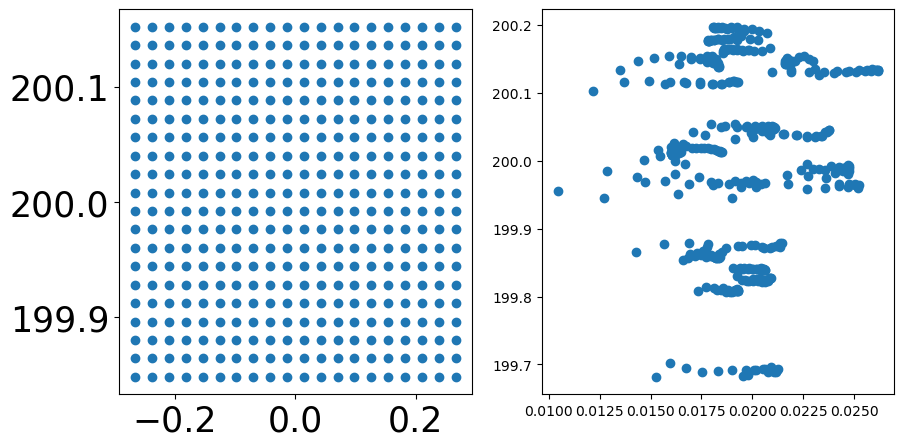

epoch: 4500, train loss: 0.017376400530338287, val loss: 4.25161600112915
epoch: 4501, train loss: 0.014910859987139702, val loss: 4.357148170471191
epoch: 4502, train loss: 0.014311902225017548, val loss: 4.29272985458374
epoch: 4503, train loss: 0.015838464722037315, val loss: 4.322963237762451
epoch: 4504, train loss: 0.016812337562441826, val loss: 4.29124641418457
epoch: 4505, train loss: 0.015979774296283722, val loss: 4.342111110687256
epoch: 4506, train loss: 0.014886590652167797, val loss: 4.2593302726745605
epoch: 4507, train loss: 0.015104427002370358, val loss: 4.369783401489258
epoch: 4508, train loss: 0.016005970537662506, val loss: 4.247833251953125
epoch: 4509, train loss: 0.016217399388551712, val loss: 4.367771625518799
epoch: 4510, train loss: 0.015812383964657784, val loss: 4.259505748748779
epoch: 4511, train loss: 0.01588708534836769, val loss: 4.36225700378418
epoch: 4512, train loss: 0.016760647296905518, val loss: 4.249194622039795
epoch: 4513, train loss: 0.01

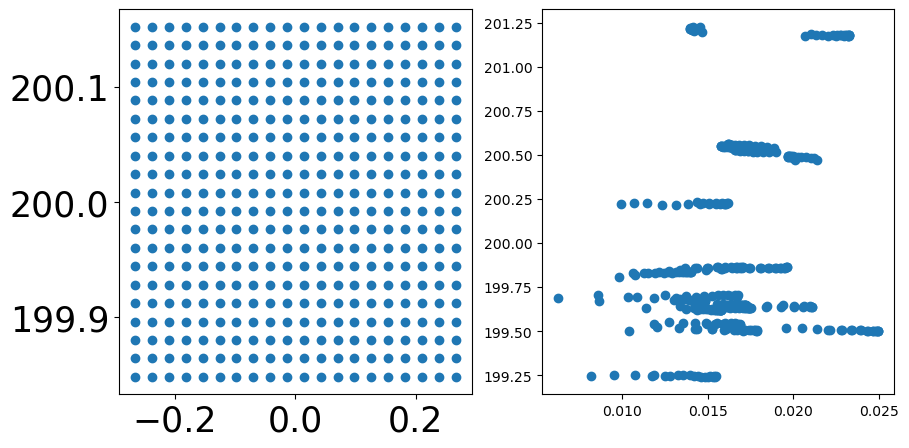

epoch: 4600, train loss: 0.14440695941448212, val loss: 4.1774210929870605
epoch: 4601, train loss: 0.1373419463634491, val loss: 4.291214942932129
epoch: 4602, train loss: 0.11514432728290558, val loss: 4.165454864501953
epoch: 4603, train loss: 0.08349282294511795, val loss: 4.196256160736084
epoch: 4604, train loss: 0.050353821367025375, val loss: 4.143402576446533
epoch: 4605, train loss: 0.025701817125082016, val loss: 4.137397766113281
epoch: 4606, train loss: 0.015202701091766357, val loss: 4.165311336517334
epoch: 4607, train loss: 0.018586330115795135, val loss: 4.134545803070068
epoch: 4608, train loss: 0.030243754386901855, val loss: 4.209950923919678
epoch: 4609, train loss: 0.04247158020734787, val loss: 4.145795822143555
epoch: 4610, train loss: 0.04913359880447388, val loss: 4.2275214195251465
epoch: 4611, train loss: 0.04779095947742462, val loss: 4.137601852416992
epoch: 4612, train loss: 0.04035508632659912, val loss: 4.208240032196045
epoch: 4613, train loss: 0.03066

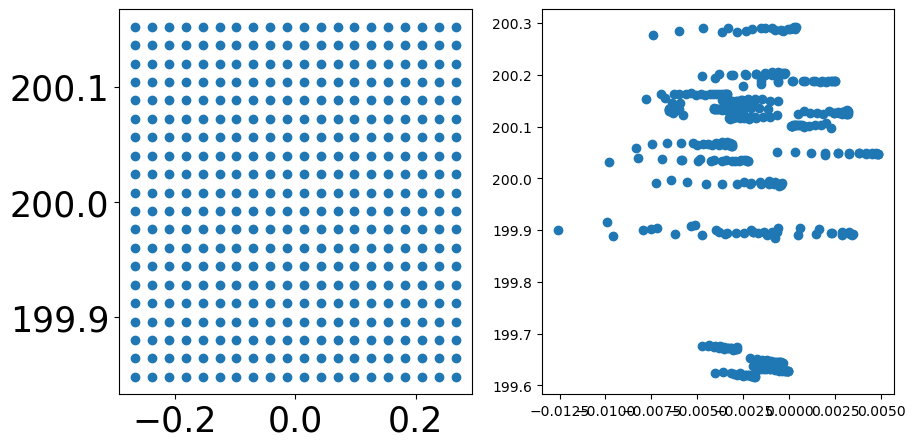

epoch: 4700, train loss: 0.026727063581347466, val loss: 4.179492473602295
epoch: 4701, train loss: 0.03373312950134277, val loss: 4.198380947113037
epoch: 4702, train loss: 0.04444599896669388, val loss: 4.207021236419678
epoch: 4703, train loss: 0.061093319207429886, val loss: 4.252190589904785
epoch: 4704, train loss: 0.08634915947914124, val loss: 4.275245666503906
epoch: 4705, train loss: 0.12533879280090332, val loss: 4.375255584716797
epoch: 4706, train loss: 0.18216854333877563, val loss: 4.432043075561523
epoch: 4707, train loss: 0.2660711705684662, val loss: 4.631160259246826
epoch: 4708, train loss: 0.37441232800483704, val loss: 4.729406833648682
epoch: 4709, train loss: 0.5118606686592102, val loss: 5.039942264556885
epoch: 4710, train loss: 0.6325558423995972, val loss: 5.0649518966674805
epoch: 4711, train loss: 0.7107877731323242, val loss: 5.386542320251465
epoch: 4712, train loss: 0.6484309434890747, val loss: 5.044449806213379
epoch: 4713, train loss: 0.4693748652935

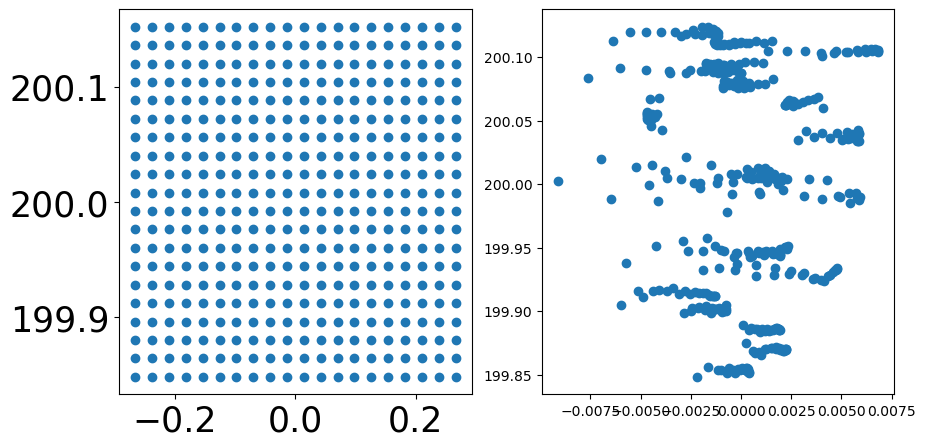

epoch: 4800, train loss: 0.0132244061678648, val loss: 4.844091892242432
epoch: 4801, train loss: 0.013144407421350479, val loss: 4.8314714431762695
epoch: 4802, train loss: 0.013101164251565933, val loss: 4.848777770996094
epoch: 4803, train loss: 0.013058924116194248, val loss: 4.832329750061035
epoch: 4804, train loss: 0.013004759326577187, val loss: 4.838040351867676
epoch: 4805, train loss: 0.01296822540462017, val loss: 4.84219217300415
epoch: 4806, train loss: 0.012962954118847847, val loss: 4.8288655281066895
epoch: 4807, train loss: 0.012966971844434738, val loss: 4.842715263366699
epoch: 4808, train loss: 0.012966196052730083, val loss: 4.831303596496582
epoch: 4809, train loss: 0.01297245267778635, val loss: 4.834559440612793
epoch: 4810, train loss: 0.012991749681532383, val loss: 4.834432125091553
epoch: 4811, train loss: 0.013009903021156788, val loss: 4.831941604614258
epoch: 4812, train loss: 0.013018452562391758, val loss: 4.829812049865723
epoch: 4813, train loss: 0.0

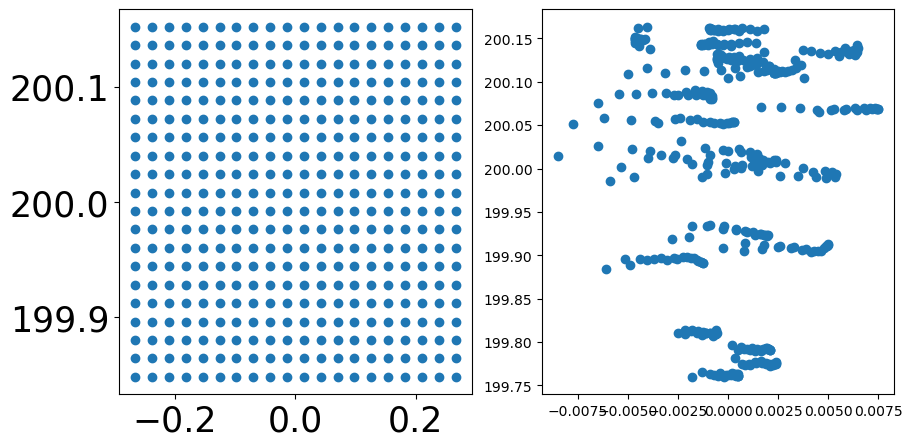

epoch: 4900, train loss: 0.014699297957122326, val loss: 4.392847061157227
epoch: 4901, train loss: 0.014628803357481956, val loss: 4.357365608215332
epoch: 4902, train loss: 0.013520905748009682, val loss: 4.342850685119629
epoch: 4903, train loss: 0.013273224234580994, val loss: 4.391018390655518
epoch: 4904, train loss: 0.014014043845236301, val loss: 4.327332496643066
epoch: 4905, train loss: 0.014191566035151482, val loss: 4.384284019470215
epoch: 4906, train loss: 0.013681518845260143, val loss: 4.343839168548584
epoch: 4907, train loss: 0.01362578570842743, val loss: 4.3770623207092285
epoch: 4908, train loss: 0.014016826637089252, val loss: 4.337784767150879
epoch: 4909, train loss: 0.01391691341996193, val loss: 4.39456844329834
epoch: 4910, train loss: 0.013399171642959118, val loss: 4.317416667938232
epoch: 4911, train loss: 0.013277093879878521, val loss: 4.40438985824585
epoch: 4912, train loss: 0.013500387780368328, val loss: 4.329802989959717
epoch: 4913, train loss: 0.0

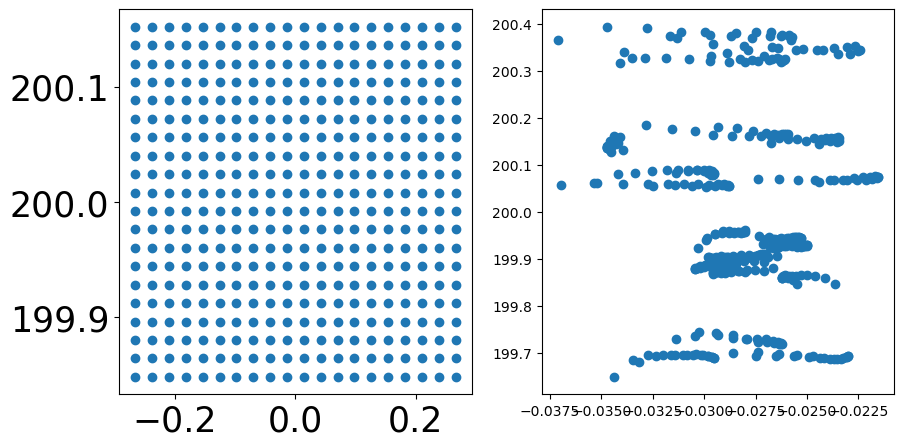

epoch: 5000, train loss: 0.03494306653738022, val loss: 4.2996063232421875
epoch: 5001, train loss: 0.07434311509132385, val loss: 3.8873727321624756
epoch: 5002, train loss: 0.08036284893751144, val loss: 4.229182720184326
epoch: 5003, train loss: 0.045202646404504776, val loss: 3.886204957962036
epoch: 5004, train loss: 0.019148685038089752, val loss: 4.082269191741943
epoch: 5005, train loss: 0.030054334551095963, val loss: 4.009463787078857
epoch: 5006, train loss: 0.04851612076163292, val loss: 3.9980762004852295
epoch: 5007, train loss: 0.041411109268665314, val loss: 4.023674964904785
epoch: 5008, train loss: 0.020338527858257294, val loss: 3.936326742172241
epoch: 5009, train loss: 0.016762351617217064, val loss: 4.042363166809082
epoch: 5010, train loss: 0.03090888448059559, val loss: 3.947906732559204
epoch: 5011, train loss: 0.036887601017951965, val loss: 4.058339595794678
epoch: 5012, train loss: 0.02622227929532528, val loss: 3.9123716354370117
epoch: 5013, train loss: 0.

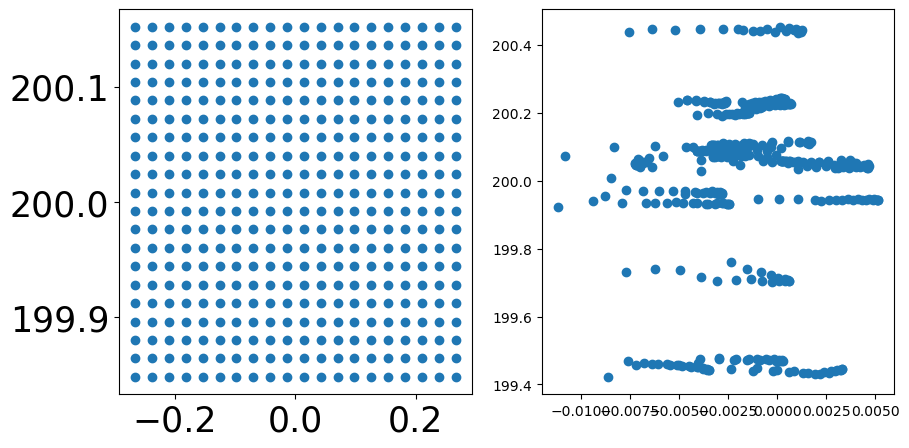

epoch: 5100, train loss: 0.050158970057964325, val loss: 3.3956472873687744
epoch: 5101, train loss: 0.026706185191869736, val loss: 3.5690605640411377
epoch: 5102, train loss: 0.030595993623137474, val loss: 3.2465322017669678
epoch: 5103, train loss: 0.04728686809539795, val loss: 3.5783238410949707
epoch: 5104, train loss: 0.05515720695257187, val loss: 3.3202085494995117
epoch: 5105, train loss: 0.048319101333618164, val loss: 3.3680272102355957
epoch: 5106, train loss: 0.03694016486406326, val loss: 3.4807283878326416
epoch: 5107, train loss: 0.03377608582377434, val loss: 3.2218525409698486
epoch: 5108, train loss: 0.04050511121749878, val loss: 3.544558048248291
epoch: 5109, train loss: 0.049720052629709244, val loss: 3.2457189559936523
epoch: 5110, train loss: 0.05487774312496185, val loss: 3.4482662677764893
epoch: 5111, train loss: 0.057136170566082, val loss: 3.3440868854522705
epoch: 5112, train loss: 0.060974109917879105, val loss: 3.3878543376922607
epoch: 5113, train los

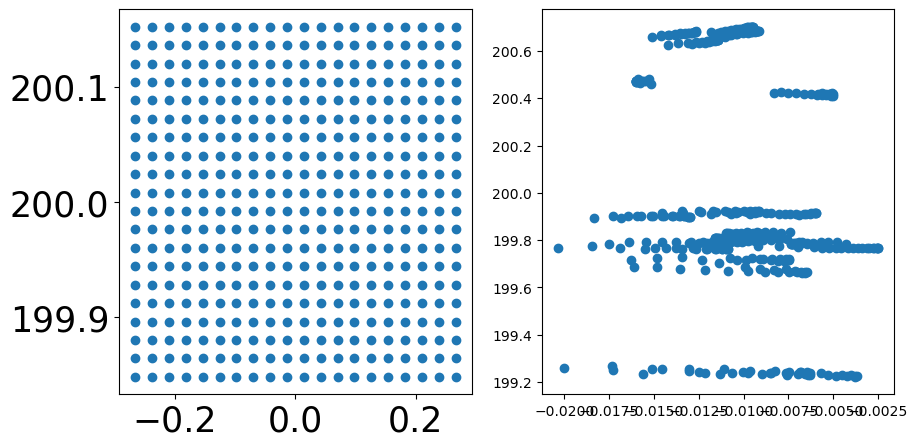

epoch: 5200, train loss: 0.13445627689361572, val loss: 3.4163658618927
epoch: 5201, train loss: 0.1852755844593048, val loss: 4.009722709655762
epoch: 5202, train loss: 0.2508271038532257, val loss: 3.47428035736084
epoch: 5203, train loss: 0.331387996673584, val loss: 4.26183557510376
epoch: 5204, train loss: 0.4146857261657715, val loss: 3.547208547592163
epoch: 5205, train loss: 0.4848209321498871, val loss: 4.387228012084961
epoch: 5206, train loss: 0.5065018534660339, val loss: 3.5147554874420166
epoch: 5207, train loss: 0.45952123403549194, val loss: 4.128845691680908
epoch: 5208, train loss: 0.33832716941833496, val loss: 3.361285924911499
epoch: 5209, train loss: 0.1878822147846222, val loss: 3.6273467540740967
epoch: 5210, train loss: 0.06978707015514374, val loss: 3.43062162399292
epoch: 5211, train loss: 0.030541425570845604, val loss: 3.366366386413574
epoch: 5212, train loss: 0.06403562426567078, val loss: 3.709609031677246
epoch: 5213, train loss: 0.12210208922624588, va

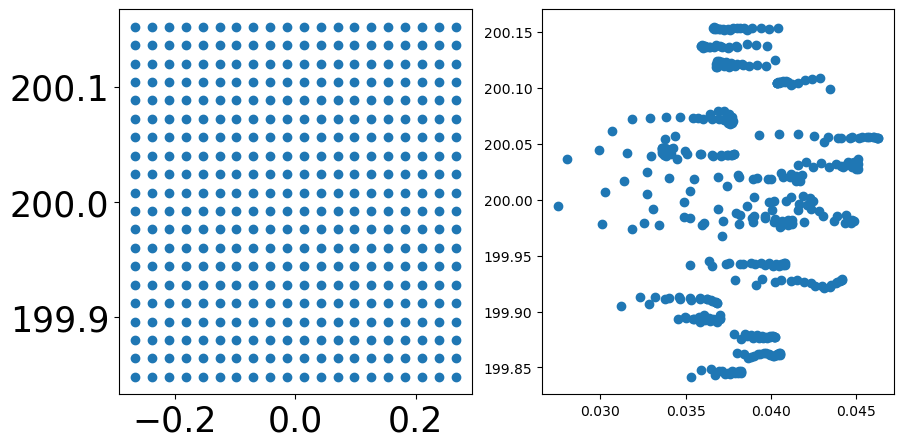

epoch: 5300, train loss: 0.013685223646461964, val loss: 3.3748960494995117
epoch: 5301, train loss: 0.013994703069329262, val loss: 3.3718667030334473
epoch: 5302, train loss: 0.01442672684788704, val loss: 3.3729755878448486
epoch: 5303, train loss: 0.015014910139143467, val loss: 3.376194953918457
epoch: 5304, train loss: 0.015787936747074127, val loss: 3.3731091022491455
epoch: 5305, train loss: 0.01675109751522541, val loss: 3.378962278366089
epoch: 5306, train loss: 0.017853258177638054, val loss: 3.376485824584961
epoch: 5307, train loss: 0.018946051597595215, val loss: 3.3788273334503174
epoch: 5308, train loss: 0.019762342795729637, val loss: 3.3807127475738525
epoch: 5309, train loss: 0.019971797242760658, val loss: 3.3749232292175293
epoch: 5310, train loss: 0.019358240067958832, val loss: 3.382751941680908
epoch: 5311, train loss: 0.01805463247001171, val loss: 3.369039297103882
epoch: 5312, train loss: 0.0166305061429739, val loss: 3.383876323699951
epoch: 5313, train loss

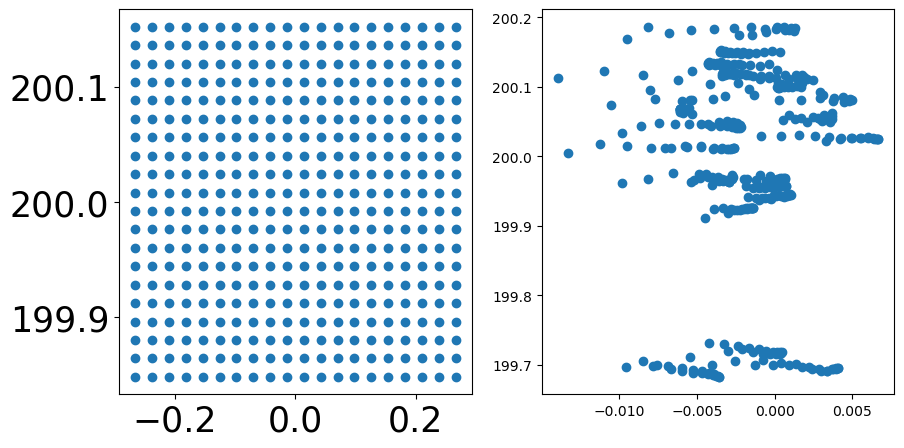

epoch: 5400, train loss: 0.018898436799645424, val loss: 4.041979789733887
epoch: 5401, train loss: 0.015968438237905502, val loss: 3.9108831882476807
epoch: 5402, train loss: 0.01418880932033062, val loss: 3.9769816398620605
epoch: 5403, train loss: 0.01426754705607891, val loss: 3.9816112518310547
epoch: 5404, train loss: 0.015615051612257957, val loss: 3.9176061153411865
epoch: 5405, train loss: 0.016965333372354507, val loss: 4.027793884277344
epoch: 5406, train loss: 0.01731107570230961, val loss: 3.8938281536102295
epoch: 5407, train loss: 0.01648404449224472, val loss: 4.022725582122803
epoch: 5408, train loss: 0.015067234635353088, val loss: 3.9108195304870605
epoch: 5409, train loss: 0.013916537165641785, val loss: 3.9851934909820557
epoch: 5410, train loss: 0.013565221801400185, val loss: 3.951453447341919
epoch: 5411, train loss: 0.013967184349894524, val loss: 3.948273181915283
epoch: 5412, train loss: 0.014624373987317085, val loss: 3.9792258739471436
epoch: 5413, train lo

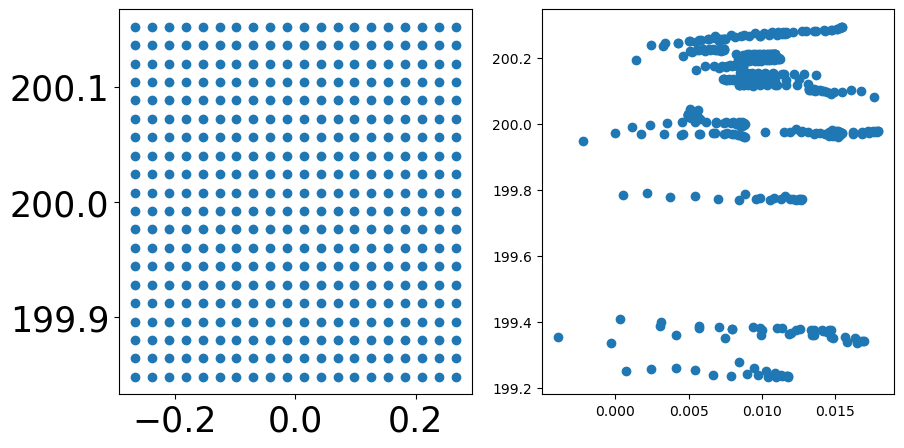

epoch: 5500, train loss: 0.06614573299884796, val loss: 3.2173290252685547
epoch: 5501, train loss: 0.07181814312934875, val loss: 3.68916392326355
epoch: 5502, train loss: 0.06848794966936111, val loss: 3.2982990741729736
epoch: 5503, train loss: 0.04646309092640877, val loss: 3.393897533416748
epoch: 5504, train loss: 0.024889487773180008, val loss: 3.4239251613616943
epoch: 5505, train loss: 0.024604039266705513, val loss: 3.269270896911621
epoch: 5506, train loss: 0.03765050694346428, val loss: 3.4819841384887695
epoch: 5507, train loss: 0.04221343994140625, val loss: 3.2438786029815674
epoch: 5508, train loss: 0.03398194536566734, val loss: 3.4010396003723145
epoch: 5509, train loss: 0.027207026258111, val loss: 3.2966744899749756
epoch: 5510, train loss: 0.028808172792196274, val loss: 3.3104028701782227
epoch: 5511, train loss: 0.030848601832985878, val loss: 3.3413426876068115
epoch: 5512, train loss: 0.02681000903248787, val loss: 3.267118453979492
epoch: 5513, train loss: 0.0

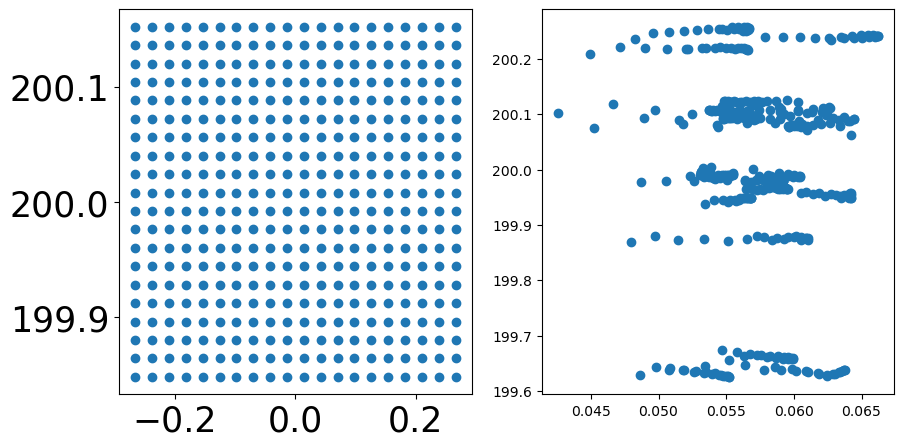

epoch: 5600, train loss: 0.024968333542346954, val loss: 3.5442521572113037
epoch: 5601, train loss: 0.031653378158807755, val loss: 3.4115231037139893
epoch: 5602, train loss: 0.030856801196932793, val loss: 3.468766450881958
epoch: 5603, train loss: 0.022987714037299156, val loss: 3.470160961151123
epoch: 5604, train loss: 0.015518023632466793, val loss: 3.3946731090545654
epoch: 5605, train loss: 0.01435200683772564, val loss: 3.5130980014801025
epoch: 5606, train loss: 0.018435921519994736, val loss: 3.39825439453125
epoch: 5607, train loss: 0.022127075120806694, val loss: 3.4849493503570557
epoch: 5608, train loss: 0.021537046879529953, val loss: 3.443384885787964
epoch: 5609, train loss: 0.017940456047654152, val loss: 3.4206459522247314
epoch: 5610, train loss: 0.015228423289954662, val loss: 3.4854283332824707
epoch: 5611, train loss: 0.015459287911653519, val loss: 3.4033336639404297
epoch: 5612, train loss: 0.017207544296979904, val loss: 3.4814372062683105
epoch: 5613, train

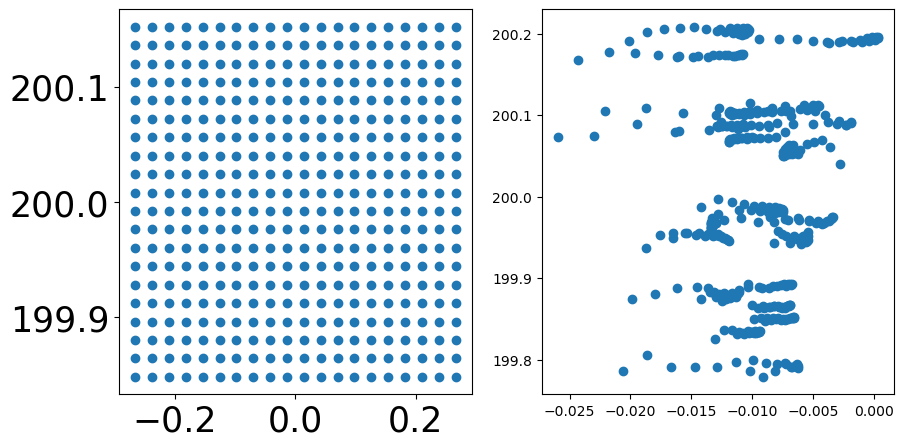

epoch: 5700, train loss: 0.016523927450180054, val loss: 3.618352174758911
epoch: 5701, train loss: 0.019143830984830856, val loss: 3.6576180458068848
epoch: 5702, train loss: 0.019131142646074295, val loss: 3.6922519207000732
epoch: 5703, train loss: 0.016356520354747772, val loss: 3.5763092041015625
epoch: 5704, train loss: 0.015595040284097195, val loss: 3.7476658821105957
epoch: 5705, train loss: 0.017508527263998985, val loss: 3.5803091526031494
epoch: 5706, train loss: 0.018092580139636993, val loss: 3.699111223220825
epoch: 5707, train loss: 0.016083359718322754, val loss: 3.657482624053955
epoch: 5708, train loss: 0.014570917934179306, val loss: 3.6139819622039795
epoch: 5709, train loss: 0.015538658946752548, val loss: 3.7195281982421875
epoch: 5710, train loss: 0.016722150146961212, val loss: 3.609039783477783
epoch: 5711, train loss: 0.015752866864204407, val loss: 3.6894140243530273
epoch: 5712, train loss: 0.013949728570878506, val loss: 3.672048330307007
epoch: 5713, trai

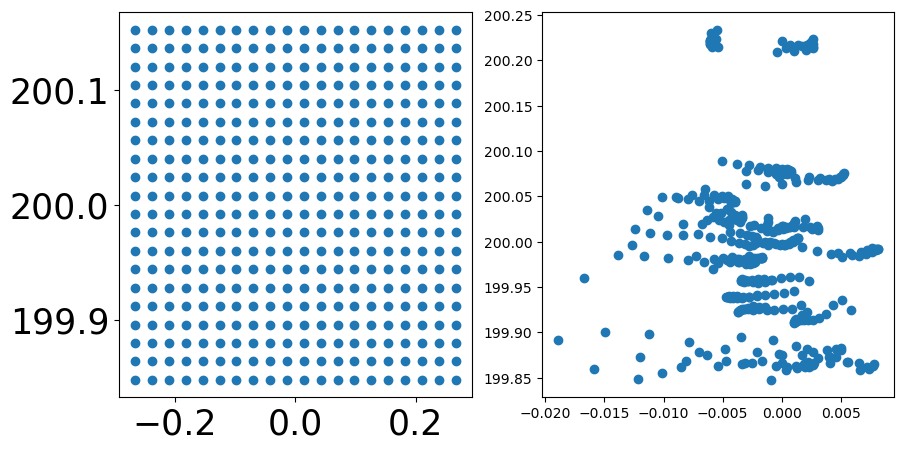

epoch: 5800, train loss: 0.022809933871030807, val loss: 3.8063783645629883
epoch: 5801, train loss: 0.030285771936178207, val loss: 4.1493024826049805
epoch: 5802, train loss: 0.034956566989421844, val loss: 3.78657865524292
epoch: 5803, train loss: 0.03209630772471428, val loss: 4.067907333374023
epoch: 5804, train loss: 0.02457590028643608, val loss: 3.8541488647460938
epoch: 5805, train loss: 0.01867644302546978, val loss: 3.927349090576172
epoch: 5806, train loss: 0.01788521371781826, val loss: 3.9664244651794434
epoch: 5807, train loss: 0.020439449697732925, val loss: 3.8308064937591553
epoch: 5808, train loss: 0.022194087505340576, val loss: 4.017337799072266
epoch: 5809, train loss: 0.02100834995508194, val loss: 3.8070292472839355
epoch: 5810, train loss: 0.018149379640817642, val loss: 3.9811811447143555
epoch: 5811, train loss: 0.0163112785667181, val loss: 3.8521037101745605
epoch: 5812, train loss: 0.016666263341903687, val loss: 3.9121508598327637
epoch: 5813, train loss:

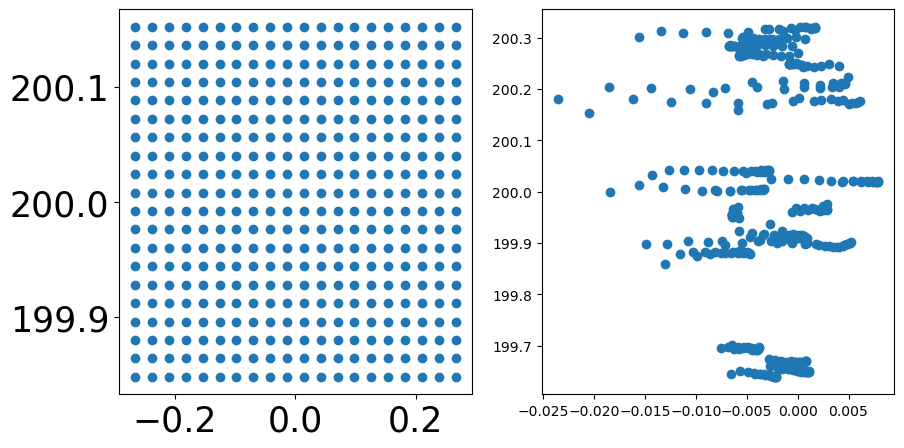

epoch: 5900, train loss: 0.02426879294216633, val loss: 3.3372695446014404
epoch: 5901, train loss: 0.02367398887872696, val loss: 3.3790700435638428
epoch: 5902, train loss: 0.022571658715605736, val loss: 3.2608251571655273
epoch: 5903, train loss: 0.020321015268564224, val loss: 3.4270646572113037
epoch: 5904, train loss: 0.01824358105659485, val loss: 3.2567760944366455
epoch: 5905, train loss: 0.017925746738910675, val loss: 3.4017632007598877
epoch: 5906, train loss: 0.01934978738427162, val loss: 3.308894157409668
epoch: 5907, train loss: 0.020576391369104385, val loss: 3.3471977710723877
epoch: 5908, train loss: 0.019906144589185715, val loss: 3.365171432495117
epoch: 5909, train loss: 0.017604196444153786, val loss: 3.3080596923828125
epoch: 5910, train loss: 0.015497464686632156, val loss: 3.380802631378174
epoch: 5911, train loss: 0.015024693682789803, val loss: 3.3165972232818604
epoch: 5912, train loss: 0.01583796925842762, val loss: 3.3633689880371094
epoch: 5913, train l

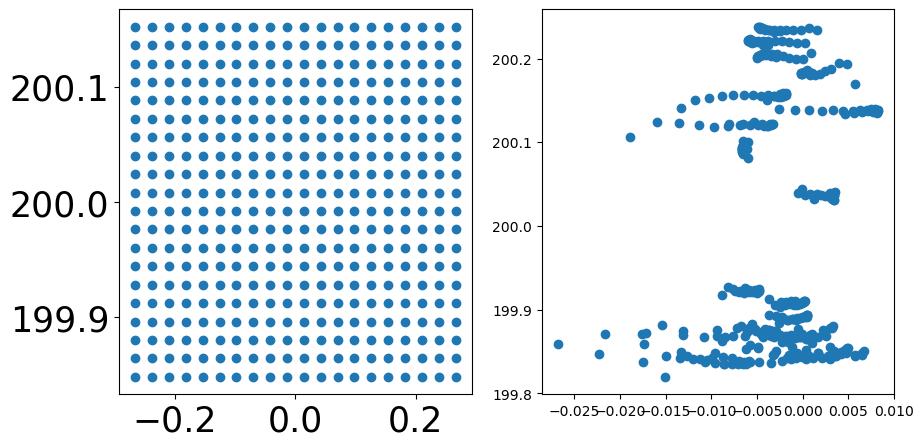

epoch: 6000, train loss: 0.01589830033481121, val loss: 3.9315273761749268
epoch: 6001, train loss: 0.01735195517539978, val loss: 3.948059320449829
epoch: 6002, train loss: 0.01704992912709713, val loss: 3.9295260906219482
epoch: 6003, train loss: 0.01617720164358616, val loss: 3.9654078483581543
epoch: 6004, train loss: 0.016819041222333908, val loss: 3.9302830696105957
epoch: 6005, train loss: 0.01845230534672737, val loss: 3.964550018310547
epoch: 6006, train loss: 0.019465310499072075, val loss: 3.9504551887512207
epoch: 6007, train loss: 0.020159205421805382, val loss: 3.941840410232544
epoch: 6008, train loss: 0.022089995443820953, val loss: 3.9686391353607178
epoch: 6009, train loss: 0.02552196942269802, val loss: 3.9497153759002686
epoch: 6010, train loss: 0.029466381296515465, val loss: 3.961770534515381
epoch: 6011, train loss: 0.03398175165057182, val loss: 3.9761648178100586
epoch: 6012, train loss: 0.04023408889770508, val loss: 3.963177442550659
epoch: 6013, train loss: 

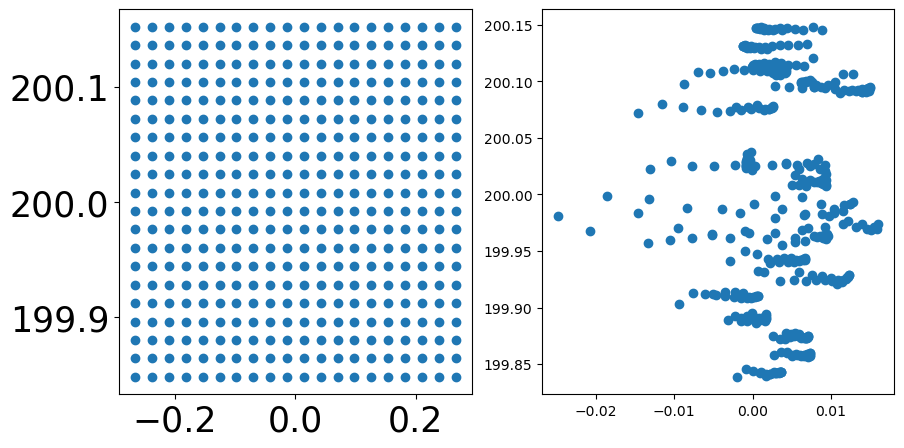

epoch: 6100, train loss: 0.012708554975688457, val loss: 3.9859490394592285
epoch: 6101, train loss: 0.012719379737973213, val loss: 3.974961757659912
epoch: 6102, train loss: 0.012727174907922745, val loss: 3.9843862056732178
epoch: 6103, train loss: 0.012729755602777004, val loss: 3.9732799530029297
epoch: 6104, train loss: 0.01272864080965519, val loss: 3.982144594192505
epoch: 6105, train loss: 0.012727980501949787, val loss: 3.972223997116089
epoch: 6106, train loss: 0.012732718139886856, val loss: 3.9802513122558594
epoch: 6107, train loss: 0.01274681743234396, val loss: 3.9716551303863525
epoch: 6108, train loss: 0.01277323067188263, val loss: 3.978667736053467
epoch: 6109, train loss: 0.012814364396035671, val loss: 3.970839738845825
epoch: 6110, train loss: 0.012874513864517212, val loss: 3.9770989418029785
epoch: 6111, train loss: 0.012961805798113346, val loss: 3.969768524169922
epoch: 6112, train loss: 0.01309093926101923, val loss: 3.9755773544311523
epoch: 6113, train los

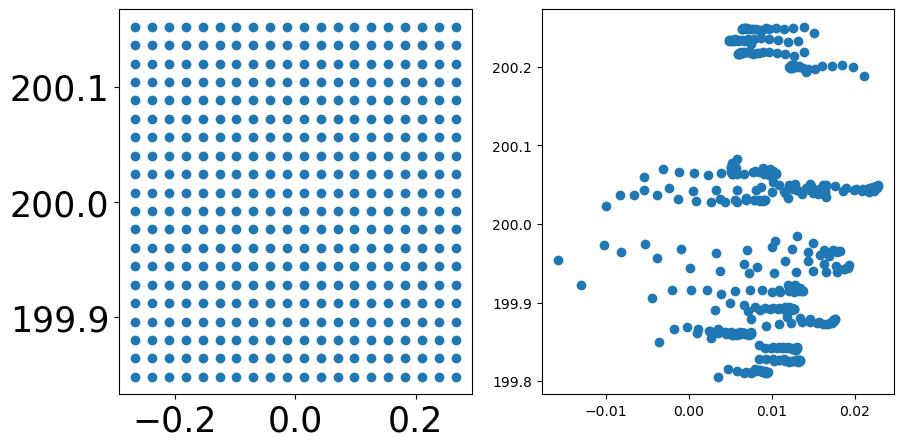

epoch: 6200, train loss: 0.014151195995509624, val loss: 3.4785170555114746
epoch: 6201, train loss: 0.01457302551716566, val loss: 3.4113566875457764
epoch: 6202, train loss: 0.014940404333174229, val loss: 3.473444938659668
epoch: 6203, train loss: 0.015670642256736755, val loss: 3.429663896560669
epoch: 6204, train loss: 0.01684044487774372, val loss: 3.4888861179351807
epoch: 6205, train loss: 0.018324296921491623, val loss: 3.40909481048584
epoch: 6206, train loss: 0.02037910744547844, val loss: 3.5256130695343018
epoch: 6207, train loss: 0.023341936990618706, val loss: 3.4046173095703125
epoch: 6208, train loss: 0.02734776958823204, val loss: 3.54958176612854
epoch: 6209, train loss: 0.03295489400625229, val loss: 3.3995823860168457
epoch: 6210, train loss: 0.04064507409930229, val loss: 3.614321708679199
epoch: 6211, train loss: 0.05116838216781616, val loss: 3.380321502685547
epoch: 6212, train loss: 0.06489726155996323, val loss: 3.709120512008667
epoch: 6213, train loss: 0.08

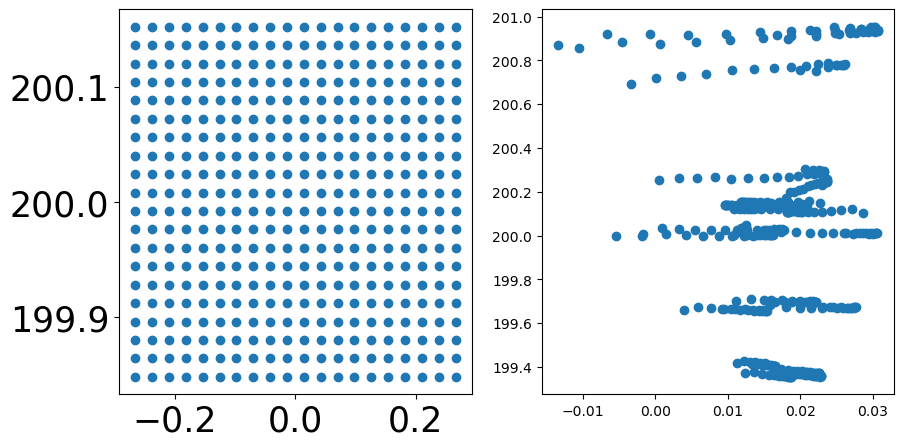

epoch: 6300, train loss: 0.10409250110387802, val loss: 3.8207359313964844
epoch: 6301, train loss: 0.13041569292545319, val loss: 3.8086204528808594
epoch: 6302, train loss: 0.1720273196697235, val loss: 3.7337803840637207
epoch: 6303, train loss: 0.21754387021064758, val loss: 3.9093706607818604
epoch: 6304, train loss: 0.24936072528362274, val loss: 3.738933563232422
epoch: 6305, train loss: 0.2558307647705078, val loss: 3.78015398979187
epoch: 6306, train loss: 0.22848322987556458, val loss: 3.685929536819458
epoch: 6307, train loss: 0.17564508318901062, val loss: 3.4991984367370605
epoch: 6308, train loss: 0.1127481460571289, val loss: 3.6156234741210938
epoch: 6309, train loss: 0.061368491500616074, val loss: 3.3076586723327637
epoch: 6310, train loss: 0.035675354301929474, val loss: 3.537693500518799
epoch: 6311, train loss: 0.036862604320049286, val loss: 3.374501943588257
epoch: 6312, train loss: 0.05392763391137123, val loss: 3.450427770614624
epoch: 6313, train loss: 0.07096

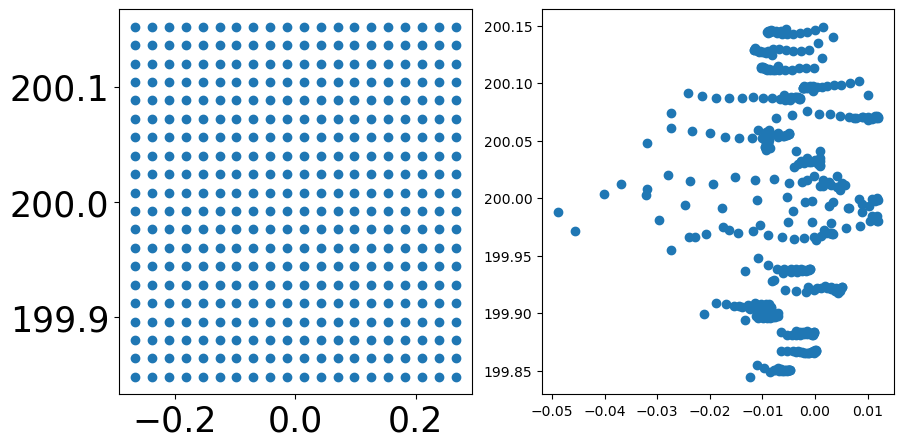

epoch: 6400, train loss: 0.012403077445924282, val loss: 3.720945119857788
epoch: 6401, train loss: 0.012404975481331348, val loss: 3.7156834602355957
epoch: 6402, train loss: 0.01240770798176527, val loss: 3.7302627563476562
epoch: 6403, train loss: 0.012412222102284431, val loss: 3.722255229949951
epoch: 6404, train loss: 0.012419725768268108, val loss: 3.7391014099121094
epoch: 6405, train loss: 0.01243186928331852, val loss: 3.7287631034851074
epoch: 6406, train loss: 0.012450695037841797, val loss: 3.7485780715942383
epoch: 6407, train loss: 0.012479301542043686, val loss: 3.7344350814819336
epoch: 6408, train loss: 0.012521750293672085, val loss: 3.759025812149048
epoch: 6409, train loss: 0.012584015727043152, val loss: 3.73858642578125
epoch: 6410, train loss: 0.012674890458583832, val loss: 3.7705531120300293
epoch: 6411, train loss: 0.012807316146790981, val loss: 3.7405431270599365
epoch: 6412, train loss: 0.013000673614442348, val loss: 3.7856156826019287
epoch: 6413, train 

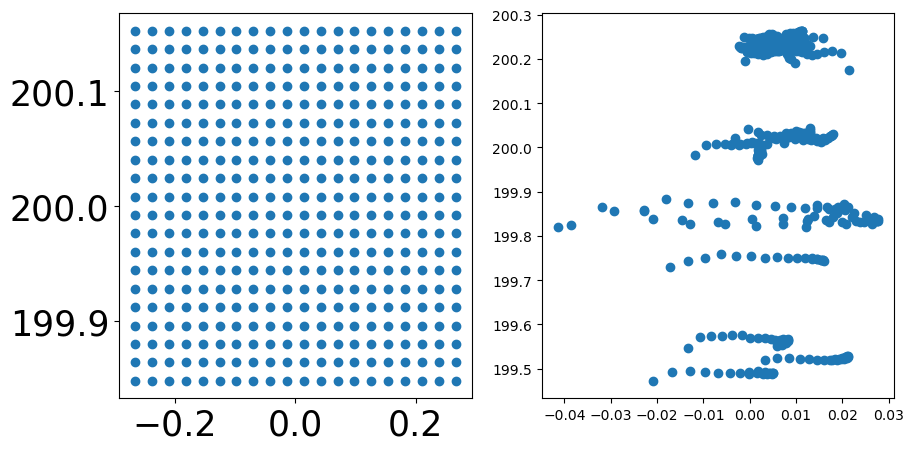

epoch: 6500, train loss: 0.05265706777572632, val loss: 3.5112829208374023
epoch: 6501, train loss: 0.036694109439849854, val loss: 3.6445119380950928
epoch: 6502, train loss: 0.041439302265644073, val loss: 3.6535823345184326
epoch: 6503, train loss: 0.05682248994708061, val loss: 3.6166093349456787
epoch: 6504, train loss: 0.0453680083155632, val loss: 3.570157766342163
epoch: 6505, train loss: 0.023663312196731567, val loss: 3.6560192108154297
epoch: 6506, train loss: 0.024644220247864723, val loss: 3.5627129077911377
epoch: 6507, train loss: 0.032202787697315216, val loss: 3.66015362739563
epoch: 6508, train loss: 0.024279622361063957, val loss: 3.6675524711608887
epoch: 6509, train loss: 0.017696496099233627, val loss: 3.579012632369995
epoch: 6510, train loss: 0.02456378936767578, val loss: 3.786752223968506
epoch: 6511, train loss: 0.027440723031759262, val loss: 3.602853536605835
epoch: 6512, train loss: 0.021201975643634796, val loss: 3.6514387130737305
epoch: 6513, train loss

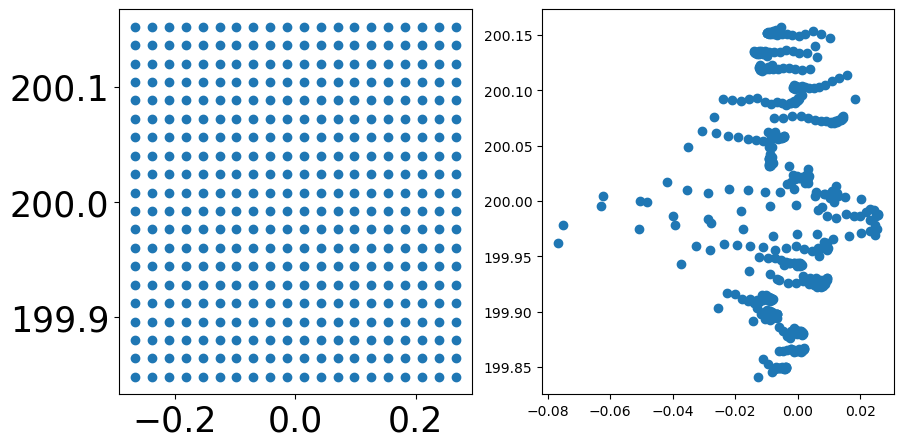

epoch: 6600, train loss: 0.011984460987150669, val loss: 4.127137184143066
epoch: 6601, train loss: 0.011981189250946045, val loss: 4.132590293884277
epoch: 6602, train loss: 0.012027244083583355, val loss: 4.136937618255615
epoch: 6603, train loss: 0.012085506692528725, val loss: 4.144375801086426
epoch: 6604, train loss: 0.012121700681746006, val loss: 4.146249771118164
epoch: 6605, train loss: 0.012117926962673664, val loss: 4.15497350692749
epoch: 6606, train loss: 0.01207769475877285, val loss: 4.156385898590088
epoch: 6607, train loss: 0.012020797468721867, val loss: 4.164095401763916
epoch: 6608, train loss: 0.011971000581979752, val loss: 4.167552947998047
epoch: 6609, train loss: 0.011944150552153587, val loss: 4.173384189605713
epoch: 6610, train loss: 0.011943389661610126, val loss: 4.176920413970947
epoch: 6611, train loss: 0.011961303651332855, val loss: 4.18526029586792
epoch: 6612, train loss: 0.011985491029918194, val loss: 4.186709880828857
epoch: 6613, train loss: 0.0

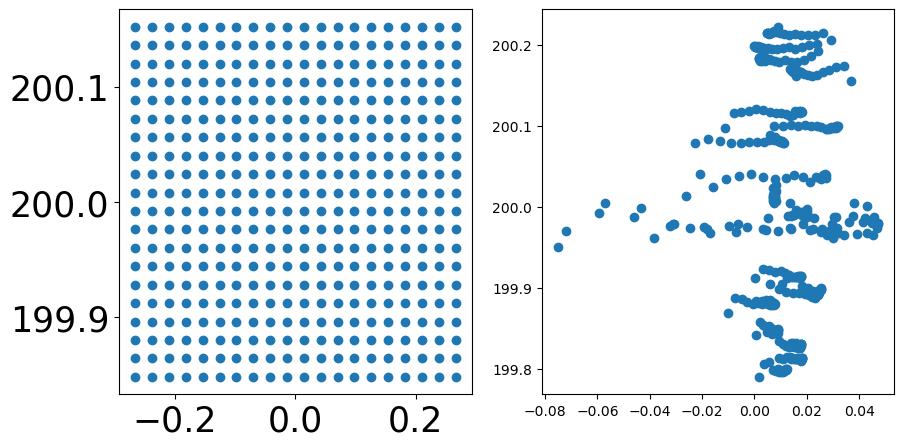

epoch: 6700, train loss: 0.012830228544771671, val loss: 4.279526710510254
epoch: 6701, train loss: 0.013255530036985874, val loss: 4.241644382476807
epoch: 6702, train loss: 0.013843108899891376, val loss: 4.272095680236816
epoch: 6703, train loss: 0.01375633105635643, val loss: 4.264302730560303
epoch: 6704, train loss: 0.013082313351333141, val loss: 4.295338153839111
epoch: 6705, train loss: 0.012630822136998177, val loss: 4.283398151397705
epoch: 6706, train loss: 0.01241245586425066, val loss: 4.297945976257324
epoch: 6707, train loss: 0.012386668473482132, val loss: 4.334414958953857
epoch: 6708, train loss: 0.012759375385940075, val loss: 4.296245098114014
epoch: 6709, train loss: 0.013263366185128689, val loss: 4.338442802429199
epoch: 6710, train loss: 0.013705826364457607, val loss: 4.337172985076904
epoch: 6711, train loss: 0.014227480627596378, val loss: 4.33717155456543
epoch: 6712, train loss: 0.014712156727910042, val loss: 4.34820556640625
epoch: 6713, train loss: 0.01

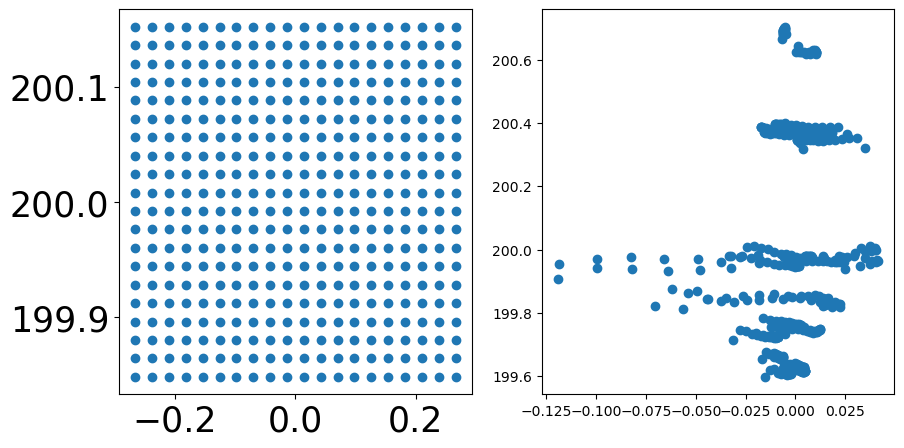

epoch: 6800, train loss: 0.04699240252375603, val loss: 4.63373327255249
epoch: 6801, train loss: 0.03994296118617058, val loss: 4.466522216796875
epoch: 6802, train loss: 0.033608440309762955, val loss: 4.55167818069458
epoch: 6803, train loss: 0.03697728365659714, val loss: 4.576129913330078
epoch: 6804, train loss: 0.03870276361703873, val loss: 4.463354587554932
epoch: 6805, train loss: 0.03233340382575989, val loss: 4.674427509307861
epoch: 6806, train loss: 0.030174802988767624, val loss: 4.455442428588867
epoch: 6807, train loss: 0.03514813631772995, val loss: 4.6907734870910645
epoch: 6808, train loss: 0.031926024705171585, val loss: 4.548492431640625
epoch: 6809, train loss: 0.018329553306102753, val loss: 4.5947747230529785
epoch: 6810, train loss: 0.0138272475451231, val loss: 4.688714504241943
epoch: 6811, train loss: 0.024003585800528526, val loss: 4.591451644897461
epoch: 6812, train loss: 0.029966188594698906, val loss: 4.765440464019775
epoch: 6813, train loss: 0.022315

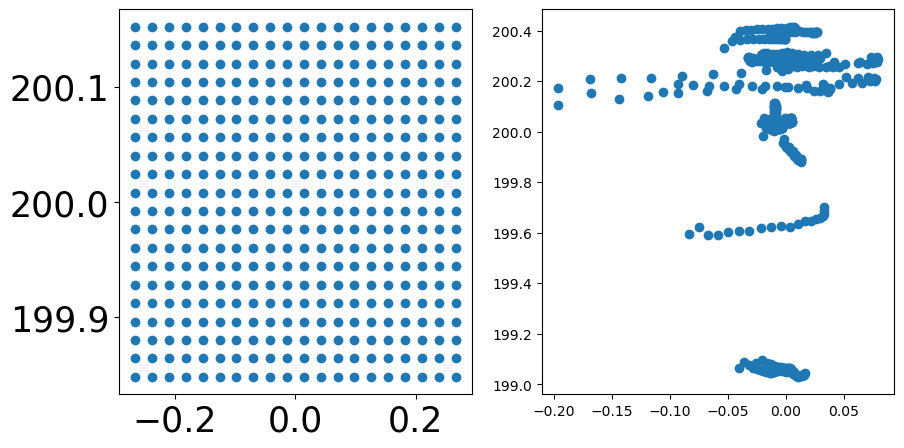

epoch: 6900, train loss: 0.08646611124277115, val loss: 6.324458599090576
epoch: 6901, train loss: 0.12426199018955231, val loss: 5.178761005401611
epoch: 6902, train loss: 0.17476677894592285, val loss: 6.592008113861084
epoch: 6903, train loss: 0.23128512501716614, val loss: 5.186686992645264
epoch: 6904, train loss: 0.28630343079566956, val loss: 6.732097148895264
epoch: 6905, train loss: 0.3093632757663727, val loss: 5.29224157333374
epoch: 6906, train loss: 0.2858659029006958, val loss: 6.3959808349609375
epoch: 6907, train loss: 0.20026680827140808, val loss: 5.445001125335693
epoch: 6908, train loss: 0.09563964605331421, val loss: 5.785627841949463
epoch: 6909, train loss: 0.02624179609119892, val loss: 5.757941722869873
epoch: 6910, train loss: 0.02710976079106331, val loss: 5.549196720123291
epoch: 6911, train loss: 0.07431259006261826, val loss: 5.99941349029541
epoch: 6912, train loss: 0.1080823466181755, val loss: 5.551609992980957
epoch: 6913, train loss: 0.092340245842933

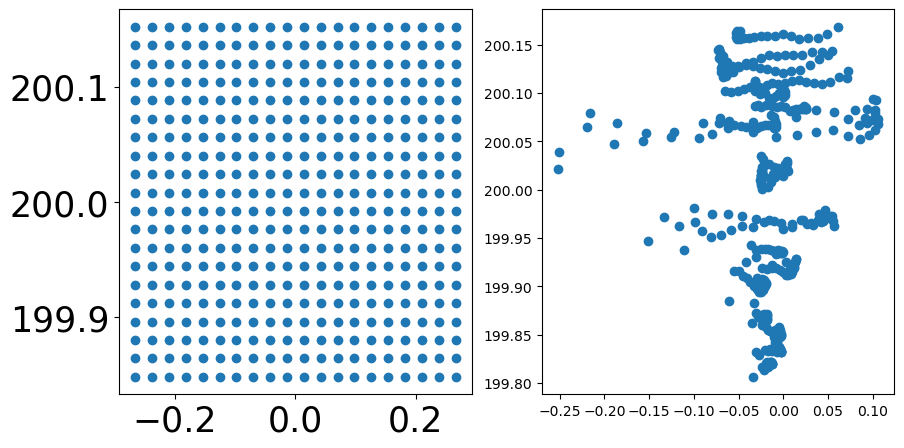

epoch: 7000, train loss: 0.009892027825117111, val loss: 6.652588844299316
epoch: 7001, train loss: 0.009879804216325283, val loss: 6.744657039642334
epoch: 7002, train loss: 0.009869588539004326, val loss: 6.6618523597717285
epoch: 7003, train loss: 0.009882831014692783, val loss: 6.799626350402832
epoch: 7004, train loss: 0.009943550452589989, val loss: 6.662877082824707
epoch: 7005, train loss: 0.01008786540478468, val loss: 6.836061954498291
epoch: 7006, train loss: 0.010321282781660557, val loss: 6.65737771987915
epoch: 7007, train loss: 0.010663449764251709, val loss: 6.874692916870117
epoch: 7008, train loss: 0.01110844686627388, val loss: 6.659780025482178
epoch: 7009, train loss: 0.011696025729179382, val loss: 6.91853666305542
epoch: 7010, train loss: 0.012461232952773571, val loss: 6.634252548217773
epoch: 7011, train loss: 0.013514443300664425, val loss: 6.968700885772705
epoch: 7012, train loss: 0.014960251748561859, val loss: 6.572998046875
epoch: 7013, train loss: 0.0169

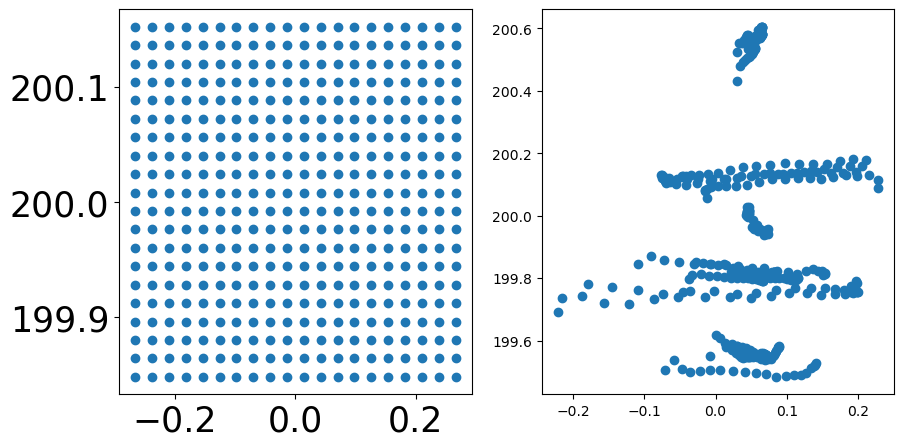

epoch: 7100, train loss: 0.08041181415319443, val loss: 7.1340460777282715
epoch: 7101, train loss: 0.1277897208929062, val loss: 7.308582782745361
epoch: 7102, train loss: 0.12049613893032074, val loss: 7.051170349121094
epoch: 7103, train loss: 0.06641802936792374, val loss: 7.182554721832275
epoch: 7104, train loss: 0.0188010111451149, val loss: 7.202730178833008
epoch: 7105, train loss: 0.023412665352225304, val loss: 7.202150344848633
epoch: 7106, train loss: 0.06030509993433952, val loss: 7.459103107452393
epoch: 7107, train loss: 0.07954499870538712, val loss: 7.308931827545166
epoch: 7108, train loss: 0.055882129818201065, val loss: 7.435161113739014
epoch: 7109, train loss: 0.01887119933962822, val loss: 7.338723659515381
epoch: 7110, train loss: 0.011396906338632107, val loss: 7.358943939208984
epoch: 7111, train loss: 0.032726533710956573, val loss: 7.511671543121338
epoch: 7112, train loss: 0.045763224363327026, val loss: 7.306210994720459
epoch: 7113, train loss: 0.0320694

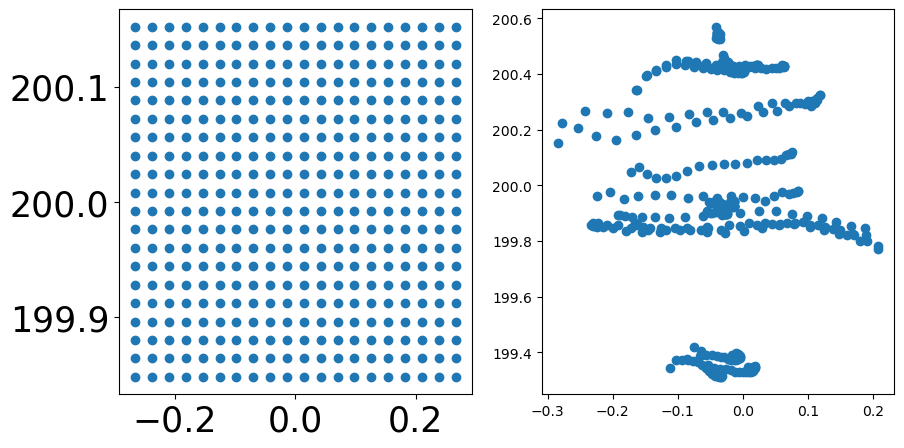

epoch: 7200, train loss: 0.06329862773418427, val loss: 7.199195861816406
epoch: 7201, train loss: 0.07234525680541992, val loss: 6.833585262298584
epoch: 7202, train loss: 0.06993155926465988, val loss: 7.262632846832275
epoch: 7203, train loss: 0.06405217200517654, val loss: 6.946404933929443
epoch: 7204, train loss: 0.06371733546257019, val loss: 7.241463661193848
epoch: 7205, train loss: 0.06882600486278534, val loss: 7.216927528381348
epoch: 7206, train loss: 0.07056199014186859, val loss: 7.110679626464844
epoch: 7207, train loss: 0.06113986670970917, val loss: 7.294517517089844
epoch: 7208, train loss: 0.04315542057156563, val loss: 7.2498931884765625
epoch: 7209, train loss: 0.028061050921678543, val loss: 7.191456317901611
epoch: 7210, train loss: 0.02222764864563942, val loss: 7.5305962562561035
epoch: 7211, train loss: 0.02060343697667122, val loss: 7.227912425994873
epoch: 7212, train loss: 0.016057422384619713, val loss: 7.532128810882568
epoch: 7213, train loss: 0.0102036

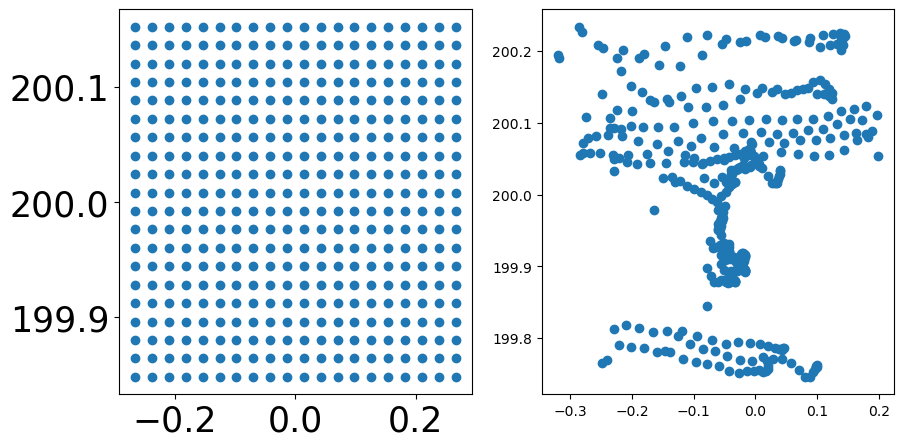

epoch: 7300, train loss: 0.017889536917209625, val loss: 7.820851802825928
epoch: 7301, train loss: 0.022060569375753403, val loss: 8.339899063110352
epoch: 7302, train loss: 0.02343723550438881, val loss: 7.709253787994385
epoch: 7303, train loss: 0.02165275067090988, val loss: 8.06965160369873
epoch: 7304, train loss: 0.01770583540201187, val loss: 7.651472091674805
epoch: 7305, train loss: 0.013309556990861893, val loss: 7.8854522705078125
epoch: 7306, train loss: 0.01009551715105772, val loss: 7.679954528808594
epoch: 7307, train loss: 0.008913404308259487, val loss: 7.70254373550415
epoch: 7308, train loss: 0.009586278349161148, val loss: 7.825943470001221
epoch: 7309, train loss: 0.011174151673913002, val loss: 7.609072685241699
epoch: 7310, train loss: 0.012499218806624413, val loss: 7.938727378845215
epoch: 7311, train loss: 0.012763695791363716, val loss: 7.6872992515563965
epoch: 7312, train loss: 0.011781451292335987, val loss: 8.000937461853027
epoch: 7313, train loss: 0.01

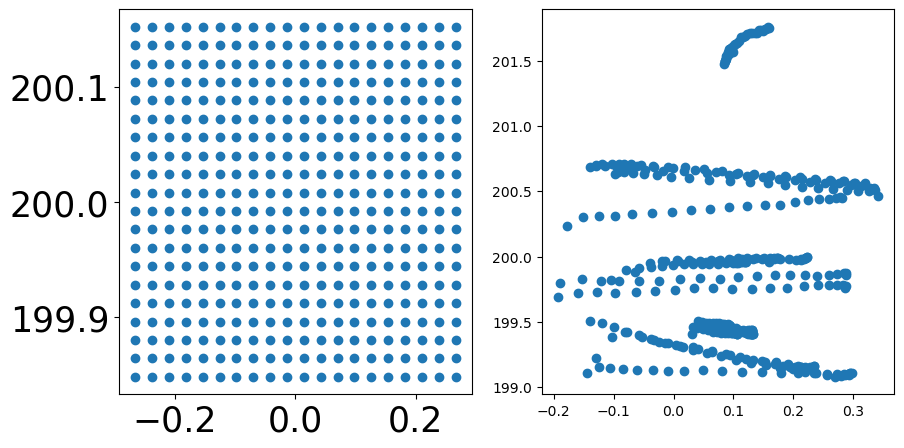

epoch: 7400, train loss: 0.25571510195732117, val loss: 7.951694965362549
epoch: 7401, train loss: 0.2142346203327179, val loss: 7.200624465942383
epoch: 7402, train loss: 0.1519307792186737, val loss: 8.056732177734375
epoch: 7403, train loss: 0.11225102096796036, val loss: 6.621613502502441
epoch: 7404, train loss: 0.12142469733953476, val loss: 8.136540412902832
epoch: 7405, train loss: 0.16925819218158722, val loss: 6.516493797302246
epoch: 7406, train loss: 0.2146105021238327, val loss: 7.90615701675415
epoch: 7407, train loss: 0.22184298932552338, val loss: 6.323204040527344
epoch: 7408, train loss: 0.18761779367923737, val loss: 7.598844051361084
epoch: 7409, train loss: 0.14024049043655396, val loss: 6.268218994140625
epoch: 7410, train loss: 0.10374113917350769, val loss: 6.899407863616943
epoch: 7411, train loss: 0.07833616435527802, val loss: 6.443246364593506
epoch: 7412, train loss: 0.05470586568117142, val loss: 6.453017234802246
epoch: 7413, train loss: 0.036449905484914

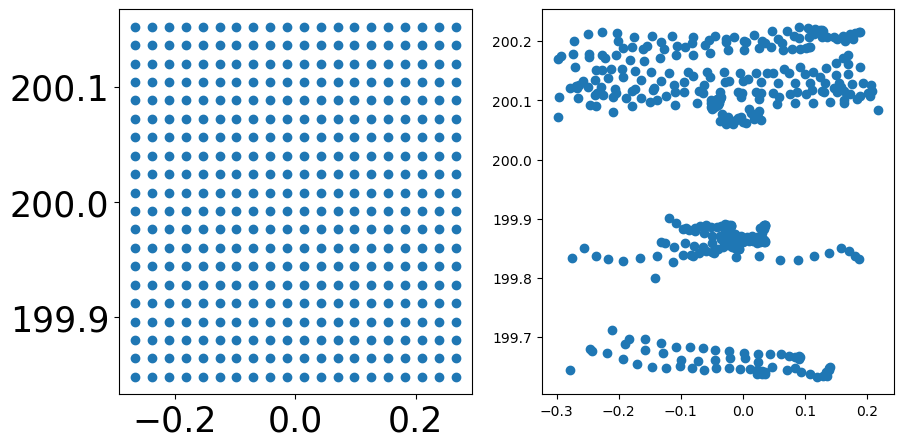

epoch: 7500, train loss: 0.012812359258532524, val loss: 7.078654766082764
epoch: 7501, train loss: 0.01112307421863079, val loss: 6.896735668182373
epoch: 7502, train loss: 0.009615612216293812, val loss: 7.100597858428955
epoch: 7503, train loss: 0.008752360008656979, val loss: 6.91563081741333
epoch: 7504, train loss: 0.008493062108755112, val loss: 7.087386131286621
epoch: 7505, train loss: 0.00842189695686102, val loss: 6.929903507232666
epoch: 7506, train loss: 0.008121790364384651, val loss: 7.052041053771973
epoch: 7507, train loss: 0.007382035721093416, val loss: 6.963475227355957
epoch: 7508, train loss: 0.0063447412103414536, val loss: 6.980033874511719
epoch: 7509, train loss: 0.00533906789496541, val loss: 7.007538795471191
epoch: 7510, train loss: 0.004705906379967928, val loss: 6.950234413146973
epoch: 7511, train loss: 0.0045969728380441666, val loss: 7.046520233154297
epoch: 7512, train loss: 0.004923483356833458, val loss: 6.944971561431885
epoch: 7513, train loss: 0.

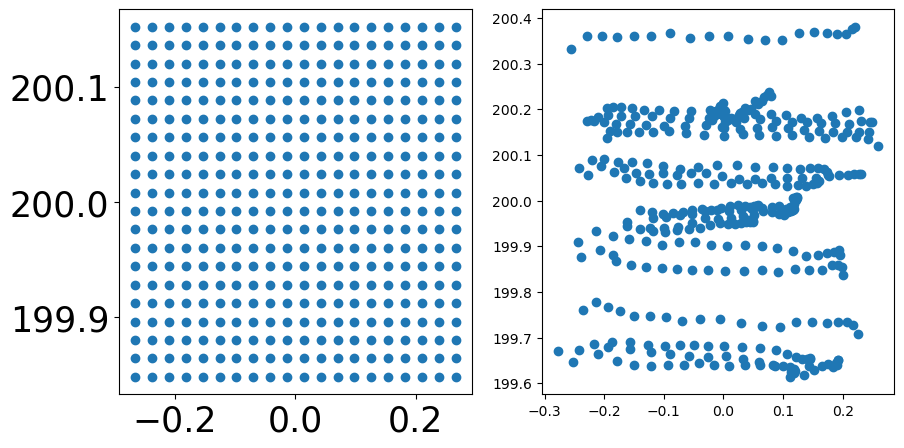

epoch: 7600, train loss: 0.01570405252277851, val loss: 5.82712984085083
epoch: 7601, train loss: 0.0076498775742948055, val loss: 5.786388874053955
epoch: 7602, train loss: 0.01449539139866829, val loss: 5.819400310516357
epoch: 7603, train loss: 0.0250529907643795, val loss: 5.862062931060791
epoch: 7604, train loss: 0.02815479412674904, val loss: 5.885324478149414
epoch: 7605, train loss: 0.02252698317170143, val loss: 5.804352760314941
epoch: 7606, train loss: 0.014948410913348198, val loss: 5.981257915496826
epoch: 7607, train loss: 0.011728005483746529, val loss: 5.759493350982666
epoch: 7608, train loss: 0.01323119830340147, val loss: 6.016054630279541
epoch: 7609, train loss: 0.01540188305079937, val loss: 5.833174228668213
epoch: 7610, train loss: 0.014518560841679573, val loss: 5.956212043762207
epoch: 7611, train loss: 0.01064460538327694, val loss: 5.956870079040527
epoch: 7612, train loss: 0.006494763772934675, val loss: 5.934693336486816
epoch: 7613, train loss: 0.0048166

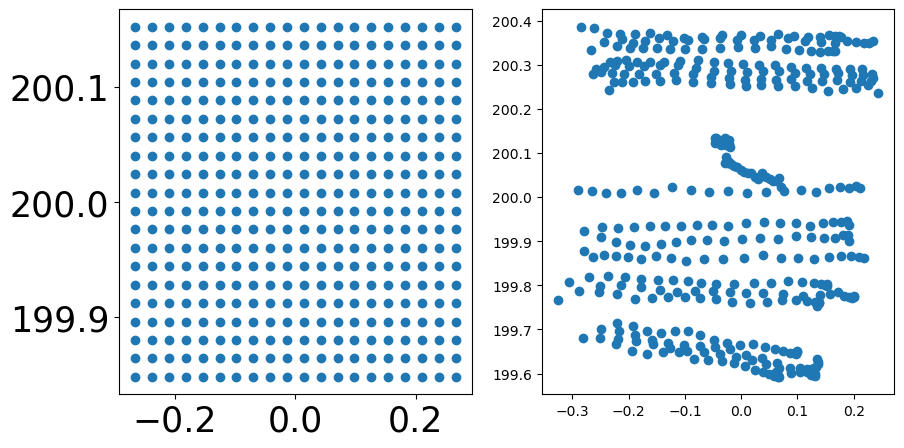

epoch: 7700, train loss: 0.017585670575499535, val loss: 4.922891139984131
epoch: 7701, train loss: 0.016075553372502327, val loss: 4.723450660705566
epoch: 7702, train loss: 0.014216828159987926, val loss: 4.852607727050781
epoch: 7703, train loss: 0.012098810635507107, val loss: 4.774359703063965
epoch: 7704, train loss: 0.009512118995189667, val loss: 4.748324871063232
epoch: 7705, train loss: 0.006898222491145134, val loss: 4.879587173461914
epoch: 7706, train loss: 0.005251954775303602, val loss: 4.700816631317139
epoch: 7707, train loss: 0.005251497030258179, val loss: 4.885951042175293
epoch: 7708, train loss: 0.006603635847568512, val loss: 4.733058452606201
epoch: 7709, train loss: 0.008181048557162285, val loss: 4.873178482055664
epoch: 7710, train loss: 0.00875528808683157, val loss: 4.80031681060791
epoch: 7711, train loss: 0.007745231967419386, val loss: 4.855387210845947
epoch: 7712, train loss: 0.005764089524745941, val loss: 4.81610107421875
epoch: 7713, train loss: 0.0

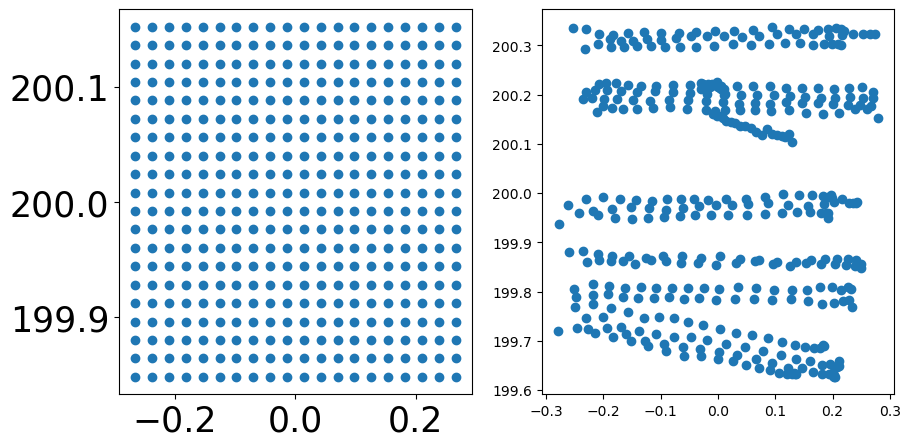

epoch: 7800, train loss: 0.013754846528172493, val loss: 5.002017021179199
epoch: 7801, train loss: 0.013577314093708992, val loss: 4.728907585144043
epoch: 7802, train loss: 0.01317155733704567, val loss: 4.984869003295898
epoch: 7803, train loss: 0.012594862841069698, val loss: 4.756036281585693
epoch: 7804, train loss: 0.011914634145796299, val loss: 4.967536449432373
epoch: 7805, train loss: 0.011230495758354664, val loss: 4.781638145446777
epoch: 7806, train loss: 0.010610721074044704, val loss: 4.948597431182861
epoch: 7807, train loss: 0.010106456466019154, val loss: 4.8019914627075195
epoch: 7808, train loss: 0.009733753278851509, val loss: 4.933448791503906
epoch: 7809, train loss: 0.00948705431073904, val loss: 4.8150177001953125
epoch: 7810, train loss: 0.00936240516602993, val loss: 4.9239935874938965
epoch: 7811, train loss: 0.009330758824944496, val loss: 4.825699329376221
epoch: 7812, train loss: 0.009388016536831856, val loss: 4.922563552856445
epoch: 7813, train loss: 

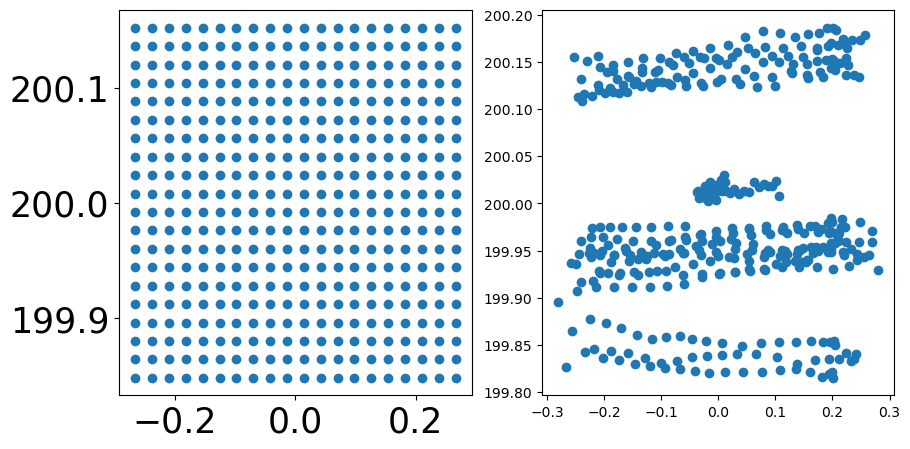

epoch: 7900, train loss: 0.007762526161968708, val loss: 4.249457836151123
epoch: 7901, train loss: 0.007518530357629061, val loss: 4.35060453414917
epoch: 7902, train loss: 0.005021814722567797, val loss: 4.341043472290039
epoch: 7903, train loss: 0.0030272710137069225, val loss: 4.32928991317749
epoch: 7904, train loss: 0.0032822894863784313, val loss: 4.432028293609619
epoch: 7905, train loss: 0.004693678114563227, val loss: 4.33814001083374
epoch: 7906, train loss: 0.005143842194229364, val loss: 4.459722995758057
epoch: 7907, train loss: 0.004118701908737421, val loss: 4.384957790374756
epoch: 7908, train loss: 0.002973878988996148, val loss: 4.451515197753906
epoch: 7909, train loss: 0.002987590851262212, val loss: 4.4458394050598145
epoch: 7910, train loss: 0.0038885667454451323, val loss: 4.450388431549072
epoch: 7911, train loss: 0.004455641843378544, val loss: 4.458635330200195
epoch: 7912, train loss: 0.0040786475874483585, val loss: 4.49623441696167
epoch: 7913, train loss:

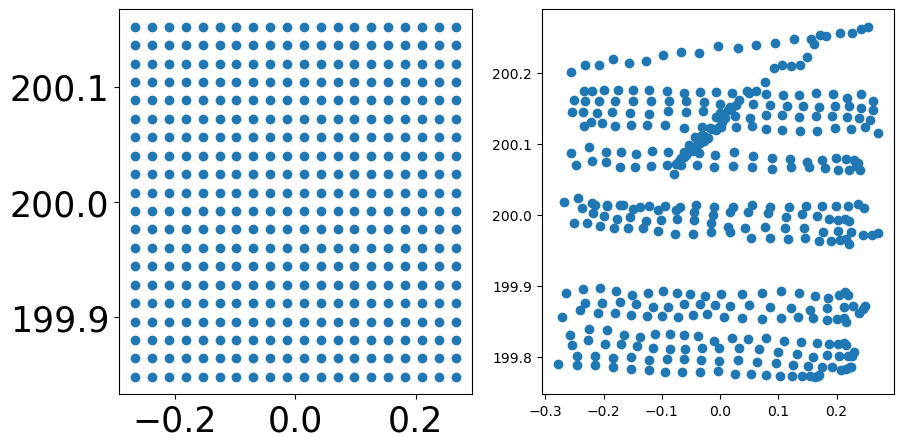

epoch: 8000, train loss: 0.0046817646361887455, val loss: 4.6181745529174805
epoch: 8001, train loss: 0.007397420238703489, val loss: 4.765819072723389
epoch: 8002, train loss: 0.01281984057277441, val loss: 4.734170436859131
epoch: 8003, train loss: 0.021992601454257965, val loss: 4.871410369873047
epoch: 8004, train loss: 0.03741385415196419, val loss: 4.9498748779296875
epoch: 8005, train loss: 0.056220363825559616, val loss: 4.82828426361084
epoch: 8006, train loss: 0.0707818940281868, val loss: 5.447617053985596
epoch: 8007, train loss: 0.07986585050821304, val loss: 4.500179290771484
epoch: 8008, train loss: 0.07769139856100082, val loss: 5.302450656890869
epoch: 8009, train loss: 0.06909287720918655, val loss: 4.563606262207031
epoch: 8010, train loss: 0.05742722004652023, val loss: 4.659205913543701
epoch: 8011, train loss: 0.04598790034651756, val loss: 4.355810642242432
epoch: 8012, train loss: 0.03667818009853363, val loss: 4.54861307144165
epoch: 8013, train loss: 0.0315510

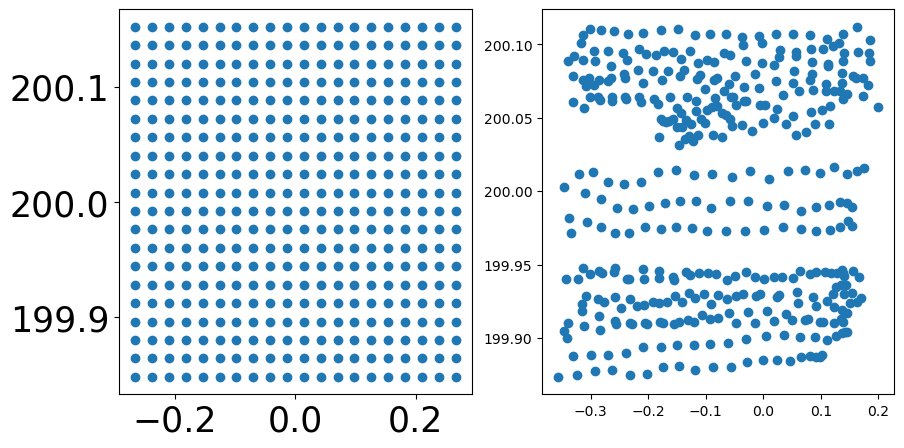

epoch: 8100, train loss: 0.0038013109005987644, val loss: 4.781091690063477
epoch: 8101, train loss: 0.004497343674302101, val loss: 4.833775520324707
epoch: 8102, train loss: 0.005178322549909353, val loss: 4.806395530700684
epoch: 8103, train loss: 0.005893518682569265, val loss: 4.804377555847168
epoch: 8104, train loss: 0.006350845564156771, val loss: 4.839109897613525
epoch: 8105, train loss: 0.0061766174621880054, val loss: 4.803823471069336
epoch: 8106, train loss: 0.005326514597982168, val loss: 4.83923864364624
epoch: 8107, train loss: 0.004078831057995558, val loss: 4.822244644165039
epoch: 8108, train loss: 0.0027839962858706713, val loss: 4.84901762008667
epoch: 8109, train loss: 0.0017736891750246286, val loss: 4.823521137237549
epoch: 8110, train loss: 0.00134351069573313, val loss: 4.883430004119873
epoch: 8111, train loss: 0.0016110115684568882, val loss: 4.810142517089844
epoch: 8112, train loss: 0.002375031355768442, val loss: 4.91442346572876
epoch: 8113, train loss:

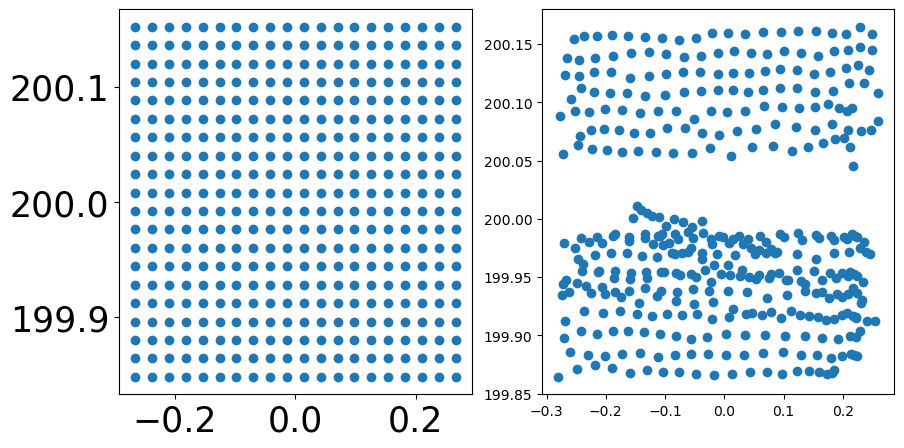

epoch: 8200, train loss: 0.0010177631629630923, val loss: 5.04799747467041
epoch: 8201, train loss: 0.0010674676159396768, val loss: 5.040058612823486
epoch: 8202, train loss: 0.0011212737299501896, val loss: 5.047444820404053
epoch: 8203, train loss: 0.001185616129077971, val loss: 5.047179222106934
epoch: 8204, train loss: 0.0012705984991043806, val loss: 5.04984712600708
epoch: 8205, train loss: 0.001390491146594286, val loss: 5.047945976257324
epoch: 8206, train loss: 0.0015573102282360196, val loss: 5.047724723815918
epoch: 8207, train loss: 0.0017879917286336422, val loss: 5.0585713386535645
epoch: 8208, train loss: 0.0021036039106547832, val loss: 5.040256977081299
epoch: 8209, train loss: 0.0025314874947071075, val loss: 5.074838161468506
epoch: 8210, train loss: 0.0031135999597609043, val loss: 5.038336277008057
epoch: 8211, train loss: 0.003911733627319336, val loss: 5.097239017486572
epoch: 8212, train loss: 0.005015870090574026, val loss: 5.031267166137695
epoch: 8213, trai

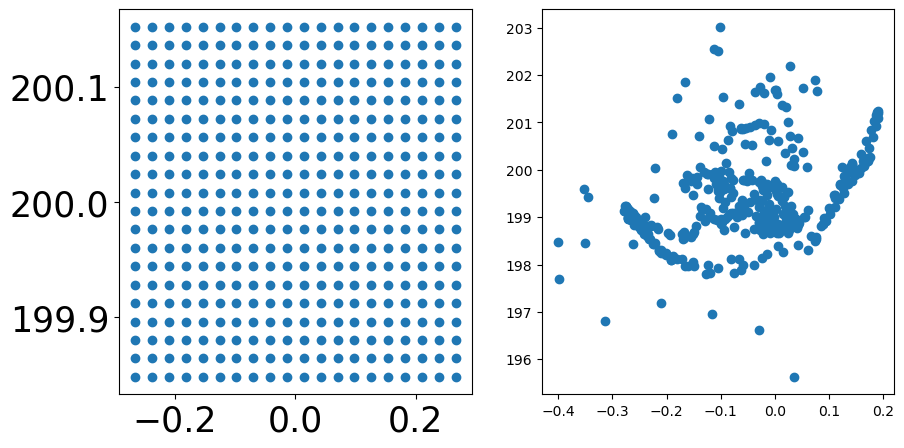

epoch: 8300, train loss: 0.6755862236022949, val loss: 1.3625692129135132
epoch: 8301, train loss: 0.4076455533504486, val loss: 1.1547499895095825
epoch: 8302, train loss: 0.45454660058021545, val loss: 1.137416958808899
epoch: 8303, train loss: 0.5955097675323486, val loss: 1.1924583911895752
epoch: 8304, train loss: 0.6159738898277283, val loss: 1.1951011419296265
epoch: 8305, train loss: 0.6275491714477539, val loss: 0.9105813503265381
epoch: 8306, train loss: 0.5044749975204468, val loss: 0.694478452205658
epoch: 8307, train loss: 0.3430292308330536, val loss: 0.8771026134490967
epoch: 8308, train loss: 0.21037687361240387, val loss: 1.3812549114227295
epoch: 8309, train loss: 0.17869597673416138, val loss: 1.781072974205017
epoch: 8310, train loss: 0.24277636408805847, val loss: 1.7489721775054932
epoch: 8311, train loss: 0.2789805829524994, val loss: 1.5307540893554688
epoch: 8312, train loss: 0.31156715750694275, val loss: 1.4209470748901367
epoch: 8313, train loss: 0.292740702

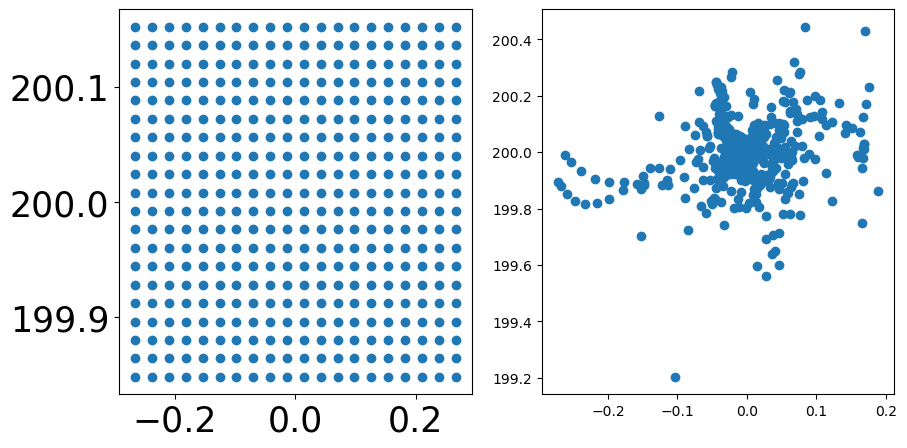

epoch: 8400, train loss: 0.01678641512989998, val loss: 1.0997694730758667
epoch: 8401, train loss: 0.016707120463252068, val loss: 1.0967727899551392
epoch: 8402, train loss: 0.01662244275212288, val loss: 1.0933624505996704
epoch: 8403, train loss: 0.016540685668587685, val loss: 1.0923371315002441
epoch: 8404, train loss: 0.01646139658987522, val loss: 1.0931148529052734
epoch: 8405, train loss: 0.016386399045586586, val loss: 1.0934375524520874
epoch: 8406, train loss: 0.016314782202243805, val loss: 1.092438817024231
epoch: 8407, train loss: 0.016246061772108078, val loss: 1.091387391090393
epoch: 8408, train loss: 0.016178347170352936, val loss: 1.0914392471313477
epoch: 8409, train loss: 0.01610720343887806, val loss: 1.092105507850647
epoch: 8410, train loss: 0.016038116067647934, val loss: 1.0922578573226929
epoch: 8411, train loss: 0.015971750020980835, val loss: 1.0920661687850952
epoch: 8412, train loss: 0.015905940905213356, val loss: 1.0925136804580688
epoch: 8413, train 

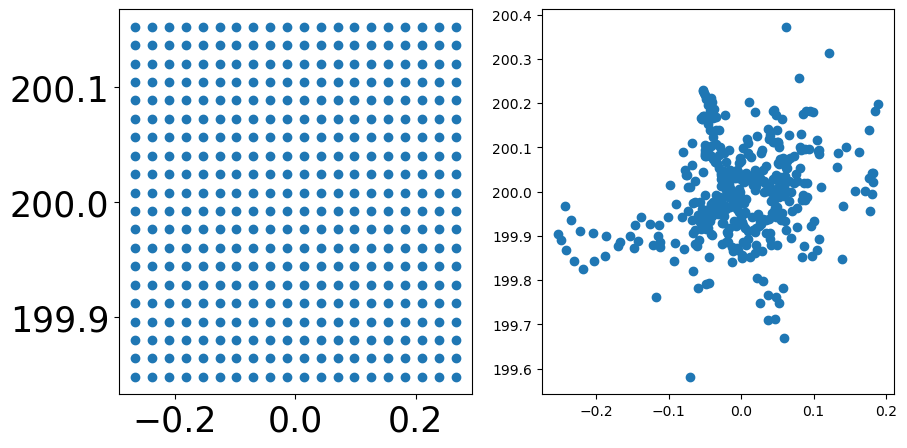

epoch: 8500, train loss: 0.012850631959736347, val loss: 1.0896787643432617
epoch: 8501, train loss: 0.012831531465053558, val loss: 1.089597225189209
epoch: 8502, train loss: 0.012812850996851921, val loss: 1.0895766019821167
epoch: 8503, train loss: 0.012794415466487408, val loss: 1.089547038078308
epoch: 8504, train loss: 0.012776072137057781, val loss: 1.0895119905471802
epoch: 8505, train loss: 0.012757938355207443, val loss: 1.0896941423416138
epoch: 8506, train loss: 0.012740114703774452, val loss: 1.0897612571716309
epoch: 8507, train loss: 0.01272234320640564, val loss: 1.0896189212799072
epoch: 8508, train loss: 0.012704502791166306, val loss: 1.0893940925598145
epoch: 8509, train loss: 0.012687339447438717, val loss: 1.089468240737915
epoch: 8510, train loss: 0.012670189142227173, val loss: 1.0896947383880615
epoch: 8511, train loss: 0.012653287500143051, val loss: 1.089648723602295
epoch: 8512, train loss: 0.012636445462703705, val loss: 1.089462161064148
epoch: 8513, train

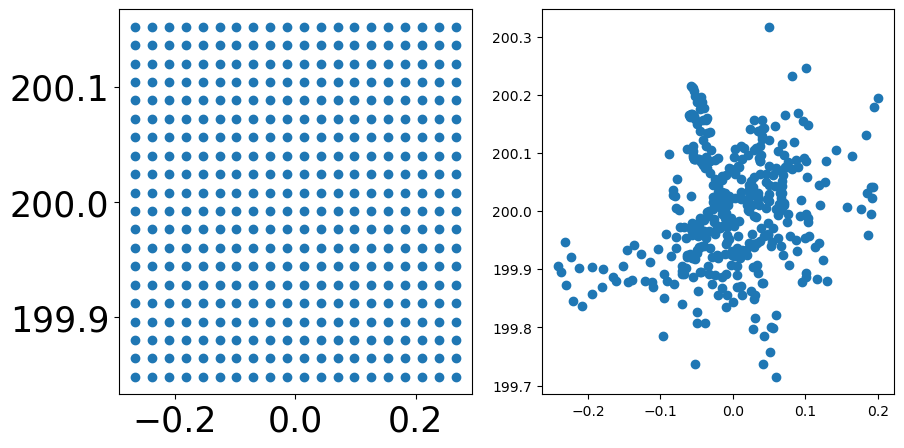

epoch: 8600, train loss: 0.011610043235123158, val loss: 1.089491605758667
epoch: 8601, train loss: 0.011601884849369526, val loss: 1.0895044803619385
epoch: 8602, train loss: 0.011593720875680447, val loss: 1.0894834995269775
epoch: 8603, train loss: 0.011585542932152748, val loss: 1.0894321203231812
epoch: 8604, train loss: 0.01157751027494669, val loss: 1.0894442796707153
epoch: 8605, train loss: 0.011569347232580185, val loss: 1.0894877910614014
epoch: 8606, train loss: 0.011561250314116478, val loss: 1.0894891023635864
epoch: 8607, train loss: 0.011553208343684673, val loss: 1.0894436836242676
epoch: 8608, train loss: 0.011545471847057343, val loss: 1.089448094367981
epoch: 8609, train loss: 0.011537403799593449, val loss: 1.0895309448242188
epoch: 8610, train loss: 0.011529600247740746, val loss: 1.0894771814346313
epoch: 8611, train loss: 0.01152167096734047, val loss: 1.0894562005996704
epoch: 8612, train loss: 0.011513999663293362, val loss: 1.0895030498504639
epoch: 8613, tra

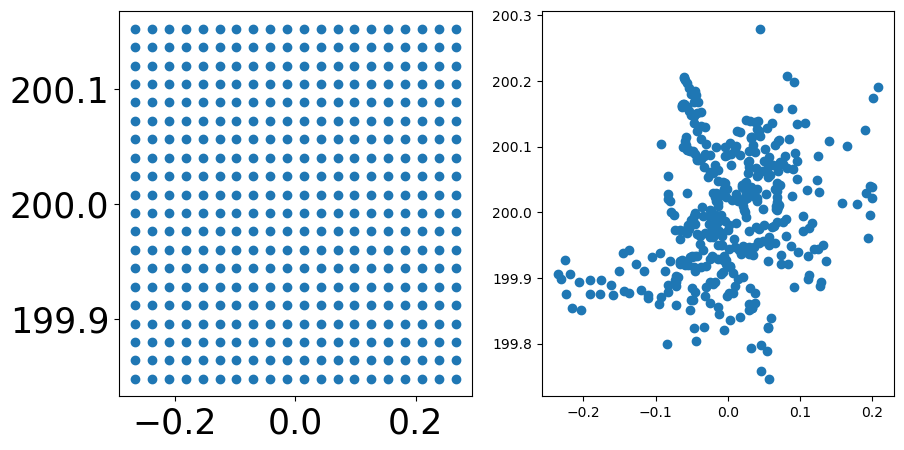

epoch: 8700, train loss: 0.010963759385049343, val loss: 1.0893861055374146
epoch: 8701, train loss: 0.010958652012050152, val loss: 1.0894066095352173
epoch: 8702, train loss: 0.010953559540212154, val loss: 1.0893460512161255
epoch: 8703, train loss: 0.010948482900857925, val loss: 1.0893203020095825
epoch: 8704, train loss: 0.01094349380582571, val loss: 1.0893431901931763
epoch: 8705, train loss: 0.010938423685729504, val loss: 1.0893115997314453
epoch: 8706, train loss: 0.01093353796750307, val loss: 1.0892693996429443
epoch: 8707, train loss: 0.010928490199148655, val loss: 1.0892935991287231
epoch: 8708, train loss: 0.010923488065600395, val loss: 1.0893356800079346
epoch: 8709, train loss: 0.010918584652245045, val loss: 1.0892601013183594
epoch: 8710, train loss: 0.010913760401308537, val loss: 1.0892611742019653
epoch: 8711, train loss: 0.010908989235758781, val loss: 1.0892781019210815
epoch: 8712, train loss: 0.010904215276241302, val loss: 1.0892633199691772
epoch: 8713, t

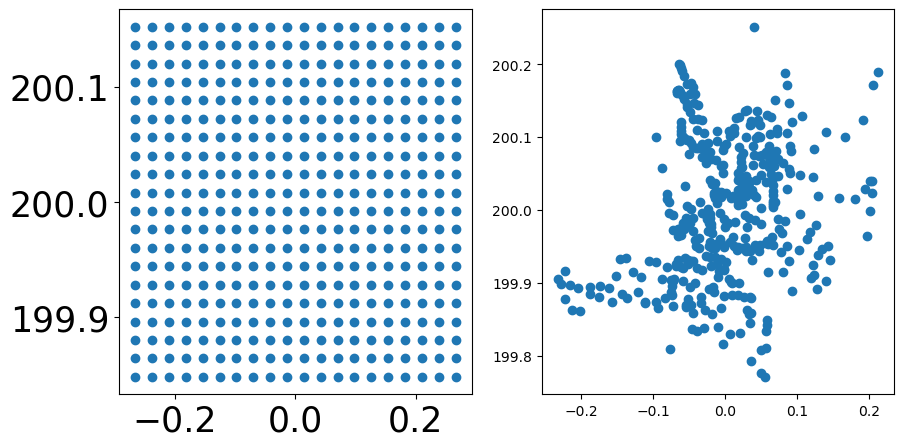

epoch: 8800, train loss: 0.01055832114070654, val loss: 1.0881057977676392
epoch: 8801, train loss: 0.010554886423051357, val loss: 1.08811616897583
epoch: 8802, train loss: 0.010551474057137966, val loss: 1.0880699157714844
epoch: 8803, train loss: 0.010548141784965992, val loss: 1.0880377292633057
epoch: 8804, train loss: 0.010544857010245323, val loss: 1.088086724281311
epoch: 8805, train loss: 0.01054147444665432, val loss: 1.088094711303711
epoch: 8806, train loss: 0.01053816732019186, val loss: 1.088018536567688
epoch: 8807, train loss: 0.010534835048019886, val loss: 1.0879567861557007
epoch: 8808, train loss: 0.010531453415751457, val loss: 1.0880438089370728
epoch: 8809, train loss: 0.010528135113418102, val loss: 1.0880918502807617
epoch: 8810, train loss: 0.010524791665375233, val loss: 1.0880223512649536
epoch: 8811, train loss: 0.010521459393203259, val loss: 1.0879563093185425
epoch: 8812, train loss: 0.010518205352127552, val loss: 1.0879545211791992
epoch: 8813, train l

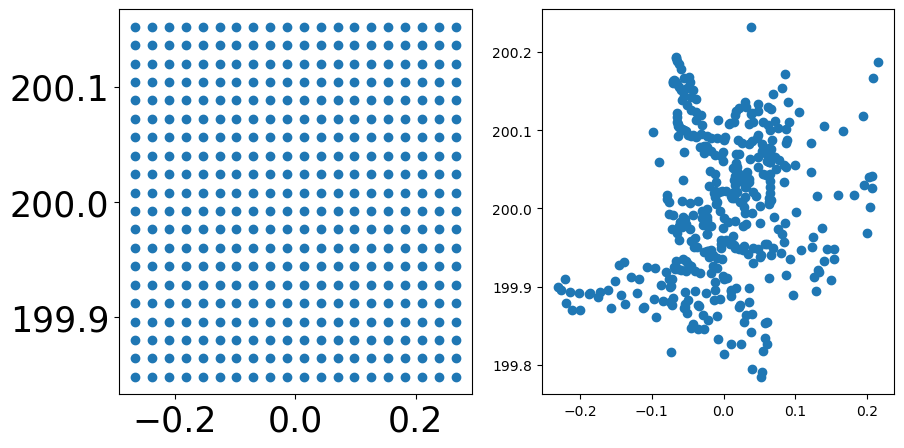

epoch: 8900, train loss: 0.010253741405904293, val loss: 1.0867815017700195
epoch: 8901, train loss: 0.01025097444653511, val loss: 1.0867246389389038
epoch: 8902, train loss: 0.010248185135424137, val loss: 1.0867103338241577
epoch: 8903, train loss: 0.010245387442409992, val loss: 1.0867085456848145
epoch: 8904, train loss: 0.01024269312620163, val loss: 1.0867327451705933
epoch: 8905, train loss: 0.010239941999316216, val loss: 1.086749792098999
epoch: 8906, train loss: 0.010237205773591995, val loss: 1.0866405963897705
epoch: 8907, train loss: 0.010234465822577477, val loss: 1.0865925550460815
epoch: 8908, train loss: 0.01023164950311184, val loss: 1.0867094993591309
epoch: 8909, train loss: 0.01022891141474247, val loss: 1.0866668224334717
epoch: 8910, train loss: 0.010226202197372913, val loss: 1.0865163803100586
epoch: 8911, train loss: 0.010223458521068096, val loss: 1.0865784883499146
epoch: 8912, train loss: 0.010220767930150032, val loss: 1.0866423845291138
epoch: 8913, trai

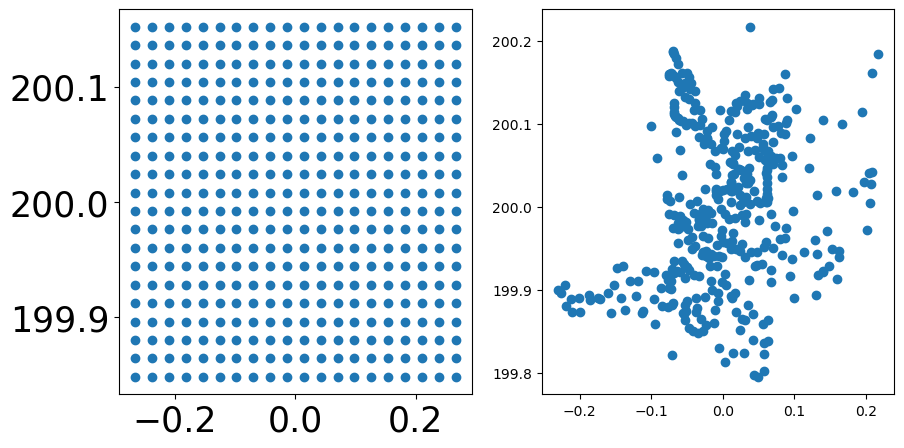

epoch: 9000, train loss: 0.009996775537729263, val loss: 1.0847941637039185
epoch: 9001, train loss: 0.00999439600855112, val loss: 1.0847622156143188
epoch: 9002, train loss: 0.009992108680307865, val loss: 1.0847572088241577
epoch: 9003, train loss: 0.009989687241613865, val loss: 1.084740161895752
epoch: 9004, train loss: 0.00998728722333908, val loss: 1.0846914052963257
epoch: 9005, train loss: 0.00998495239764452, val loss: 1.0846630334854126
epoch: 9006, train loss: 0.009982576593756676, val loss: 1.0847147703170776
epoch: 9007, train loss: 0.0099801542237401, val loss: 1.0846917629241943
epoch: 9008, train loss: 0.009977851063013077, val loss: 1.0846288204193115
epoch: 9009, train loss: 0.009975478053092957, val loss: 1.08461594581604
epoch: 9010, train loss: 0.009973114356398582, val loss: 1.084593653678894
epoch: 9011, train loss: 0.009970705024898052, val loss: 1.0845527648925781
epoch: 9012, train loss: 0.00996851921081543, val loss: 1.084525465965271
epoch: 9013, train loss

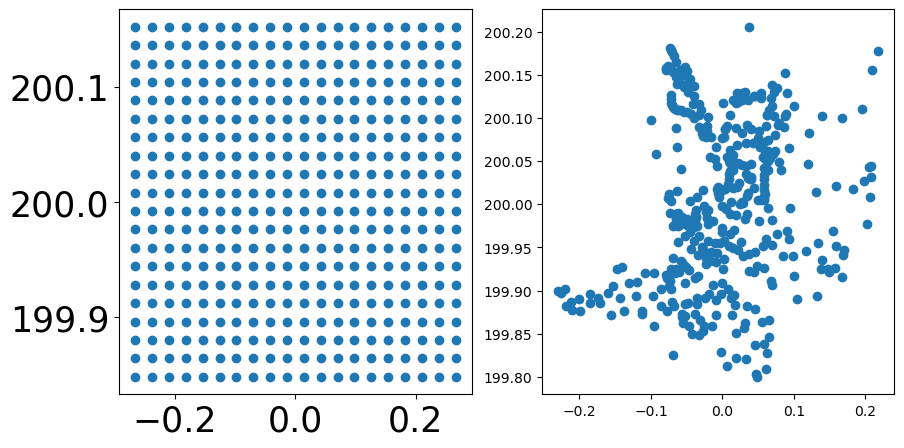

epoch: 9100, train loss: 0.009772498160600662, val loss: 1.082778811454773
epoch: 9101, train loss: 0.009770337492227554, val loss: 1.082749843597412
epoch: 9102, train loss: 0.009768209420144558, val loss: 1.0827786922454834
epoch: 9103, train loss: 0.009766113013029099, val loss: 1.0827463865280151
epoch: 9104, train loss: 0.009764011949300766, val loss: 1.0826774835586548
epoch: 9105, train loss: 0.009761878289282322, val loss: 1.0826315879821777
epoch: 9106, train loss: 0.009759804233908653, val loss: 1.0826609134674072
epoch: 9107, train loss: 0.009757735766470432, val loss: 1.0826503038406372
epoch: 9108, train loss: 0.009755664505064487, val loss: 1.08261239528656
epoch: 9109, train loss: 0.009753548540174961, val loss: 1.0825800895690918
epoch: 9110, train loss: 0.009751345030963421, val loss: 1.082550048828125
epoch: 9111, train loss: 0.009749419055879116, val loss: 1.0824897289276123
epoch: 9112, train loss: 0.00974735151976347, val loss: 1.0825060606002808
epoch: 9113, train

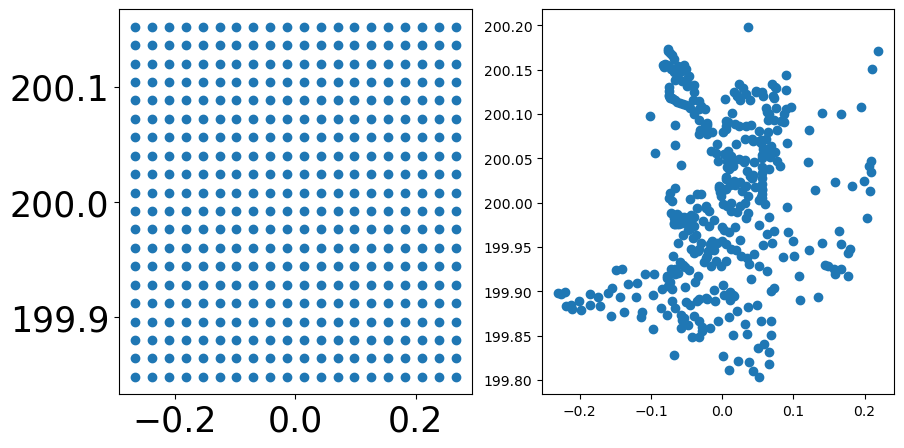

epoch: 9200, train loss: 0.009569996036589146, val loss: 1.0805175304412842
epoch: 9201, train loss: 0.00956799741834402, val loss: 1.0804640054702759
epoch: 9202, train loss: 0.00956614501774311, val loss: 1.0804449319839478
epoch: 9203, train loss: 0.009564182721078396, val loss: 1.0804213285446167
epoch: 9204, train loss: 0.00956218782812357, val loss: 1.0804089307785034
epoch: 9205, train loss: 0.00956028699874878, val loss: 1.0804110765457153
epoch: 9206, train loss: 0.009558426216244698, val loss: 1.0803821086883545
epoch: 9207, train loss: 0.009556405246257782, val loss: 1.0803714990615845
epoch: 9208, train loss: 0.00955450814217329, val loss: 1.080372929573059
epoch: 9209, train loss: 0.009552577510476112, val loss: 1.0803333520889282
epoch: 9210, train loss: 0.009550617076456547, val loss: 1.0803338289260864
epoch: 9211, train loss: 0.009548657573759556, val loss: 1.0803228616714478
epoch: 9212, train loss: 0.009546782821416855, val loss: 1.0802910327911377
epoch: 9213, train

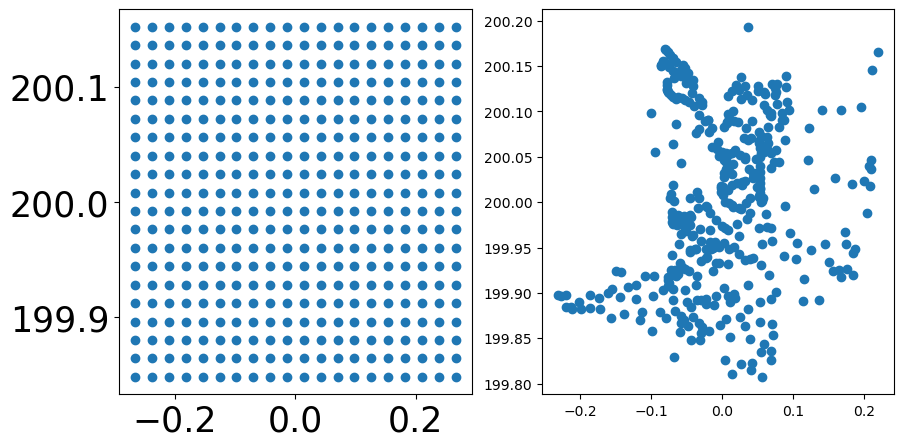

epoch: 9300, train loss: 0.009381089359521866, val loss: 1.0787290334701538
epoch: 9301, train loss: 0.00937920156866312, val loss: 1.0786848068237305
epoch: 9302, train loss: 0.009377345442771912, val loss: 1.0787039995193481
epoch: 9303, train loss: 0.009375594556331635, val loss: 1.0786651372909546
epoch: 9304, train loss: 0.009373734705150127, val loss: 1.078613519668579
epoch: 9305, train loss: 0.009371898137032986, val loss: 1.0786148309707642
epoch: 9306, train loss: 0.009370054118335247, val loss: 1.0785987377166748
epoch: 9307, train loss: 0.009368200786411762, val loss: 1.0785847902297974
epoch: 9308, train loss: 0.009366408921778202, val loss: 1.078547477722168
epoch: 9309, train loss: 0.009364578872919083, val loss: 1.0785610675811768
epoch: 9310, train loss: 0.009362787008285522, val loss: 1.078535556793213
epoch: 9311, train loss: 0.00936098676174879, val loss: 1.0784828662872314
epoch: 9312, train loss: 0.00935911014676094, val loss: 1.0784931182861328
epoch: 9313, train

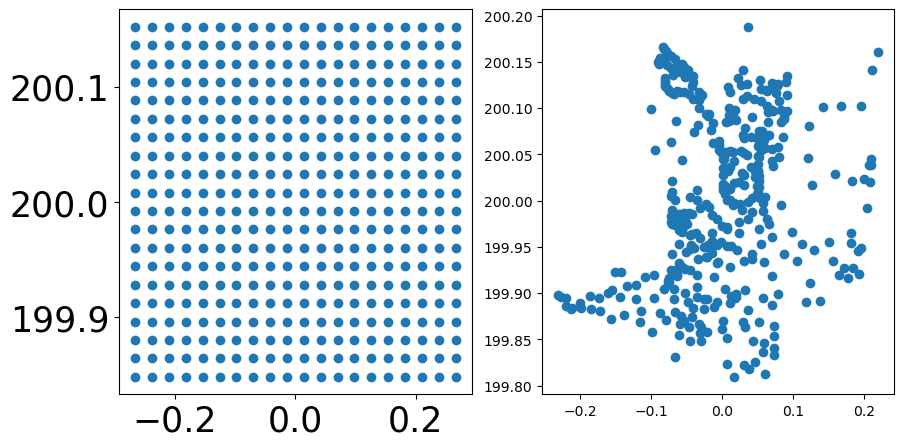

epoch: 9400, train loss: 0.009201661683619022, val loss: 1.0767440795898438
epoch: 9401, train loss: 0.0092000188305974, val loss: 1.0766971111297607
epoch: 9402, train loss: 0.00919828750193119, val loss: 1.0766645669937134
epoch: 9403, train loss: 0.009196644648909569, val loss: 1.0766478776931763
epoch: 9404, train loss: 0.009194950573146343, val loss: 1.0766546726226807
epoch: 9405, train loss: 0.009193218313157558, val loss: 1.0766334533691406
epoch: 9406, train loss: 0.00919151771813631, val loss: 1.0765715837478638
epoch: 9407, train loss: 0.009189801290631294, val loss: 1.0766123533248901
epoch: 9408, train loss: 0.009188128635287285, val loss: 1.0765794515609741
epoch: 9409, train loss: 0.009186425246298313, val loss: 1.0765304565429688
epoch: 9410, train loss: 0.009184709750115871, val loss: 1.0765644311904907
epoch: 9411, train loss: 0.00918298214673996, val loss: 1.0765272378921509
epoch: 9412, train loss: 0.009181301109492779, val loss: 1.0764505863189697
epoch: 9413, trai

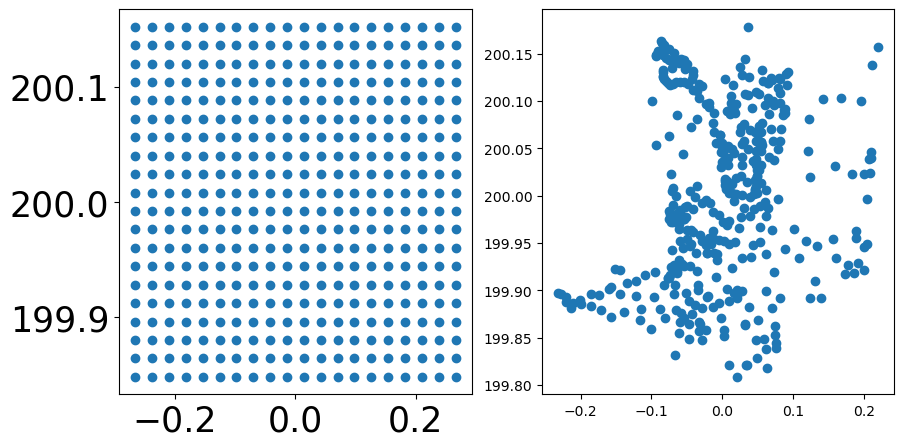

epoch: 9500, train loss: 0.009032600559294224, val loss: 1.0744917392730713
epoch: 9501, train loss: 0.009030945599079132, val loss: 1.0744717121124268
epoch: 9502, train loss: 0.009029281325638294, val loss: 1.0744845867156982
epoch: 9503, train loss: 0.009027567692101002, val loss: 1.0744128227233887
epoch: 9504, train loss: 0.009025859646499157, val loss: 1.074384093284607
epoch: 9505, train loss: 0.009024153463542461, val loss: 1.0743660926818848
epoch: 9506, train loss: 0.009022509679198265, val loss: 1.0743448734283447
epoch: 9507, train loss: 0.009020828641951084, val loss: 1.0743080377578735
epoch: 9508, train loss: 0.009019128046929836, val loss: 1.0742912292480469
epoch: 9509, train loss: 0.009017447009682655, val loss: 1.0742491483688354
epoch: 9510, train loss: 0.009015772491693497, val loss: 1.0742255449295044
epoch: 9511, train loss: 0.009014078415930271, val loss: 1.0741955041885376
epoch: 9512, train loss: 0.009012427181005478, val loss: 1.0741527080535889
epoch: 9513, 

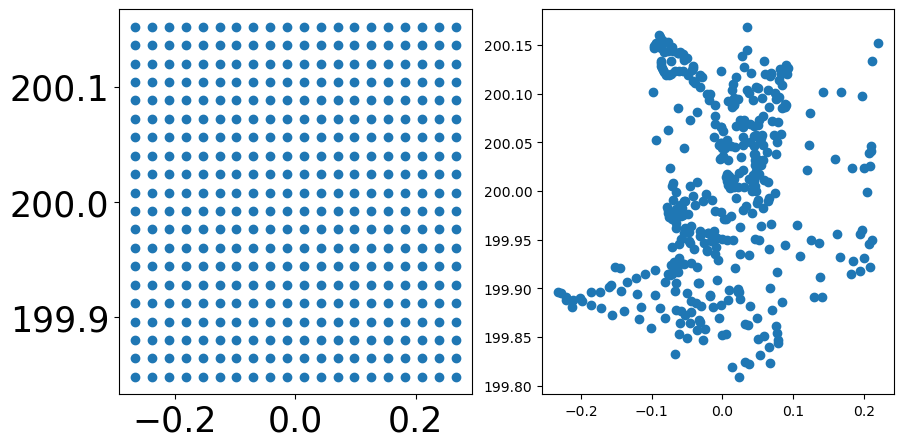

epoch: 9600, train loss: 0.008865890093147755, val loss: 1.0711534023284912
epoch: 9601, train loss: 0.008864262141287327, val loss: 1.0710902214050293
epoch: 9602, train loss: 0.0088626304641366, val loss: 1.0710227489471436
epoch: 9603, train loss: 0.008860929869115353, val loss: 1.0710214376449585
epoch: 9604, train loss: 0.008859340101480484, val loss: 1.0709408521652222
epoch: 9605, train loss: 0.008857720531523228, val loss: 1.070933222770691
epoch: 9606, train loss: 0.008856049738824368, val loss: 1.070902705192566
epoch: 9607, train loss: 0.008854435756802559, val loss: 1.0708109140396118
epoch: 9608, train loss: 0.00885283574461937, val loss: 1.0708072185516357
epoch: 9609, train loss: 0.008851243183016777, val loss: 1.070772647857666
epoch: 9610, train loss: 0.008849537931382656, val loss: 1.0707162618637085
epoch: 9611, train loss: 0.008847939781844616, val loss: 1.0706939697265625
epoch: 9612, train loss: 0.008846333250403404, val loss: 1.0706130266189575
epoch: 9613, train

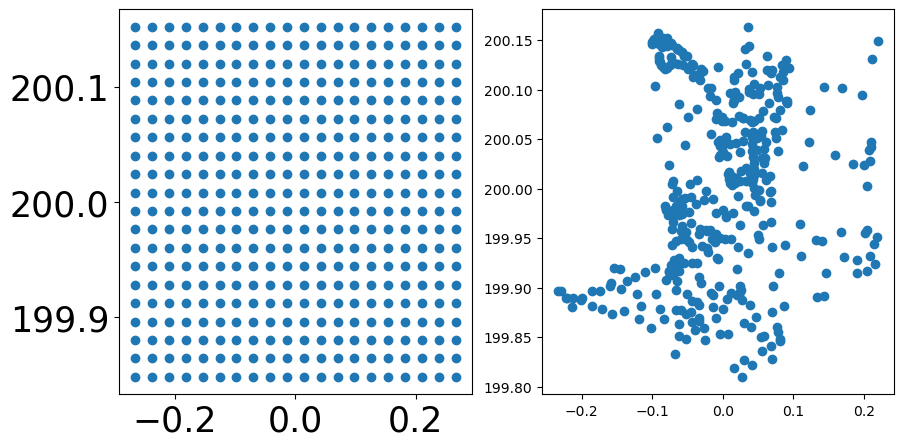

epoch: 9700, train loss: 0.008704484440386295, val loss: 1.0668796300888062
epoch: 9701, train loss: 0.008702908642590046, val loss: 1.0668514966964722
epoch: 9702, train loss: 0.008701332844793797, val loss: 1.0668261051177979
epoch: 9703, train loss: 0.008699719794094563, val loss: 1.0667262077331543
epoch: 9704, train loss: 0.008698130957782269, val loss: 1.0667487382888794
epoch: 9705, train loss: 0.008696506731212139, val loss: 1.0666483640670776
epoch: 9706, train loss: 0.00869495328515768, val loss: 1.06663978099823
epoch: 9707, train loss: 0.0086933309212327, val loss: 1.066596508026123
epoch: 9708, train loss: 0.008691695518791676, val loss: 1.066524624824524
epoch: 9709, train loss: 0.00869011227041483, val loss: 1.0665104389190674
epoch: 9710, train loss: 0.008688483387231827, val loss: 1.0664128065109253
epoch: 9711, train loss: 0.008686945773661137, val loss: 1.066402554512024
epoch: 9712, train loss: 0.008685325272381306, val loss: 1.0664054155349731
epoch: 9713, train lo

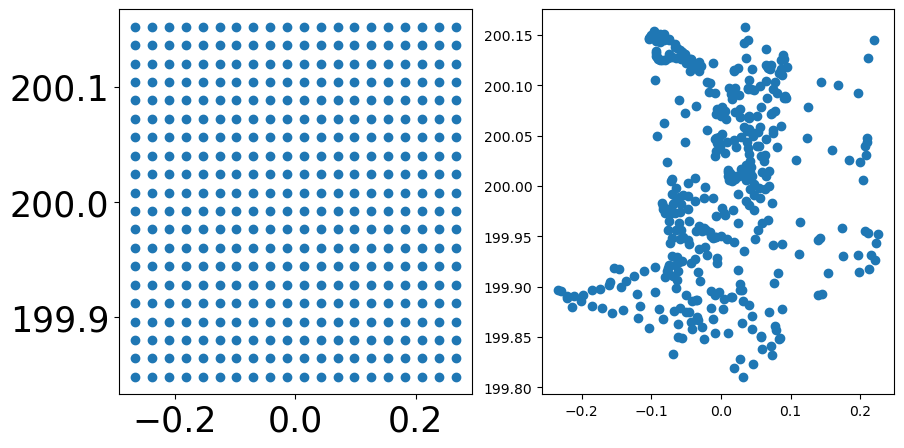

epoch: 9800, train loss: 0.008546079508960247, val loss: 1.0623737573623657
epoch: 9801, train loss: 0.008544491603970528, val loss: 1.0623664855957031
epoch: 9802, train loss: 0.008542947471141815, val loss: 1.0622435808181763
epoch: 9803, train loss: 0.008541344664990902, val loss: 1.0622299909591675
epoch: 9804, train loss: 0.00853978842496872, val loss: 1.0621907711029053
epoch: 9805, train loss: 0.00853822287172079, val loss: 1.0621033906936646
epoch: 9806, train loss: 0.008536696434020996, val loss: 1.0620968341827393
epoch: 9807, train loss: 0.008535102009773254, val loss: 1.0620143413543701
epoch: 9808, train loss: 0.008533538319170475, val loss: 1.0619399547576904
epoch: 9809, train loss: 0.008532004430890083, val loss: 1.0619515180587769
epoch: 9810, train loss: 0.008530464954674244, val loss: 1.061863660812378
epoch: 9811, train loss: 0.008528904989361763, val loss: 1.0617947578430176
epoch: 9812, train loss: 0.008527352474629879, val loss: 1.0617603063583374
epoch: 9813, tr

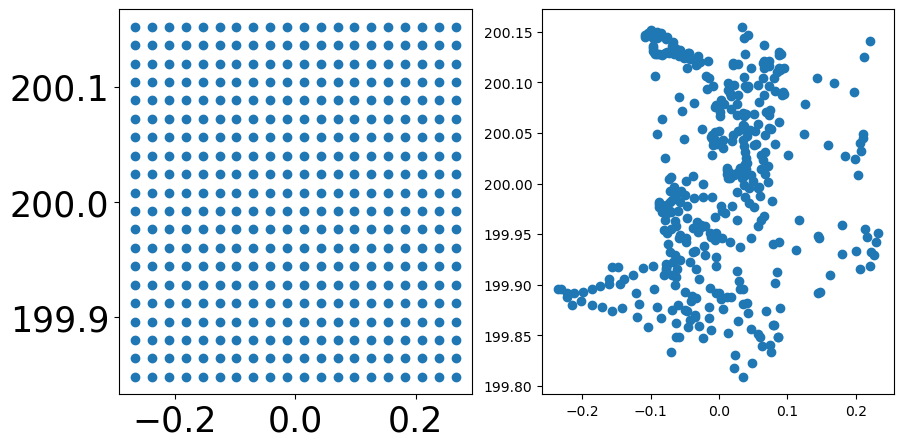

epoch: 9900, train loss: 0.00839330442249775, val loss: 1.0567634105682373
epoch: 9901, train loss: 0.008391885086894035, val loss: 1.056699275970459
epoch: 9902, train loss: 0.008390484377741814, val loss: 1.056742787361145
epoch: 9903, train loss: 0.008389069698750973, val loss: 1.0565516948699951
epoch: 9904, train loss: 0.008387673646211624, val loss: 1.0565400123596191
epoch: 9905, train loss: 0.008386402390897274, val loss: 1.0565145015716553
epoch: 9906, train loss: 0.008385250344872475, val loss: 1.056388020515442
epoch: 9907, train loss: 0.00838429294526577, val loss: 1.0563971996307373
epoch: 9908, train loss: 0.008383668027818203, val loss: 1.056297779083252
epoch: 9909, train loss: 0.008383551612496376, val loss: 1.0562394857406616
epoch: 9910, train loss: 0.008384411223232746, val loss: 1.0561463832855225
epoch: 9911, train loss: 0.008386658504605293, val loss: 1.0562164783477783
epoch: 9912, train loss: 0.008391392417252064, val loss: 1.0559628009796143
epoch: 9913, train

In [ ]:
#cc data training #(x, y) coords 
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

labeled_data=400
layer_loss_list=[]
Epochs=10000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[64]*11#[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC_XY_targs(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%100==0:
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=25)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b)
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    #if epoch%1000==0:
    #    H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5, xpix=20, ypix=20, font_size=25)
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')


#torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [4]:
rho.shape, rho_hat.shape

(torch.Size([400, 2]), torch.Size([400, 1, 1]))